# **traininingAggression project:** SpikeSorting pipeline

In [6]:
from pathlib import Path
import numpy as np
import subprocess, sys, time
import shutil
import torch
import kilosort
import spikeinterface.full as si
from spikeinterface.preprocessing import bandpass_filter, common_reference
from spikeinterface.sortingcomponents.motion import interpolate_motion
import matplotlib.pylab as plt
import random
from itertools import groupby

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [7]:
dt_folder = Path(r"J:\project_trainingAggression\Data")

ni_data = sorted(dt_folder.rglob("*nidq.bin"))
run_folders = [rf.parent for rf in ni_data]
s = "catgt_"
catGT_runs = [cgt.name.split(s)[1] for cgt in sorted(dt_folder.rglob("catgt*"))]

unprocessed_neuralData_folders = [rf for rf in run_folders if rf.name[len(s):] not in catGT_runs]

if len(unprocessed_neuralData_folders) == 0:
    print("No files to process found.")
else: 
    print("Runs to process with catGT:")
    for rf in unprocessed_neuralData_folders:
        print("  ", rf)

No files to process found.


## **Pre-processing**

https://billkarsh.github.io/SpikeGLX/help/syncEdges/Sync_edges/

### catGT: Single probe demultiplexing corrections and TTL event extraction

**Documentation:** file:///C:/Users/Data%20Analysis/Desktop/CatGT-win/ReadMe.html

If Exit code 42, see CatGT log in __J:\project_trainingAggression\Code\Neurpixels_aggressionTraining\CatGT.txt__

In [8]:
catGT = (r"C:\Users\Data Analysis\Desktop\CatGT-win\CatGT.exe")

for folderRun in unprocessed_neuralData_folders:

    start = time.time()

    dataFolder = folderRun.parent
    spikeGLX_run = folderRun.name 
    if ("_g0" in spikeGLX_run):
        spikeGLX_run = spikeGLX_run[0:-3]# Removes "_g0" from filename

    print(f"Multiplexer temporal shift correction in session: {spikeGLX_run}")

    cmd = [
            str(catGT),
            f"-dir={dataFolder}",  
            f"-run={spikeGLX_run}",
            "-g=0",
            "-t=0",            
            "-ap",              # Process Action Potential (.ap.bin) files
            "-prb=0:2",         # Probe 1 to 3
            "-ni",              # Process the auxiliary data (.niqd.bin) containing both Analog and Digital channels
            "-prb_fld",         # 1 probe per folder
            "-maxsecs=1205.00", # 20 min + 5 seconds


            # ========= -xd = js,ip,word,bit,pulsewidth(ms),tol(ms) =========

            "-xid=0,0,3,2,50,5",               # Sweetened milk events: falling edges (P.02)
            #"-xd=0,0,8,2,15000, 1000",        # Sweetened milk events: rising edges (P.02)

            "-xd=0,0,3,3,0",                   # LED red light ON: rising edges (P.03)
            "-xid=0,0,3,3,360000,5000",        # LED white light ON: falling edge (P.03)  

            "-xd=0,0,3,4, 1000000,500000",     # Gate OPEN: rising edge (P.04)

            "-xd=0,0,3,5,3500,500",            # uArm ON: rising edges (P.05)
            "-xid=0,0,3,5,11000,3000",         # uArm OFF: falling edges (P.05) (Not all of them will be picked up but it is good to know the average trial duration)

            f"-dest={dataFolder}",
            "-pass1_force_ni_ob_bin",
            "-out_prb_fld",
          ]
    
    p = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
    for line in p.stdout:
        sys.stdout.write(line)
    rc = p.wait()

    shutil.rmtree(folderRun) # Deleting original run folder

    end = time.time()

    print(f"Exit code: {rc}. Running time (1 SpikeGLX run): {(end - start)/60: .2f} min.\n")


### **Band-pass filtering (300 - 6000 Hz), Common Median Reference (CRM), Motion correction (DREDge), and whitening**

### __Then Kilosort4 is applied__

**SpikeInterface documentation:** https://spikeinterface.readthedocs.io/en/stable/overview.html

**High level pipeline for motion correction using DREDge:** https://spikeinterface.readthedocs.io/en/latest/how_to/handle_drift.html

**Low level pipeline for motion correction using DREDge:** https://spikeinterface.readthedocs.io/en/latest/modules/sortingcomponents.html#motion-interpolation


In [11]:
def filter_unprocessed(files):
    out = []
    for f in files:
        if not any(p.is_dir() for p in f.parent.rglob("kilosort4*")):
            out.append(f)
    return out

tcat_bin_files  = filter_unprocessed(sorted(dt_folder.rglob("*_tcat.imec*.ap.bin")))
tcat_meta_files = filter_unprocessed(sorted(dt_folder.rglob("*_tcat.imec*.ap.meta")))

def session_key(p):
    p = str(p)  # works for string paths or Path objects
    return next(part for part in p.split("\\") if part.startswith("catgt_"))

# groupby needs equal keys adjacent, so sort first
paths_sorted = sorted(tcat_bin_files, key=session_key)

session_groups = [list(g) for _, g in groupby(paths_sorted, key=session_key)]
session_groups

[[WindowsPath('J:/project_trainingAggression/Data/Maladaptive/Controls/20251110_mouse978528/Day25/neuralData/catgt_20251110_m978528_obs5_g0/20251110_m978528_obs5_g0_imec0/20251110_m978528_obs5_g0_tcat.imec0.ap.bin'),
  WindowsPath('J:/project_trainingAggression/Data/Maladaptive/Controls/20251110_mouse978528/Day25/neuralData/catgt_20251110_m978528_obs5_g0/20251110_m978528_obs5_g0_imec1/20251110_m978528_obs5_g0_tcat.imec1.ap.bin'),
  WindowsPath('J:/project_trainingAggression/Data/Maladaptive/Controls/20251110_mouse978528/Day25/neuralData/catgt_20251110_m978528_obs5_g0/20251110_m978528_obs5_g0_imec2/20251110_m978528_obs5_g0_tcat.imec2.ap.bin')],
 [WindowsPath('J:/project_trainingAggression/Data/Maladaptive/Controls/20251110_mouse978528/Day26/neuralData/catgt_20251110_m978528_obs6_g0/20251110_m978528_obs6_g0_imec0/20251110_m978528_obs6_g0_tcat.imec0.ap.bin'),
  WindowsPath('J:/project_trainingAggression/Data/Maladaptive/Controls/20251110_mouse978528/Day26/neuralData/catgt_20251110_m978528

__Motion correction plots meaning:__

top left: time vs estimated peak

top right: time vs peak depth after motion correction

bottom left: the average motion vector across depths and all motion across spatial depths (for non-rigid estimation)

bottom right: if motion correction is non rigid, the motion vector across depths is plotted as a map, with the color code representing the motion in micrometers.

Compute DREDge motion correction on session: 20251110_m978528_obs5_g0


noise_level (workers: 16 processes):   0%|          | 0/20 [00:00<?, ?it/s]

detect and localize (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

Cross correlation:   0%|          | 0/9 [00:00<?, ?it/s]

Solve:   0%|          | 0/8 [00:00<?, ?it/s]

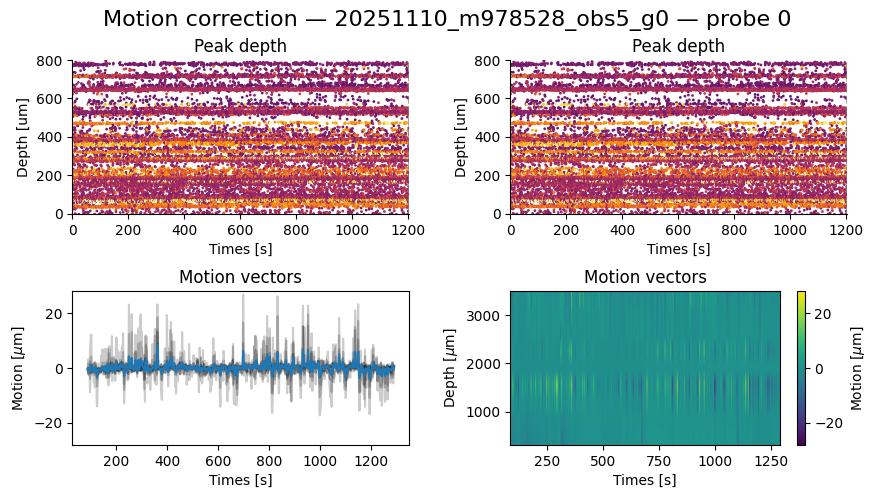

write_binary_recording (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

kilosort.run_kilosort:  
kilosort.run_kilosort: Computing drift correction.
kilosort.run_kilosort: ----------------------------------------
kilosort.datashift: nblocks = 0, skipping drift correction
kilosort.run_kilosort: drift computed in 0.01s; total 0.02s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after drift correction
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:    37.50 %
kilosort.run_kilosort: Mem used:      9.50 %     |      12.20 GB
kilosort.run_kilosort: Mem avail:    115.80 / 128.00 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   50.41 %     |      6.05   /    12.00 GB
kilosort.run_kilosort: Allocated:     0.07 %     |      0.01   /    12.00 GB
kilosort.run_kilosort: Max alloc:     7.68 %     |      0.92   /    12.00 GB
kilosort.run_kilosort: ***

Skipping common average reference.
Skipping kilosort preprocessing.
Skipping drift correction.


kilosort.spikedetect: Number of universal templates: 1512
kilosort.spikedetect: Detecting spikes...
100%|██████████| 603/603 [09:49<00:00,  1.02it/s]
kilosort.run_kilosort: 2551859 spikes extracted in 594.58s; total 594.63s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after spike detect (univ)
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:    14.30 %
kilosort.run_kilosort: Mem used:     10.40 %     |      13.28 GB
kilosort.run_kilosort: Mem avail:    114.72 / 128.00 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   50.41 %     |      6.05   /    12.00 GB
kilosort.run_kilosort: Allocated:     0.08 %     |      0.01   /    12.00 GB
kilosort.run_kilosort: Max alloc:    27.20 %     |      3.26   /    12.00 GB
kilosort.run_kilosort: ***********************************

kilosort4 run time 1351.97s


noise_level (workers: 16 processes):   0%|          | 0/20 [00:00<?, ?it/s]

detect and localize (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

Cross correlation:   0%|          | 0/9 [00:00<?, ?it/s]

Solve:   0%|          | 0/8 [00:00<?, ?it/s]

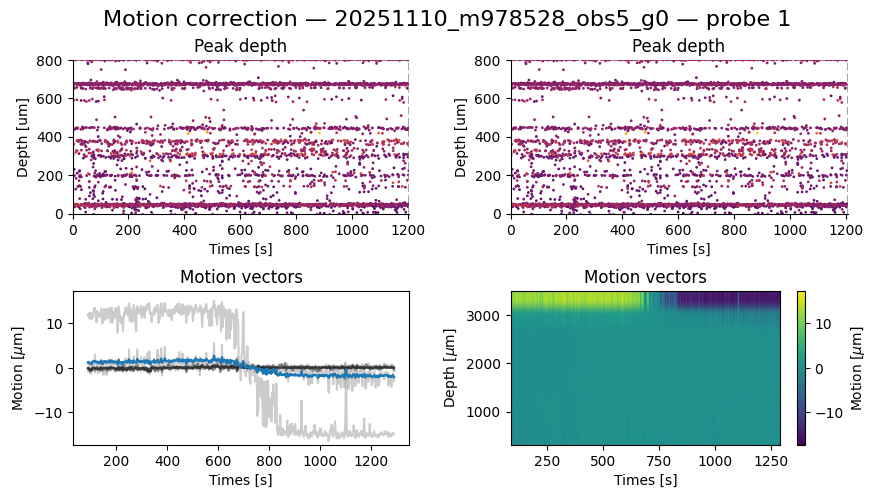

write_binary_recording (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

kilosort.run_kilosort:  
kilosort.run_kilosort: Computing drift correction.
kilosort.run_kilosort: ----------------------------------------
kilosort.datashift: nblocks = 0, skipping drift correction
kilosort.run_kilosort: drift computed in 0.01s; total 0.02s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after drift correction
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:    33.30 %
kilosort.run_kilosort: Mem used:      9.50 %     |      12.21 GB
kilosort.run_kilosort: Mem avail:    115.79 / 128.00 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   50.41 %     |      6.05   /    12.00 GB
kilosort.run_kilosort: Allocated:     0.07 %     |      0.01   /    12.00 GB
kilosort.run_kilosort: Max alloc:     7.68 %     |      0.92   /    12.00 GB
kilosort.run_kilosort: ***

Skipping common average reference.
Skipping kilosort preprocessing.
Skipping drift correction.


kilosort.spikedetect: Number of universal templates: 1512
kilosort.spikedetect: Detecting spikes...
100%|██████████| 603/603 [09:48<00:00,  1.03it/s]
kilosort.run_kilosort: 3340111 spikes extracted in 593.88s; total 593.94s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after spike detect (univ)
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:     0.00 %
kilosort.run_kilosort: Mem used:     10.40 %     |      13.28 GB
kilosort.run_kilosort: Mem avail:    114.72 / 128.00 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   50.41 %     |      6.05   /    12.00 GB
kilosort.run_kilosort: Allocated:     0.08 %     |      0.01   /    12.00 GB
kilosort.run_kilosort: Max alloc:    27.28 %     |      3.27   /    12.00 GB
kilosort.run_kilosort: ***********************************

kilosort4 run time 1475.65s


noise_level (workers: 16 processes):   0%|          | 0/20 [00:00<?, ?it/s]

detect and localize (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

Cross correlation:   0%|          | 0/9 [00:00<?, ?it/s]

Solve:   0%|          | 0/8 [00:00<?, ?it/s]

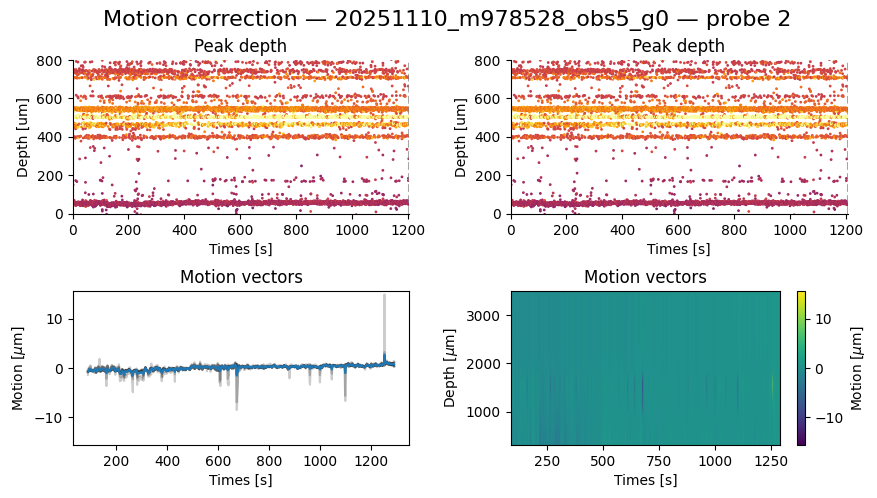

write_binary_recording (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

kilosort.run_kilosort:  
kilosort.run_kilosort: Computing drift correction.
kilosort.run_kilosort: ----------------------------------------
kilosort.datashift: nblocks = 0, skipping drift correction
kilosort.run_kilosort: drift computed in 0.01s; total 0.01s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after drift correction
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:    18.80 %
kilosort.run_kilosort: Mem used:      9.50 %     |      12.18 GB
kilosort.run_kilosort: Mem avail:    115.82 / 128.00 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   50.41 %     |      6.05   /    12.00 GB
kilosort.run_kilosort: Allocated:     0.07 %     |      0.01   /    12.00 GB
kilosort.run_kilosort: Max alloc:     7.68 %     |      0.92   /    12.00 GB
kilosort.run_kilosort: ***

Skipping common average reference.
Skipping kilosort preprocessing.
Skipping drift correction.


kilosort.spikedetect: Number of universal templates: 1512
kilosort.spikedetect: Detecting spikes...
100%|██████████| 603/603 [09:08<00:00,  1.10it/s]
kilosort.run_kilosort: 3484309 spikes extracted in 554.32s; total 554.36s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after spike detect (univ)
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:     0.00 %
kilosort.run_kilosort: Mem used:     10.30 %     |      13.24 GB
kilosort.run_kilosort: Mem avail:    114.76 / 128.00 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   50.41 %     |      6.05   /    12.00 GB
kilosort.run_kilosort: Allocated:     0.08 %     |      0.01   /    12.00 GB
kilosort.run_kilosort: Max alloc:    27.25 %     |      3.27   /    12.00 GB
kilosort.run_kilosort: ***********************************

kilosort4 run time 1507.53s
Compute DREDge motion correction on session: 20251110_m978528_obs6_g0


noise_level (workers: 16 processes):   0%|          | 0/20 [00:00<?, ?it/s]

detect and localize (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

Cross correlation:   0%|          | 0/9 [00:00<?, ?it/s]

Solve:   0%|          | 0/8 [00:00<?, ?it/s]

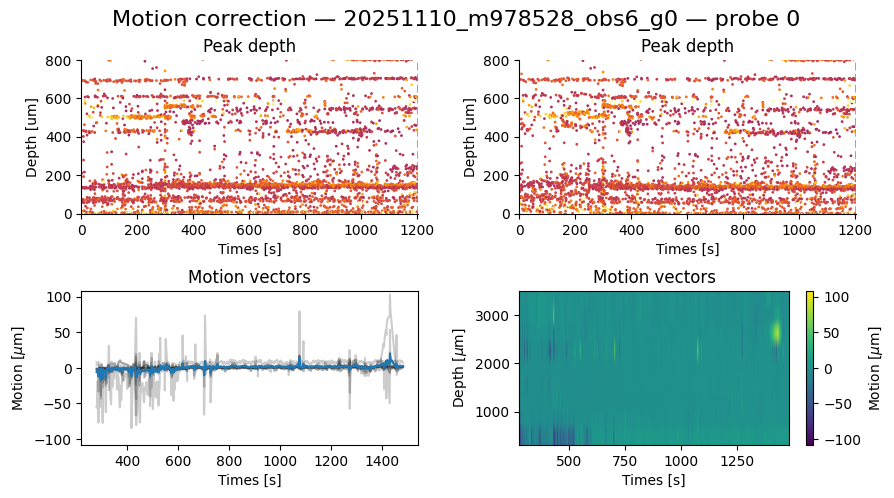

write_binary_recording (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

kilosort.run_kilosort:  
kilosort.run_kilosort: Computing drift correction.
kilosort.run_kilosort: ----------------------------------------
kilosort.datashift: nblocks = 0, skipping drift correction
kilosort.run_kilosort: drift computed in 0.01s; total 0.01s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after drift correction
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:     0.00 %
kilosort.run_kilosort: Mem used:      9.50 %     |      12.20 GB
kilosort.run_kilosort: Mem avail:    115.80 / 128.00 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   50.41 %     |      6.05   /    12.00 GB
kilosort.run_kilosort: Allocated:     0.07 %     |      0.01   /    12.00 GB
kilosort.run_kilosort: Max alloc:     7.68 %     |      0.92   /    12.00 GB
kilosort.run_kilosort: ***

Skipping common average reference.
Skipping kilosort preprocessing.
Skipping drift correction.


kilosort.spikedetect: Number of universal templates: 1480
kilosort.spikedetect: Detecting spikes...
100%|██████████| 603/603 [08:56<00:00,  1.12it/s]
kilosort.run_kilosort: 2385859 spikes extracted in 540.66s; total 540.72s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after spike detect (univ)
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:     0.00 %
kilosort.run_kilosort: Mem used:     10.40 %     |      13.28 GB
kilosort.run_kilosort: Mem avail:    114.72 / 128.00 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   50.41 %     |      6.05   /    12.00 GB
kilosort.run_kilosort: Allocated:     0.08 %     |      0.01   /    12.00 GB
kilosort.run_kilosort: Max alloc:    26.67 %     |      3.20   /    12.00 GB
kilosort.run_kilosort: ***********************************

kilosort4 run time 1037.18s


noise_level (workers: 16 processes):   0%|          | 0/20 [00:00<?, ?it/s]

detect and localize (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

Cross correlation:   0%|          | 0/9 [00:00<?, ?it/s]

Solve:   0%|          | 0/8 [00:00<?, ?it/s]

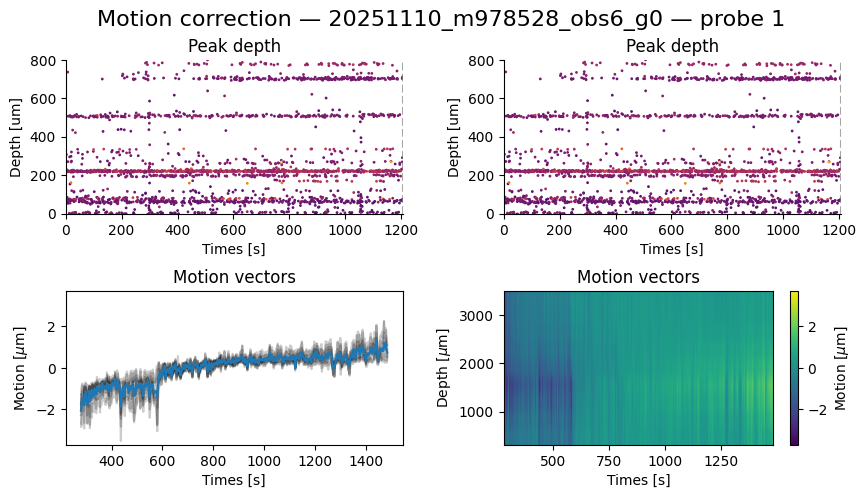

write_binary_recording (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

kilosort.run_kilosort:  
kilosort.run_kilosort: Computing drift correction.
kilosort.run_kilosort: ----------------------------------------
kilosort.datashift: nblocks = 0, skipping drift correction
kilosort.run_kilosort: drift computed in 0.00s; total 0.02s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after drift correction
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:     0.00 %
kilosort.run_kilosort: Mem used:      9.60 %     |      12.25 GB
kilosort.run_kilosort: Mem avail:    115.75 / 128.00 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   50.41 %     |      6.05   /    12.00 GB
kilosort.run_kilosort: Allocated:     0.07 %     |      0.01   /    12.00 GB
kilosort.run_kilosort: Max alloc:     7.68 %     |      0.92   /    12.00 GB
kilosort.run_kilosort: ***

Skipping common average reference.
Skipping kilosort preprocessing.
Skipping drift correction.


kilosort.spikedetect: Number of universal templates: 1512
kilosort.spikedetect: Detecting spikes...
100%|██████████| 603/603 [09:06<00:00,  1.10it/s]
kilosort.run_kilosort: 2901356 spikes extracted in 552.35s; total 552.42s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after spike detect (univ)
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:     7.70 %
kilosort.run_kilosort: Mem used:     10.40 %     |      13.32 GB
kilosort.run_kilosort: Mem avail:    114.68 / 128.00 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   50.41 %     |      6.05   /    12.00 GB
kilosort.run_kilosort: Allocated:     0.08 %     |      0.01   /    12.00 GB
kilosort.run_kilosort: Max alloc:    27.24 %     |      3.27   /    12.00 GB
kilosort.run_kilosort: ***********************************

kilosort4 run time 1345.20s


noise_level (workers: 16 processes):   0%|          | 0/20 [00:00<?, ?it/s]

detect and localize (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

Cross correlation:   0%|          | 0/9 [00:00<?, ?it/s]

Solve:   0%|          | 0/8 [00:00<?, ?it/s]

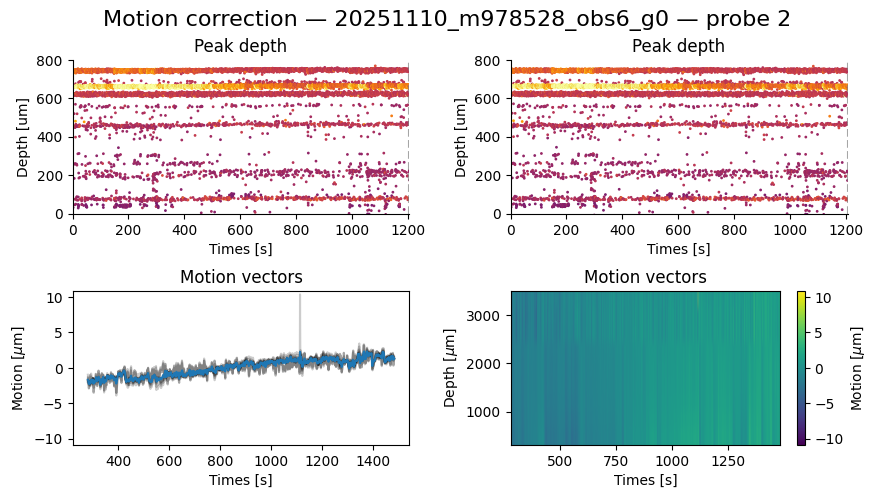

write_binary_recording (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

kilosort.run_kilosort:  
kilosort.run_kilosort: Computing drift correction.
kilosort.run_kilosort: ----------------------------------------
kilosort.datashift: nblocks = 0, skipping drift correction
kilosort.run_kilosort: drift computed in 0.02s; total 0.02s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after drift correction
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:     0.00 %
kilosort.run_kilosort: Mem used:      9.60 %     |      12.32 GB
kilosort.run_kilosort: Mem avail:    115.68 / 128.00 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   50.41 %     |      6.05   /    12.00 GB
kilosort.run_kilosort: Allocated:     0.07 %     |      0.01   /    12.00 GB
kilosort.run_kilosort: Max alloc:     7.68 %     |      0.92   /    12.00 GB
kilosort.run_kilosort: ***

Skipping common average reference.
Skipping kilosort preprocessing.
Skipping drift correction.


kilosort.spikedetect: Number of universal templates: 1512
kilosort.spikedetect: Detecting spikes...
100%|██████████| 603/603 [08:54<00:00,  1.13it/s]
kilosort.run_kilosort: 3880447 spikes extracted in 540.89s; total 540.96s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after spike detect (univ)
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:     0.00 %
kilosort.run_kilosort: Mem used:     10.40 %     |      13.34 GB
kilosort.run_kilosort: Mem avail:    114.66 / 128.00 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   50.41 %     |      6.05   /    12.00 GB
kilosort.run_kilosort: Allocated:     0.08 %     |      0.01   /    12.00 GB
kilosort.run_kilosort: Max alloc:    27.28 %     |      3.27   /    12.00 GB
kilosort.run_kilosort: ***********************************

kilosort4 run time 1556.30s


In [12]:
preset = "dredge"
params_kilosort4 = {'do_CAR': False,
                    'skip_kilosort_preprocessing': True,
                    'do_correction': False,
                    'torch_device':'cuda',
                    'delete_recording_dat': False,
                    'n_jobs': 16}


for session in session_groups:

    session_name = str(session[0].name).split("_tcat")[0]

    print("Compute DREDge motion correction on session:", session_name)

    for it, probe in enumerate(session):

        ''' ==================================== Pre-processing: BP filter and CMR ==================================== '''

        raw_rec = si.read_spikeglx(probe.parent, 
                                   stream_name=f'imec{it}.ap', 
                                   load_sync_channel=False)

        pre_processed_rec = common_reference(bandpass_filter(recording = raw_rec,
                                                            freq_min = 300,
                                                            freq_max = 6000), 
                                            operator="median", 
                                            reference="global")

        ''' ==================================== Motion correction: DREDge ==================================== '''

        motion, motion_info = si.compute_motion(pre_processed_rec, 
                                                preset=preset, 
                                                folder=f"{probe.parent}/DREDge_probe{it}" , 
                                                output_motion_info=True,
                                                n_jobs = 16)
        
        fig = plt.figure(figsize=(10, 5))

        si.plot_motion_info(
            motion_info, 
            pre_processed_rec,
            figure = fig,
            depth_lim=(0, 800),
            color_amplitude=True,
            amplitude_cmap="inferno",
            scatter_decimate=10,
        )

        fig.suptitle(f"Motion correction — {session_name} — probe {it}",
                     fontsize=16)
        plt.show()

        interpolated_rec = interpolate_motion(recording=pre_processed_rec.astype('float32'), 
                                              motion=motion)
        
        ''' ==================================== Spikesorting: Whitening ==================================== '''

        motion_corrected_rec = si.whiten(interpolated_rec)

        ''' ==================================== Spikesorting: Kilosort4 ==================================== '''
        
        params_kilosort4['fs'] = interpolated_rec.get_sampling_frequency()

        sorting = si.run_sorter('kilosort4', 
                                 motion_corrected_rec, 
                                 folder=f"{probe.parent}/Kilosort4_probe{it}", 
                                 verbose=True, 
                                 **params_kilosort4)

        del motion, motion_info, interpolated_rec, sorting

### TPrime: Align events across probes and NI analog + TTL data

In [13]:
# First a conversion from samples to seconds is required in the spike sorted data

spk_time_files = dt_folder.rglob("*spike_times.npy")
aready_processed = [ard_prc.parent for ard_prc in (dt_folder.rglob("*spike_seconds.npy"))]

spk_time_files_2proc = [spk_file for spk_file in spk_time_files if spk_file.parent not in aready_processed]

for spk_file in spk_time_files_2proc:

    ops = np.load(spk_file.parent / "ops.npy", allow_pickle = True)
    fs = float(ops.item()['fs'])

    print(spk_file)

    fl = np.load(spk_file)

    samples_to_seconds = fl/fs
    newfile_path = spk_file.parent / "spike_seconds.npy"

    np.save(newfile_path, samples_to_seconds)


J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day08\neuralData\catgt_20251110_m978528_obs1_g0\20251110_m978528_obs1_g0_imec0\Kilosort4_probe0\sorter_output\spike_times.npy
J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day08\neuralData\catgt_20251110_m978528_obs1_g0\20251110_m978528_obs1_g0_imec1\Kilosort4_probe1\sorter_output\spike_times.npy
J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day08\neuralData\catgt_20251110_m978528_obs1_g0\20251110_m978528_obs1_g0_imec2\Kilosort4_probe2\sorter_output\spike_times.npy
J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day10\neuralData\catgt_20251110_m978528_obs2_g0\20251110_m978528_obs2_g0_imec0\Kilosort4_probe0\sorter_output\spike_times.npy
J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day10\neuralData\catgt_20251110_m978528_obs2_g0\20251110_m978528_obs2_g0_imec1\Kilosort4_probe1\sorter_output\s

In [14]:
tprime = (r"C:\Users\Data Analysis\Desktop\TPrime-win\TPrime.exe")

already_converted = [stream.parent.parent.parent.parent for stream in dt_folder.rglob("*spike_seconds_imec*_adj.npy")]

all_master_streams_ni = dt_folder.rglob("*nidq.xd_3_0_500.txt")
master_streams_ni_2proc = [stream for stream in all_master_streams_ni if stream.parent not in already_converted]

for id, ni_stream in enumerate(master_streams_ni_2proc):

    start = time.time()
    
    print(f"Aligning session: {ni_stream.parent}")

    prb_streams = [prb for prb in (ni_stream.parent.rglob("*tcat.imec*.ap.xd*"))]

    spk_sec_prb0 = next(prb_streams[0].parent.rglob("*spike_seconds.npy"))
    conv_spk_sec_prb0 = spk_sec_prb0.parent / "spike_seconds_imce0_adj.npy"

    spk_sec_prb1 = next(prb_streams[1].parent.rglob("*spike_seconds.npy"))
    conv_spk_sec_prb1 = spk_sec_prb1.parent / "spike_seconds_imec1_adj.npy"

    spk_sec_prb2 = next(prb_streams[2].parent.rglob("*spike_seconds.npy"))
    conv_spk_sec_prb2 = spk_sec_prb2.parent / "spike_seconds_imec2_adj.npy"
    
    cmd = [
    tprime,
    "-syncperiod=1.0",
    f"-tostream={ni_stream}",
    f"-fromstream=1,{prb_streams[0]}",
    f"-fromstream=2,{prb_streams[1]}",
    f"-fromstream=3,{prb_streams[2]}",
    f"-events=1,{spk_sec_prb0},{conv_spk_sec_prb0}",
    f"-events=2,{spk_sec_prb1},{conv_spk_sec_prb1}",
    f"-events=3,{spk_sec_prb2},{conv_spk_sec_prb2}",
    ]

    start = time.time()

    p = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
    for line in p.stdout:
        sys.stdout.write(line)
    rc = p.wait()

    end = time.time()

    print(f"Exit code: {rc}. Running time (1 SpikeGLX run): {(end - start): .2f} sec.\n")



Aligning session: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day08\neuralData\catgt_20251110_m978528_obs1_g0
Exit code: 0. Running time (1 SpikeGLX run):  1.11 sec.

Aligning session: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day10\neuralData\catgt_20251110_m978528_obs2_g0
Exit code: 0. Running time (1 SpikeGLX run):  0.72 sec.

Aligning session: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day12\neuralData\catgt_20251110_m978528_obs3_g0
Exit code: 0. Running time (1 SpikeGLX run):  0.86 sec.

Aligning session: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day22\neuralData\catgt_20251110_m978528_obs4_g0
Exit code: 0. Running time (1 SpikeGLX run):  0.64 sec.

Aligning session: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day24\neuralData\catgt_20251110_m978528_obs5_g0
Exit code: 0. Running time (1 SpikeGLX run):  0.64 sec.



## Quality metrics

In [15]:
from spikeinterface.exporters import export_to_phy
from spikeinterface.curation import remove_excess_spikes
import bombcell as bc
import pickle

✅ ipywidgets available - interactive GUI ready


In [16]:
sorter_output_folders = [f for f in dt_folder.rglob("*sorter_output")]
already_analyzed = [f.parent for f in dt_folder.rglob("*sortingAnalyzer_imec*")]

sorterOutput_with_preprocessedRec = [file for file in sorter_output_folders if file.parent.parent not in already_analyzed] 

paths_sorted = sorted(sorterOutput_with_preprocessedRec, key=session_key)

session_groups = [list(g) for _, g in groupby(paths_sorted, key=session_key)]
session_groups

[[WindowsPath('J:/project_trainingAggression/Data/Maladaptive/Controls/20251110_mouse978528/Day08/neuralData/catgt_20251110_m978528_obs1_g0/20251110_m978528_obs1_g0_imec0/Kilosort4_probe0/sorter_output'),
  WindowsPath('J:/project_trainingAggression/Data/Maladaptive/Controls/20251110_mouse978528/Day08/neuralData/catgt_20251110_m978528_obs1_g0/20251110_m978528_obs1_g0_imec1/Kilosort4_probe1/sorter_output'),
  WindowsPath('J:/project_trainingAggression/Data/Maladaptive/Controls/20251110_mouse978528/Day08/neuralData/catgt_20251110_m978528_obs1_g0/20251110_m978528_obs1_g0_imec2/Kilosort4_probe2/sorter_output')],
 [WindowsPath('J:/project_trainingAggression/Data/Maladaptive/Controls/20251110_mouse978528/Day10/neuralData/catgt_20251110_m978528_obs2_g0/20251110_m978528_obs2_g0_imec0/Kilosort4_probe0/sorter_output'),
  WindowsPath('J:/project_trainingAggression/Data/Maladaptive/Controls/20251110_mouse978528/Day10/neuralData/catgt_20251110_m978528_obs2_g0/20251110_m978528_obs2_g0_imec1/Kilosort




File: 20251110_m978528_obs1_g0_imec0





estimate_sparsity (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\core\basesorting.py:380: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")


compute_waveforms (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

noise_level (workers: 16 processes):   0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1066: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:914: UserWarning: compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'
  warnings.warn("compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1658: UserWarning: The `sd_ratio` metric require the `spike_amplitudes` waveform extension. Use the `postprocessing.compute_spike_amplitudes()` functions. SD ratio metric will be set to NaN
  warnings.warn(
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packag

🚀 Starting BombCell quality metrics pipeline...
📁 Processing data from: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day08\neuralData\catgt_20251110_m978528_obs1_g0\20251110_m978528_obs1_g0_imec0\Kilosort4_probe0\sorter_output
Results will be saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day08\neuralData\catgt_20251110_m978528_obs1_g0\20251110_m978528_obs1_g0_imec0\Bombcell_imec0

Loading ephys data...
Loaded ephys data: 448 units, 4,027,706 spikes

⚙️ Computing quality metrics for 448 units...
   (Progress bar will appear below)


Computing bombcell quality metrics:   0%|          | 0/448 units


Saving GUI visualization data...
GUI visualization data saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day08\neuralData\catgt_20251110_m978528_obs1_g0\20251110_m978528_obs1_g0_imec0\Bombcell_imec0\for_GUI\gui_data.pkl
   Generated spatial decay fits: 405/448 units
   Generated amplitude fits: 405/448 units

🏷️ Classifying units (good/MUA/noise/non-soma)...

Generating summary plots...


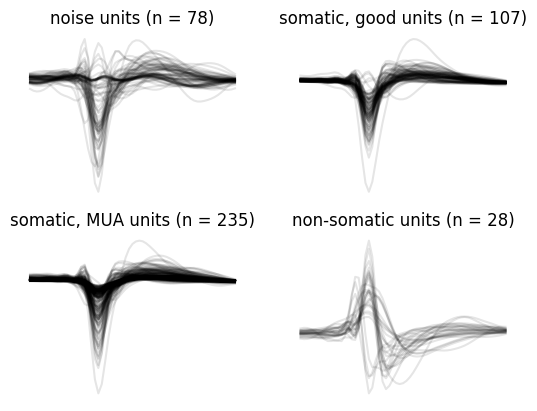

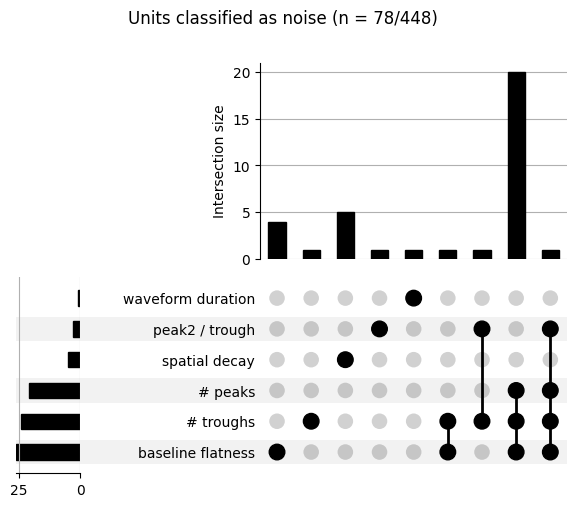

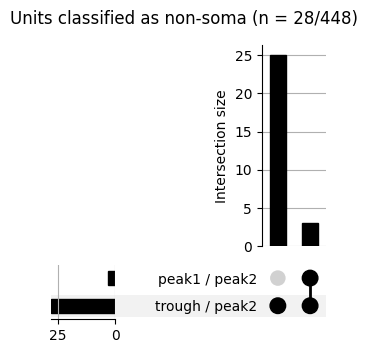

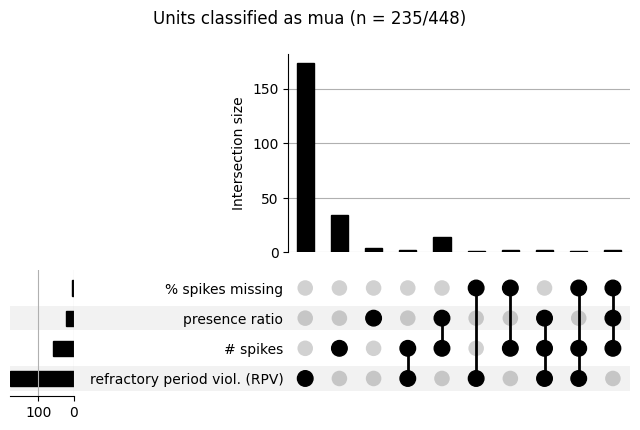

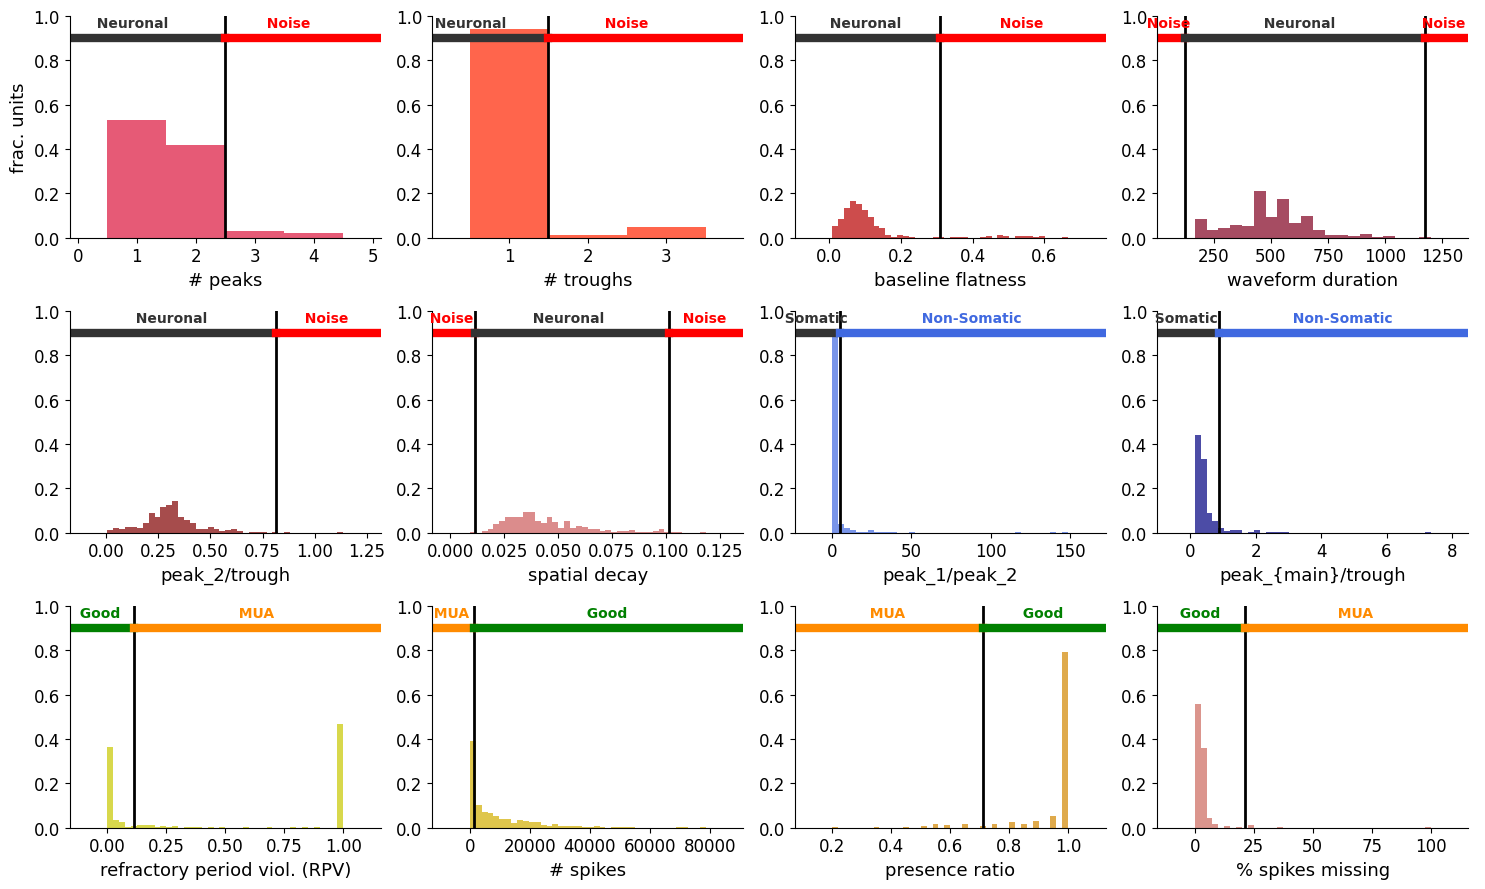


Saving results...
📁 Saving TSV files to Kilosort directory: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day08\neuralData\catgt_20251110_m978528_obs1_g0\20251110_m978528_obs1_g0_imec0\Kilosort4_probe0\sorter_output
All expected metrics were successfully saved.



File: 20251110_m978528_obs1_g0_imec1





estimate_sparsity (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\core\basesorting.py:380: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")


compute_waveforms (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

noise_level (workers: 16 processes):   0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1066: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:914: UserWarning: compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'
  warnings.warn("compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1658: UserWarning: The `sd_ratio` metric require the `spike_amplitudes` waveform extension. Use the `postprocessing.compute_spike_amplitudes()` functions. SD ratio metric will be set to NaN
  warnings.warn(
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packag

🚀 Starting BombCell quality metrics pipeline...
📁 Processing data from: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day08\neuralData\catgt_20251110_m978528_obs1_g0\20251110_m978528_obs1_g0_imec1\Kilosort4_probe1\sorter_output
Results will be saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day08\neuralData\catgt_20251110_m978528_obs1_g0\20251110_m978528_obs1_g0_imec1\Bombcell_imec1

Loading ephys data...
Loaded ephys data: 195 units, 1,844,204 spikes

⚙️ Computing quality metrics for 195 units...
   (Progress bar will appear below)


Computing bombcell quality metrics:   0%|          | 0/195 units


Saving GUI visualization data...
GUI visualization data saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day08\neuralData\catgt_20251110_m978528_obs1_g0\20251110_m978528_obs1_g0_imec1\Bombcell_imec1\for_GUI\gui_data.pkl
   Generated spatial decay fits: 188/195 units
   Generated amplitude fits: 188/195 units

🏷️ Classifying units (good/MUA/noise/non-soma)...

Generating summary plots...


c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\bombcell\plot_functions.py:434: RuntimeWarning: Could not create non-soma upset plot due to library compatibility: 'Index' object has no attribute 'levels'
  warnings.warn(f"Could not create {unit_type_str.lower()} upset plot due to library compatibility: {e}", RuntimeWarning)


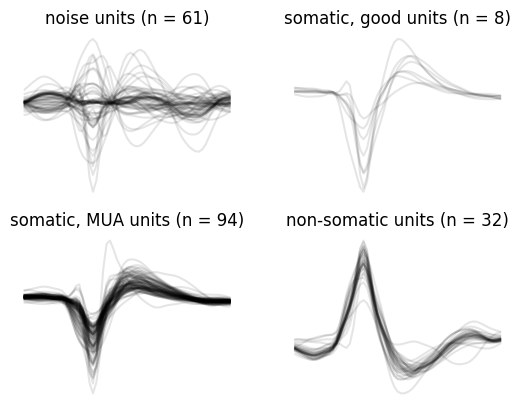

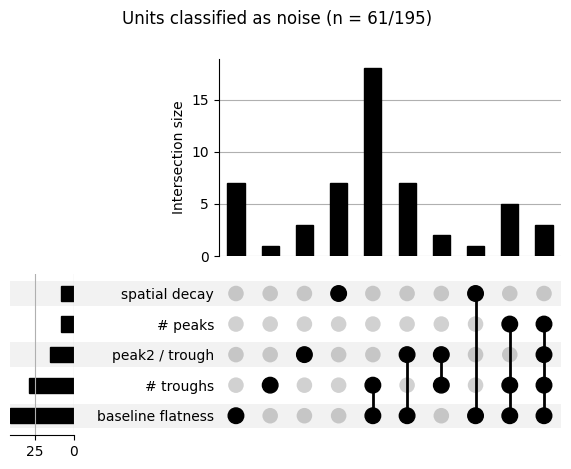

<Figure size 640x480 with 0 Axes>

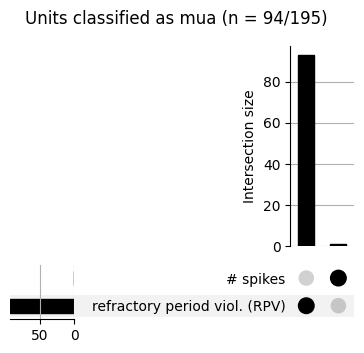

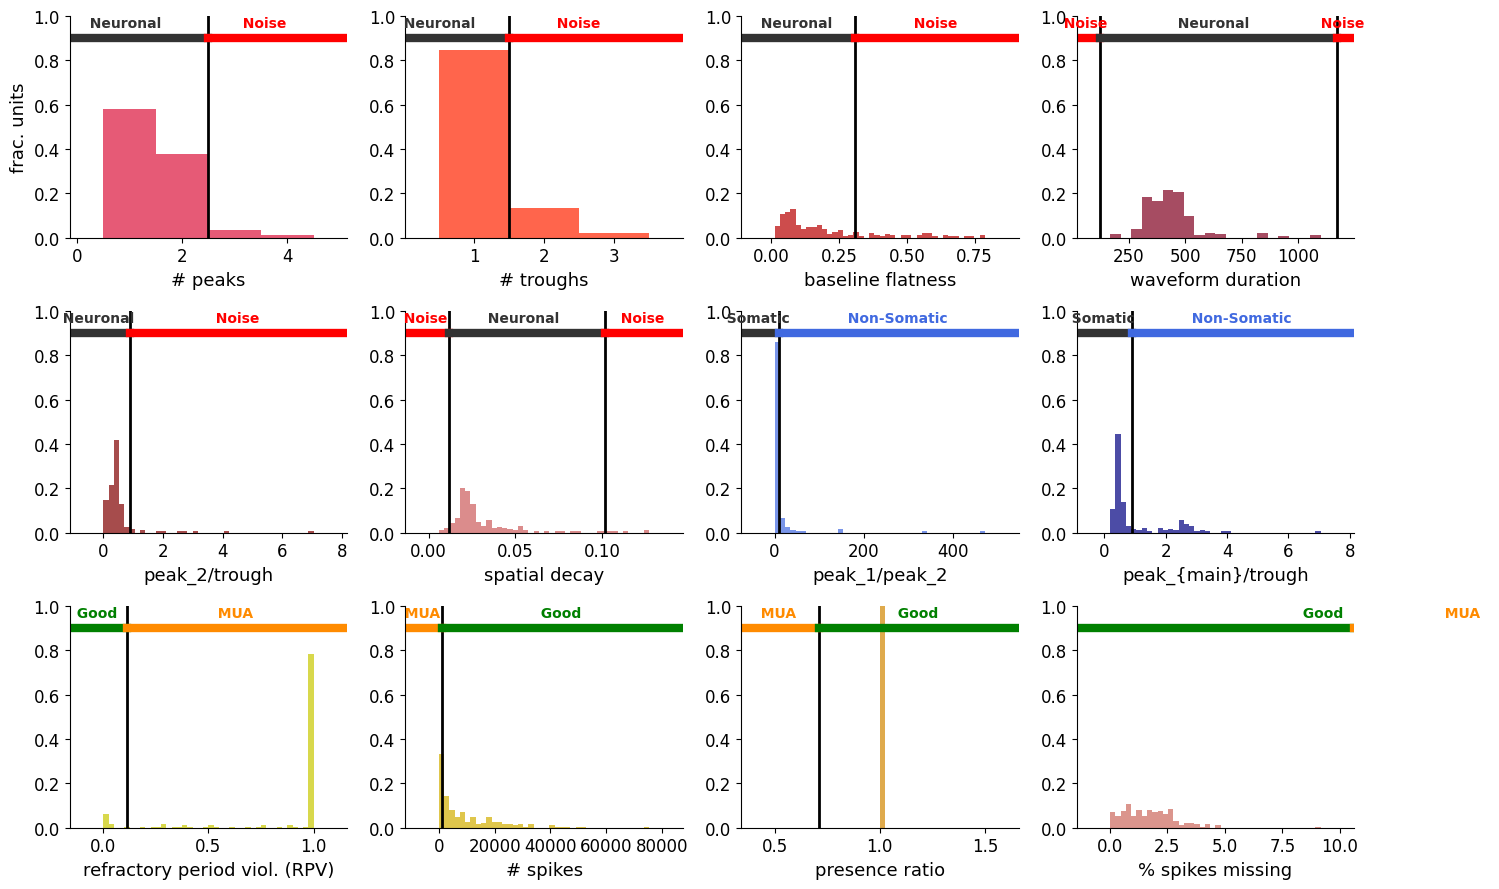


Saving results...
📁 Saving TSV files to Kilosort directory: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day08\neuralData\catgt_20251110_m978528_obs1_g0\20251110_m978528_obs1_g0_imec1\Kilosort4_probe1\sorter_output
All expected metrics were successfully saved.



File: 20251110_m978528_obs1_g0_imec2





estimate_sparsity (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\core\basesorting.py:380: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")


compute_waveforms (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

noise_level (workers: 16 processes):   0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1066: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:914: UserWarning: compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'
  warnings.warn("compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1658: UserWarning: The `sd_ratio` metric require the `spike_amplitudes` waveform extension. Use the `postprocessing.compute_spike_amplitudes()` functions. SD ratio metric will be set to NaN
  warnings.warn(
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packag

🚀 Starting BombCell quality metrics pipeline...
📁 Processing data from: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day08\neuralData\catgt_20251110_m978528_obs1_g0\20251110_m978528_obs1_g0_imec2\Kilosort4_probe2\sorter_output
Results will be saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day08\neuralData\catgt_20251110_m978528_obs1_g0\20251110_m978528_obs1_g0_imec2\Bombcell_imec2

Loading ephys data...
Loaded ephys data: 378 units, 6,453,963 spikes

⚙️ Computing quality metrics for 378 units...
   (Progress bar will appear below)


Computing bombcell quality metrics:   0%|          | 0/378 units


Saving GUI visualization data...
GUI visualization data saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day08\neuralData\catgt_20251110_m978528_obs1_g0\20251110_m978528_obs1_g0_imec2\Bombcell_imec2\for_GUI\gui_data.pkl
   Generated spatial decay fits: 361/378 units
   Generated amplitude fits: 361/378 units

🏷️ Classifying units (good/MUA/noise/non-soma)...

Generating summary plots...


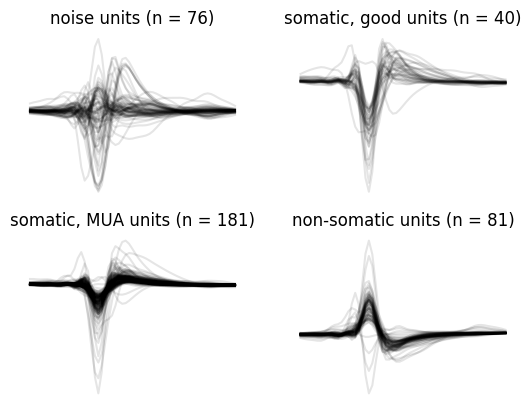

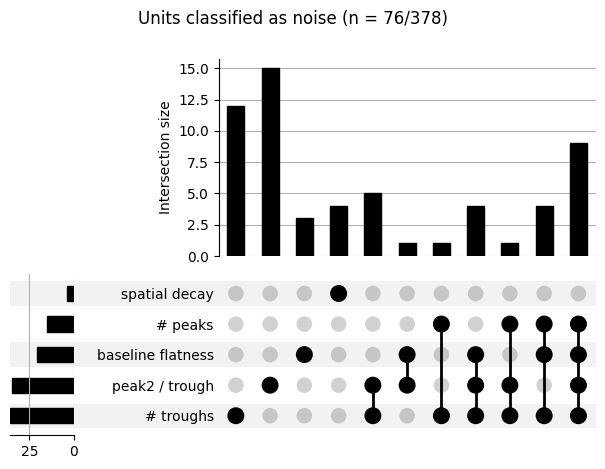

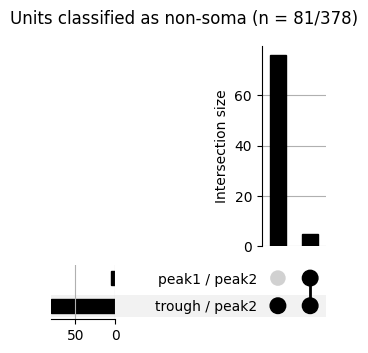

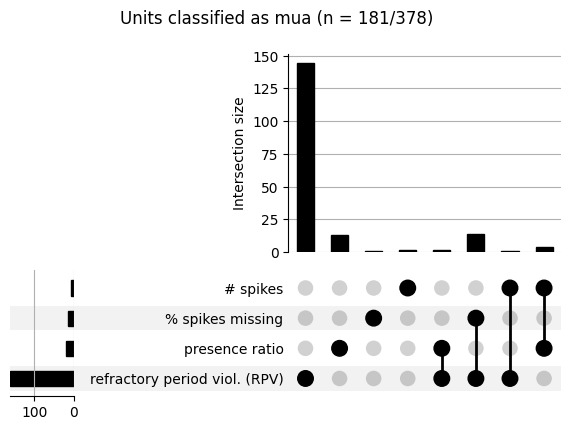

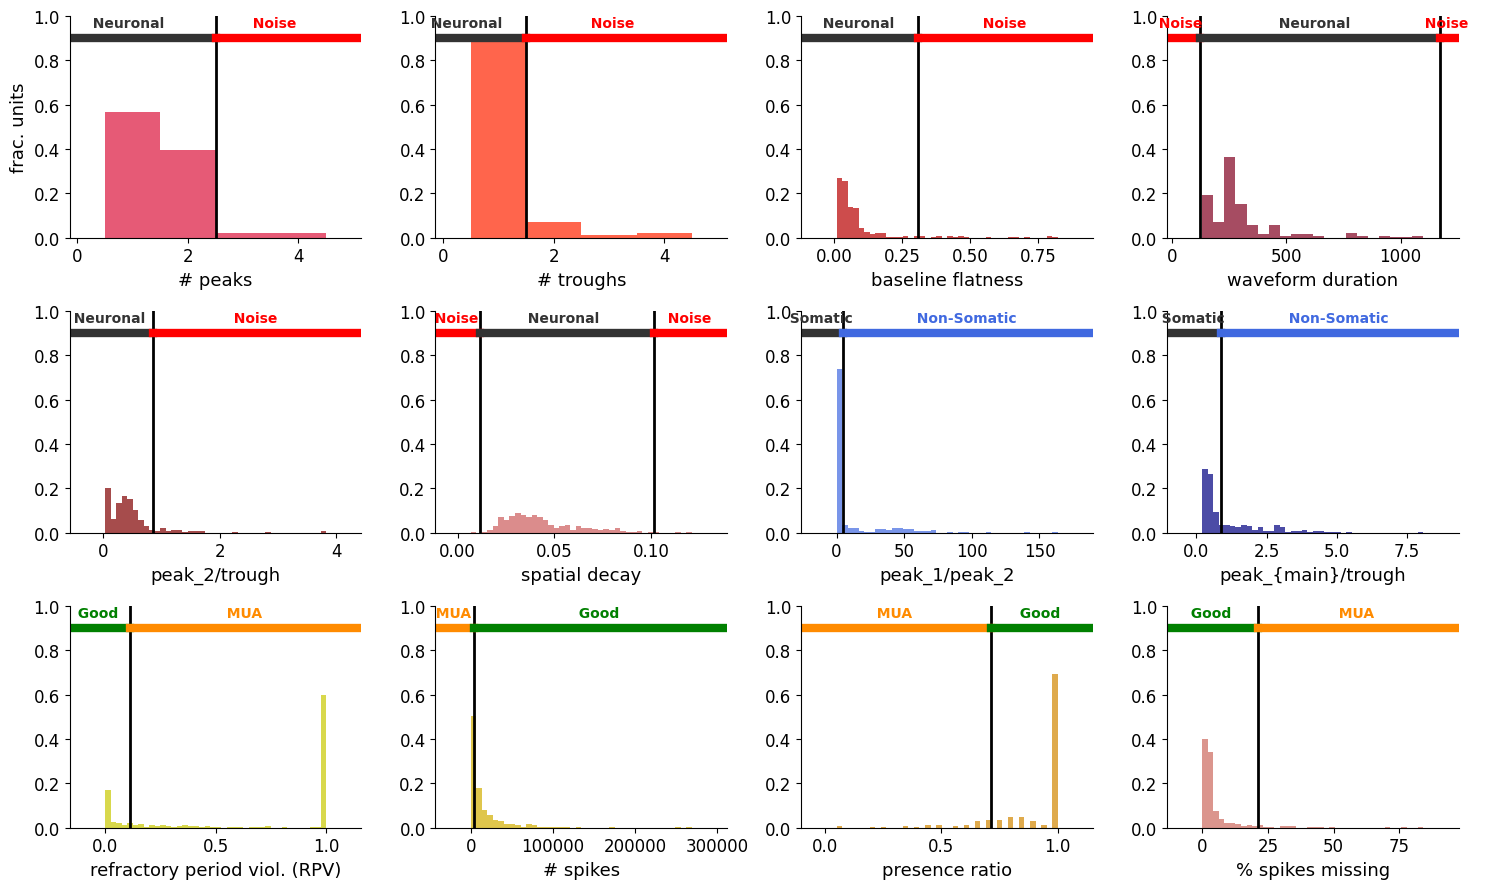


Saving results...
📁 Saving TSV files to Kilosort directory: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day08\neuralData\catgt_20251110_m978528_obs1_g0\20251110_m978528_obs1_g0_imec2\Kilosort4_probe2\sorter_output
All expected metrics were successfully saved.



File: 20251110_m978528_obs2_g0_imec0





estimate_sparsity (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\core\basesorting.py:380: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")


compute_waveforms (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

noise_level (workers: 16 processes):   0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1066: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:914: UserWarning: compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'
  warnings.warn("compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1658: UserWarning: The `sd_ratio` metric require the `spike_amplitudes` waveform extension. Use the `postprocessing.compute_spike_amplitudes()` functions. SD ratio metric will be set to NaN
  warnings.warn(
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packag

🚀 Starting BombCell quality metrics pipeline...
📁 Processing data from: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day10\neuralData\catgt_20251110_m978528_obs2_g0\20251110_m978528_obs2_g0_imec0\Kilosort4_probe0\sorter_output
Results will be saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day10\neuralData\catgt_20251110_m978528_obs2_g0\20251110_m978528_obs2_g0_imec0\Bombcell_imec0

Loading ephys data...
Loaded ephys data: 348 units, 3,140,712 spikes

⚙️ Computing quality metrics for 348 units...
   (Progress bar will appear below)


Computing bombcell quality metrics:   0%|          | 0/348 units


Saving GUI visualization data...
GUI visualization data saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day10\neuralData\catgt_20251110_m978528_obs2_g0\20251110_m978528_obs2_g0_imec0\Bombcell_imec0\for_GUI\gui_data.pkl
   Generated spatial decay fits: 313/348 units
   Generated amplitude fits: 313/348 units

🏷️ Classifying units (good/MUA/noise/non-soma)...

Generating summary plots...


c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\bombcell\plot_functions.py:434: RuntimeWarning: Could not create non-soma upset plot due to library compatibility: 'Index' object has no attribute 'levels'
  warnings.warn(f"Could not create {unit_type_str.lower()} upset plot due to library compatibility: {e}", RuntimeWarning)


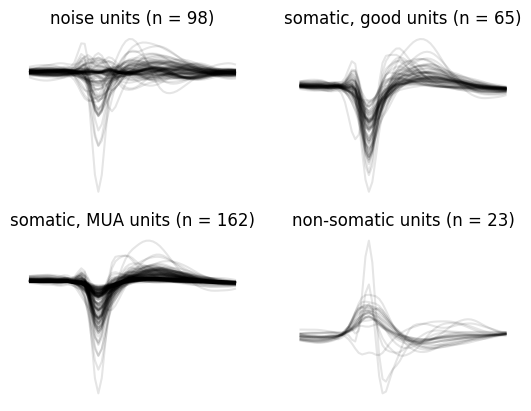

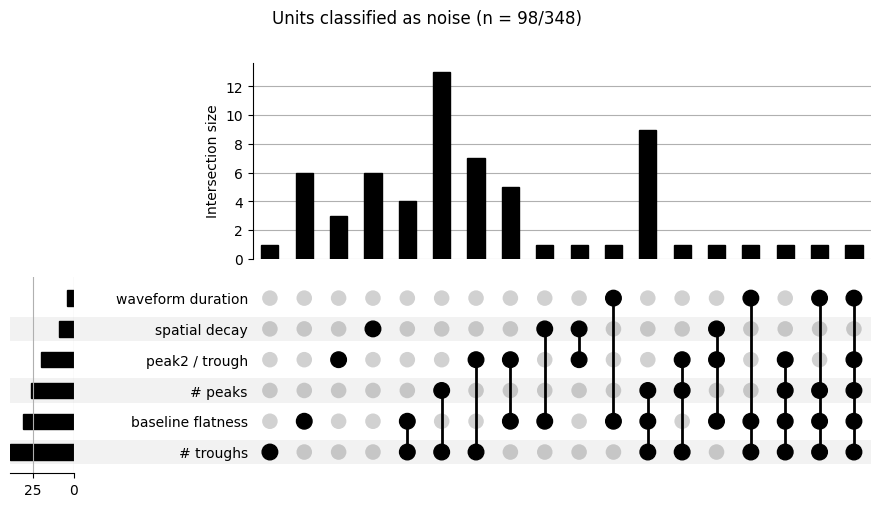

<Figure size 640x480 with 0 Axes>

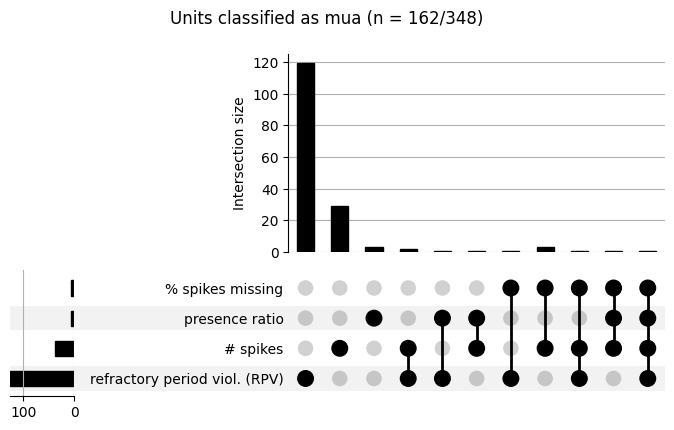

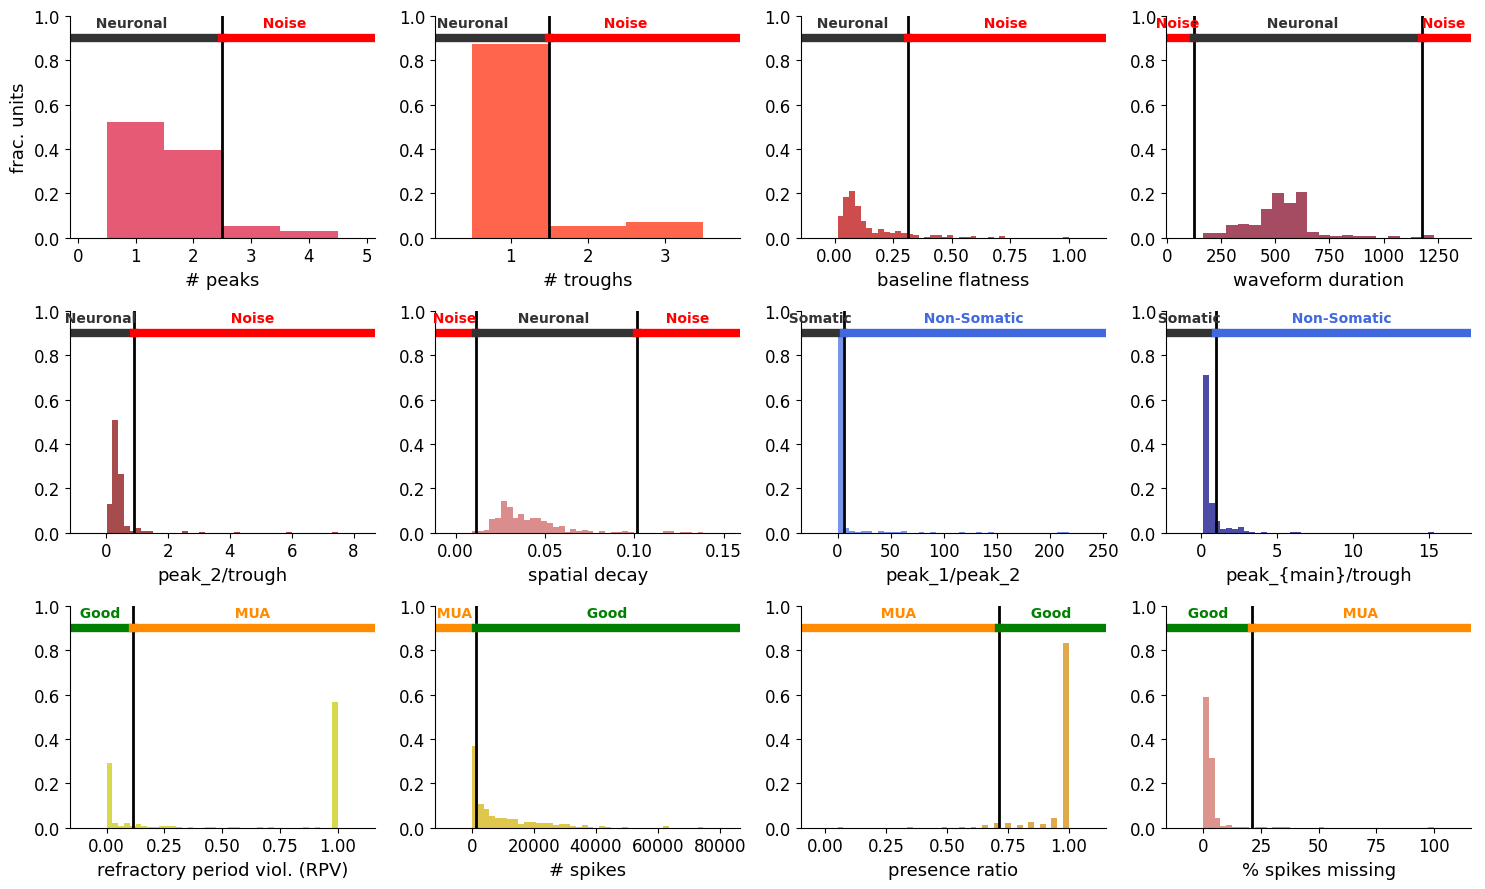


Saving results...
📁 Saving TSV files to Kilosort directory: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day10\neuralData\catgt_20251110_m978528_obs2_g0\20251110_m978528_obs2_g0_imec0\Kilosort4_probe0\sorter_output
All expected metrics were successfully saved.



File: 20251110_m978528_obs2_g0_imec1





estimate_sparsity (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\core\basesorting.py:380: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")


compute_waveforms (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

noise_level (workers: 16 processes):   0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1066: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:914: UserWarning: compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'
  warnings.warn("compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1658: UserWarning: The `sd_ratio` metric require the `spike_amplitudes` waveform extension. Use the `postprocessing.compute_spike_amplitudes()` functions. SD ratio metric will be set to NaN
  warnings.warn(
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packag

🚀 Starting BombCell quality metrics pipeline...
📁 Processing data from: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day10\neuralData\catgt_20251110_m978528_obs2_g0\20251110_m978528_obs2_g0_imec1\Kilosort4_probe1\sorter_output
Results will be saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day10\neuralData\catgt_20251110_m978528_obs2_g0\20251110_m978528_obs2_g0_imec1\Bombcell_imec1

Loading ephys data...
Loaded ephys data: 430 units, 4,431,196 spikes

⚙️ Computing quality metrics for 430 units...
   (Progress bar will appear below)


Computing bombcell quality metrics:   0%|          | 0/430 units


Saving GUI visualization data...
GUI visualization data saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day10\neuralData\catgt_20251110_m978528_obs2_g0\20251110_m978528_obs2_g0_imec1\Bombcell_imec1\for_GUI\gui_data.pkl
   Generated spatial decay fits: 414/430 units
   Generated amplitude fits: 414/430 units

🏷️ Classifying units (good/MUA/noise/non-soma)...

Generating summary plots...


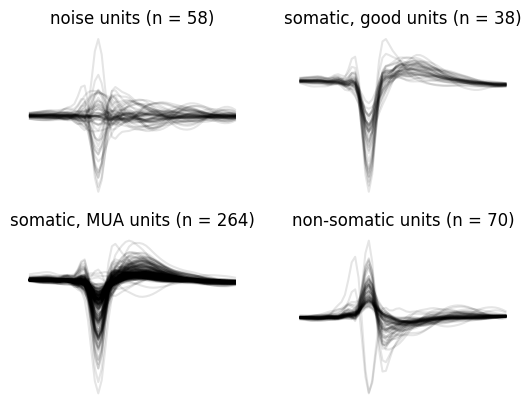

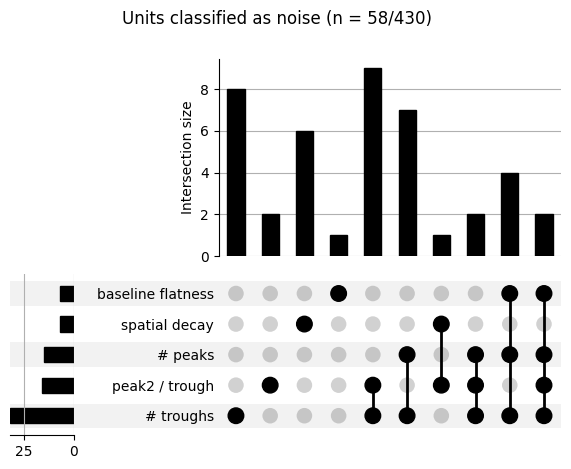

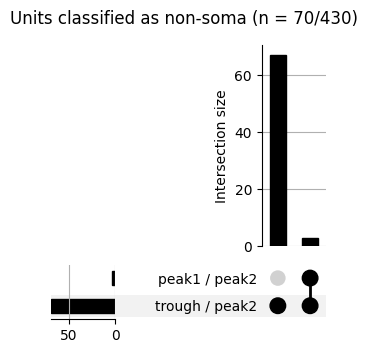

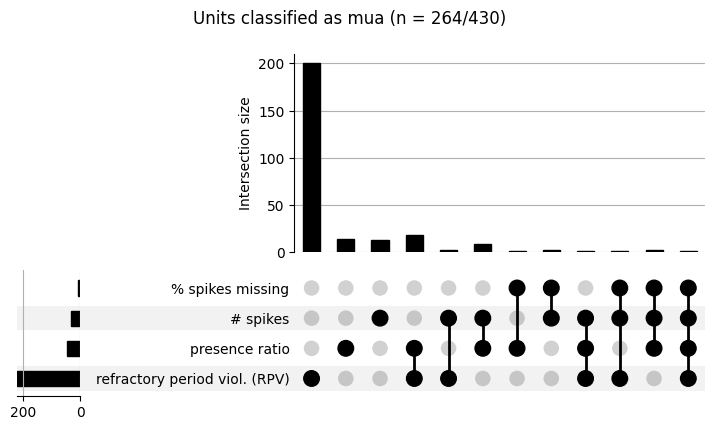

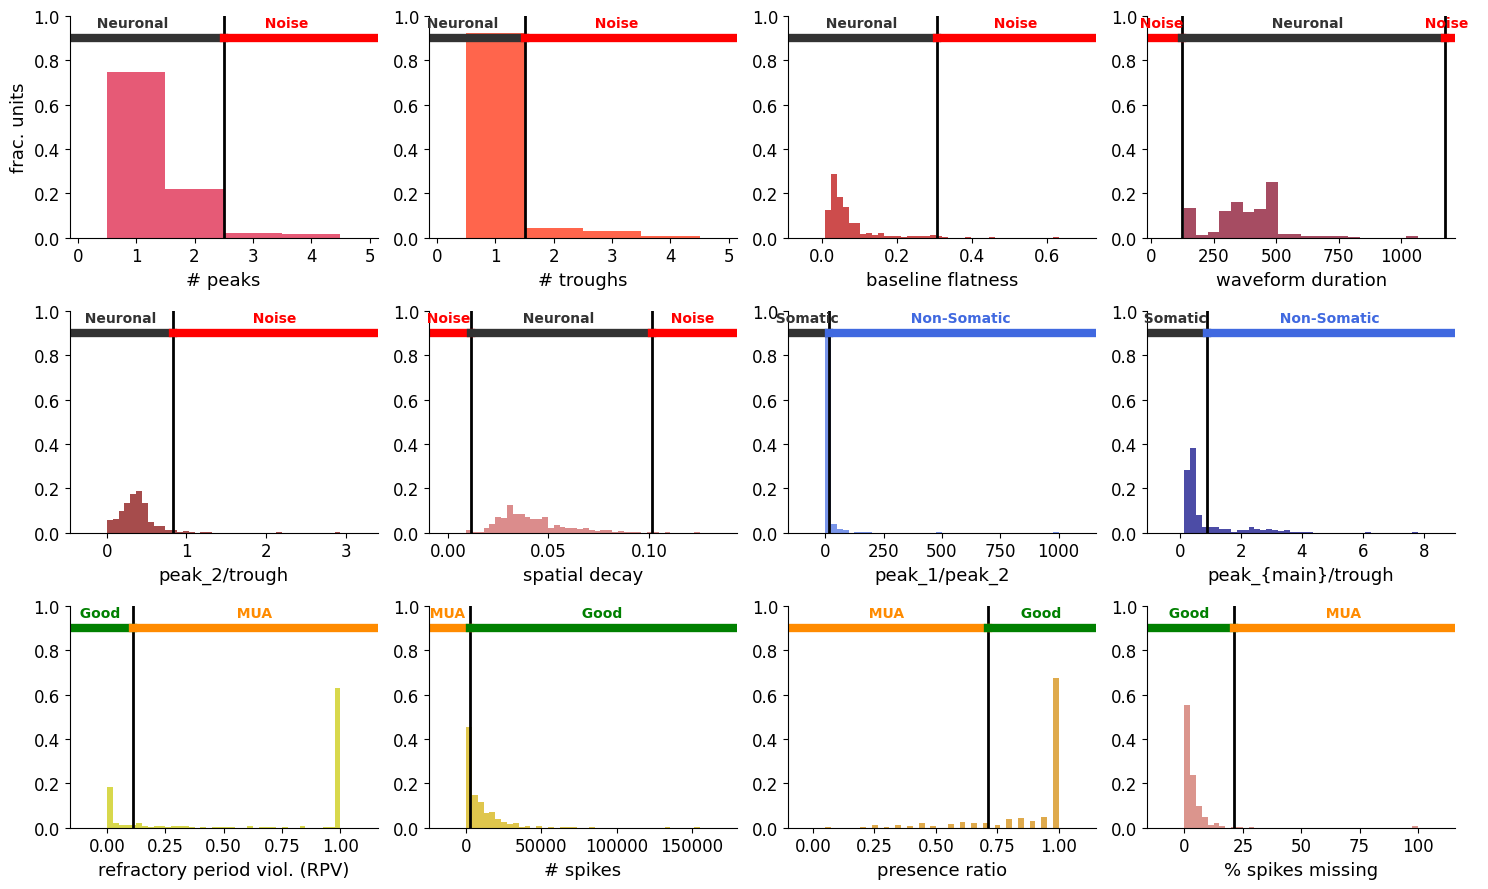


Saving results...
📁 Saving TSV files to Kilosort directory: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day10\neuralData\catgt_20251110_m978528_obs2_g0\20251110_m978528_obs2_g0_imec1\Kilosort4_probe1\sorter_output
All expected metrics were successfully saved.



File: 20251110_m978528_obs2_g0_imec2





estimate_sparsity (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\core\basesorting.py:380: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")


compute_waveforms (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

noise_level (workers: 16 processes):   0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1066: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:914: UserWarning: compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'
  warnings.warn("compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1658: UserWarning: The `sd_ratio` metric require the `spike_amplitudes` waveform extension. Use the `postprocessing.compute_spike_amplitudes()` functions. SD ratio metric will be set to NaN
  warnings.warn(
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packag

🚀 Starting BombCell quality metrics pipeline...
📁 Processing data from: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day10\neuralData\catgt_20251110_m978528_obs2_g0\20251110_m978528_obs2_g0_imec2\Kilosort4_probe2\sorter_output
Results will be saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day10\neuralData\catgt_20251110_m978528_obs2_g0\20251110_m978528_obs2_g0_imec2\Bombcell_imec2

Loading ephys data...
Loaded ephys data: 496 units, 6,750,444 spikes

⚙️ Computing quality metrics for 496 units...
   (Progress bar will appear below)


Computing bombcell quality metrics:   0%|          | 0/496 units


Saving GUI visualization data...
GUI visualization data saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day10\neuralData\catgt_20251110_m978528_obs2_g0\20251110_m978528_obs2_g0_imec2\Bombcell_imec2\for_GUI\gui_data.pkl
   Generated spatial decay fits: 488/496 units
   Generated amplitude fits: 488/496 units

🏷️ Classifying units (good/MUA/noise/non-soma)...

Generating summary plots...


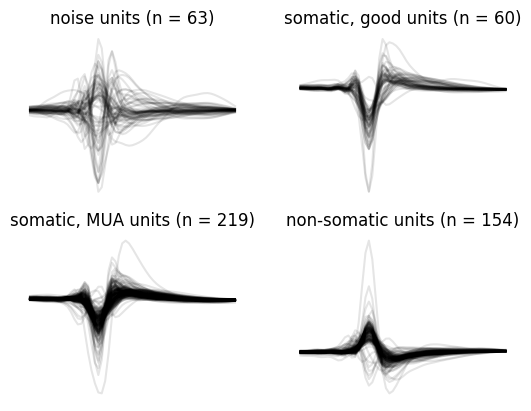

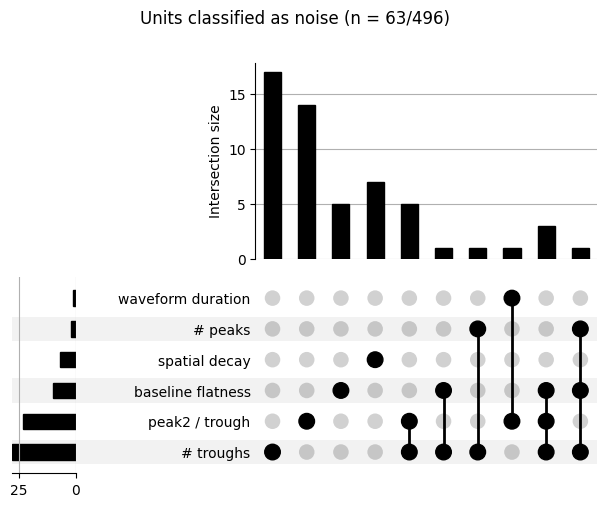

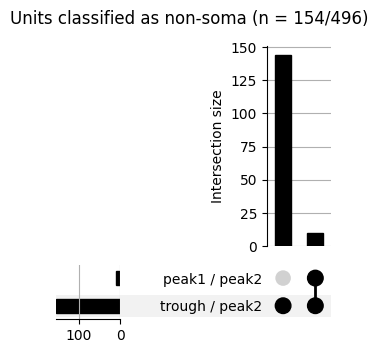

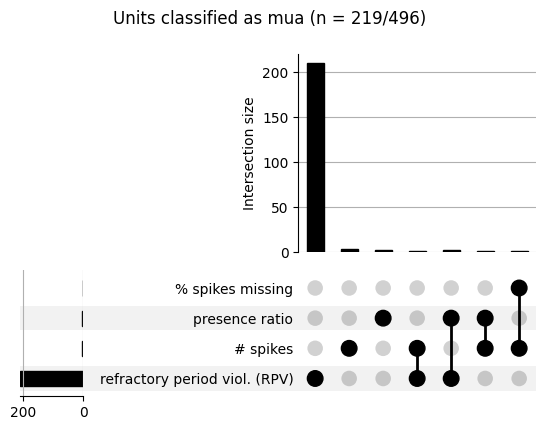

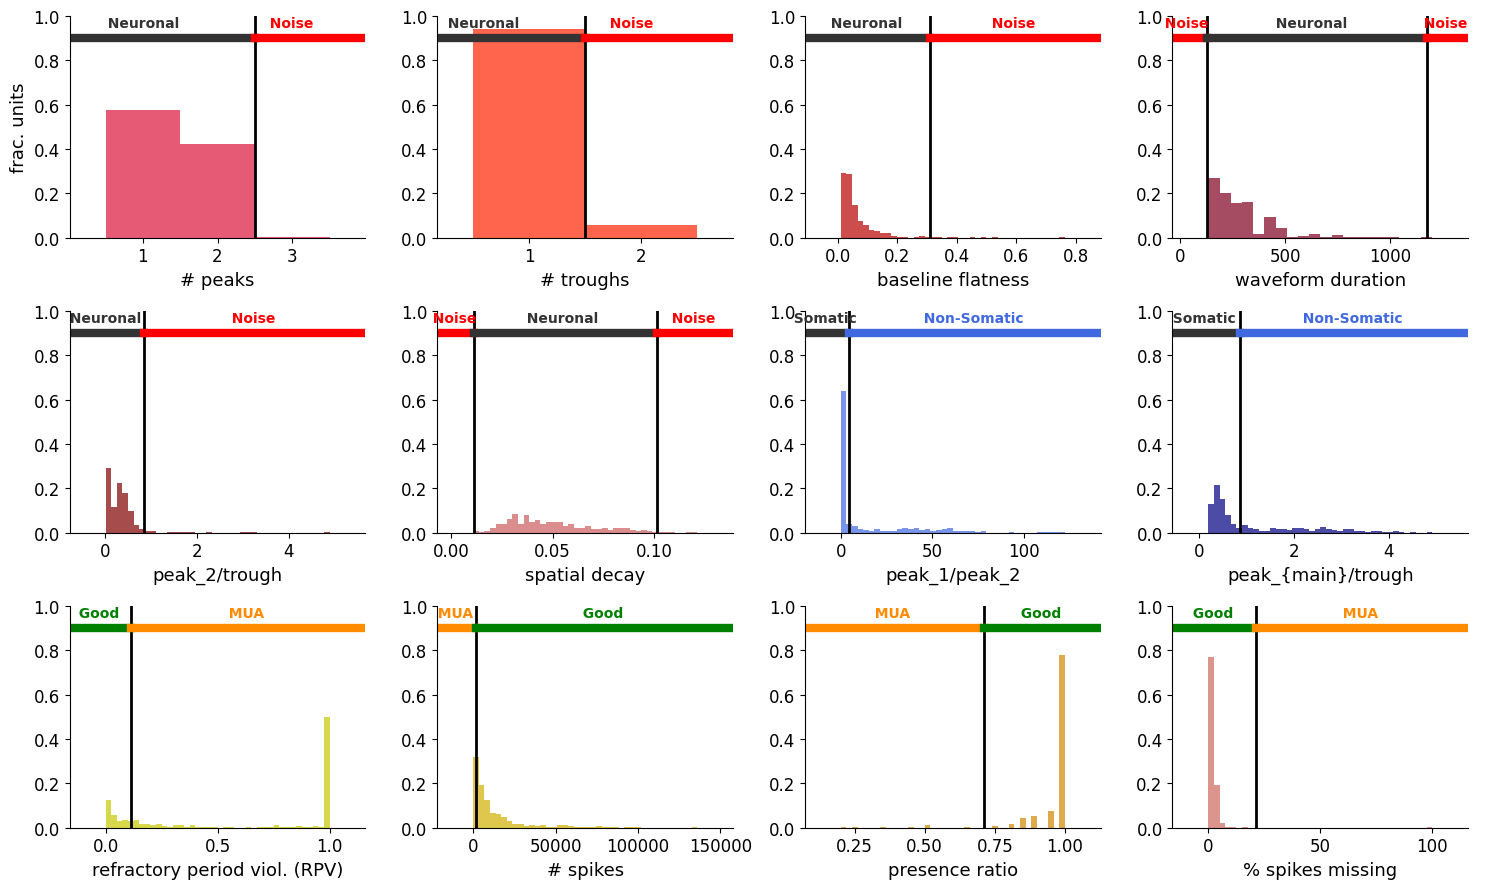


Saving results...
📁 Saving TSV files to Kilosort directory: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day10\neuralData\catgt_20251110_m978528_obs2_g0\20251110_m978528_obs2_g0_imec2\Kilosort4_probe2\sorter_output
All expected metrics were successfully saved.



File: 20251110_m978528_obs3_g0_imec0





estimate_sparsity (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\core\basesorting.py:380: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")


compute_waveforms (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

noise_level (workers: 16 processes):   0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1066: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:914: UserWarning: compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'
  warnings.warn("compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1658: UserWarning: The `sd_ratio` metric require the `spike_amplitudes` waveform extension. Use the `postprocessing.compute_spike_amplitudes()` functions. SD ratio metric will be set to NaN
  warnings.warn(
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packag

🚀 Starting BombCell quality metrics pipeline...
📁 Processing data from: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day12\neuralData\catgt_20251110_m978528_obs3_g0\20251110_m978528_obs3_g0_imec0\Kilosort4_probe0\sorter_output
Results will be saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day12\neuralData\catgt_20251110_m978528_obs3_g0\20251110_m978528_obs3_g0_imec0\Bombcell_imec0

Loading ephys data...
Loaded ephys data: 390 units, 2,597,783 spikes

⚙️ Computing quality metrics for 390 units...
   (Progress bar will appear below)


Computing bombcell quality metrics:   0%|          | 0/390 units


Saving GUI visualization data...
GUI visualization data saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day12\neuralData\catgt_20251110_m978528_obs3_g0\20251110_m978528_obs3_g0_imec0\Bombcell_imec0\for_GUI\gui_data.pkl
   Generated spatial decay fits: 352/390 units
   Generated amplitude fits: 351/390 units

🏷️ Classifying units (good/MUA/noise/non-soma)...

Generating summary plots...


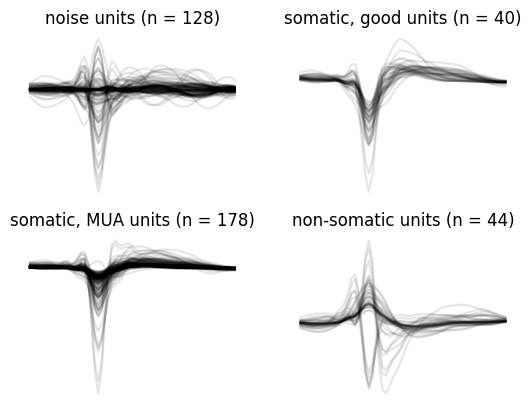

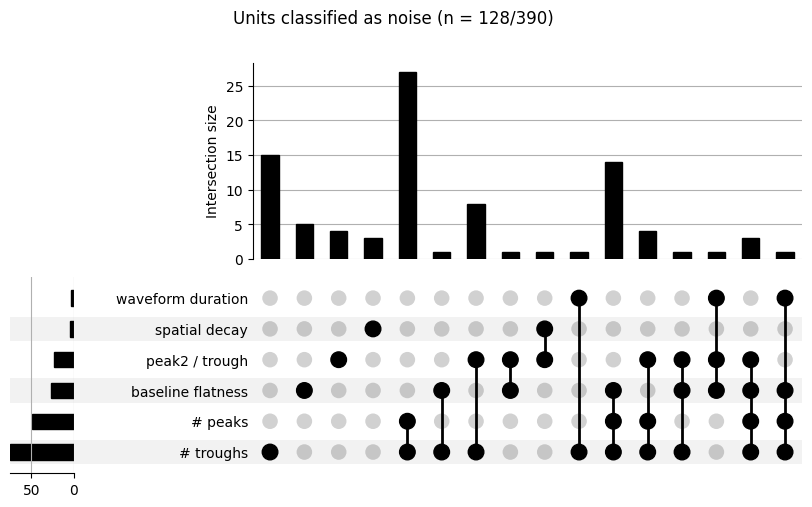

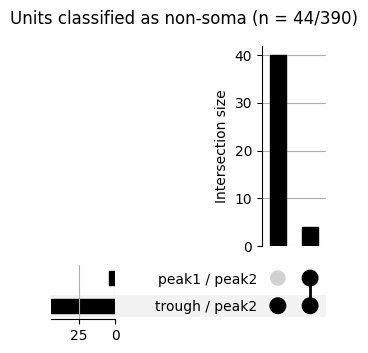

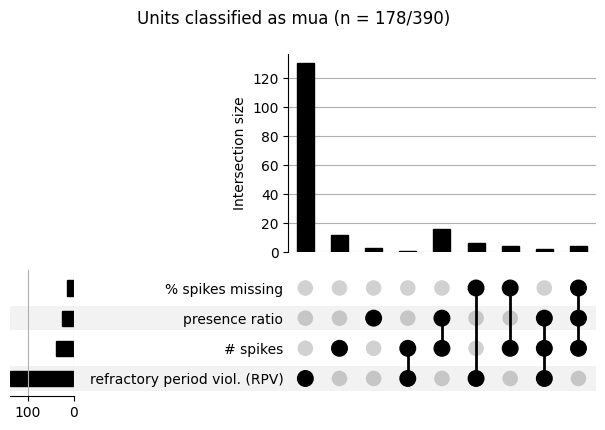

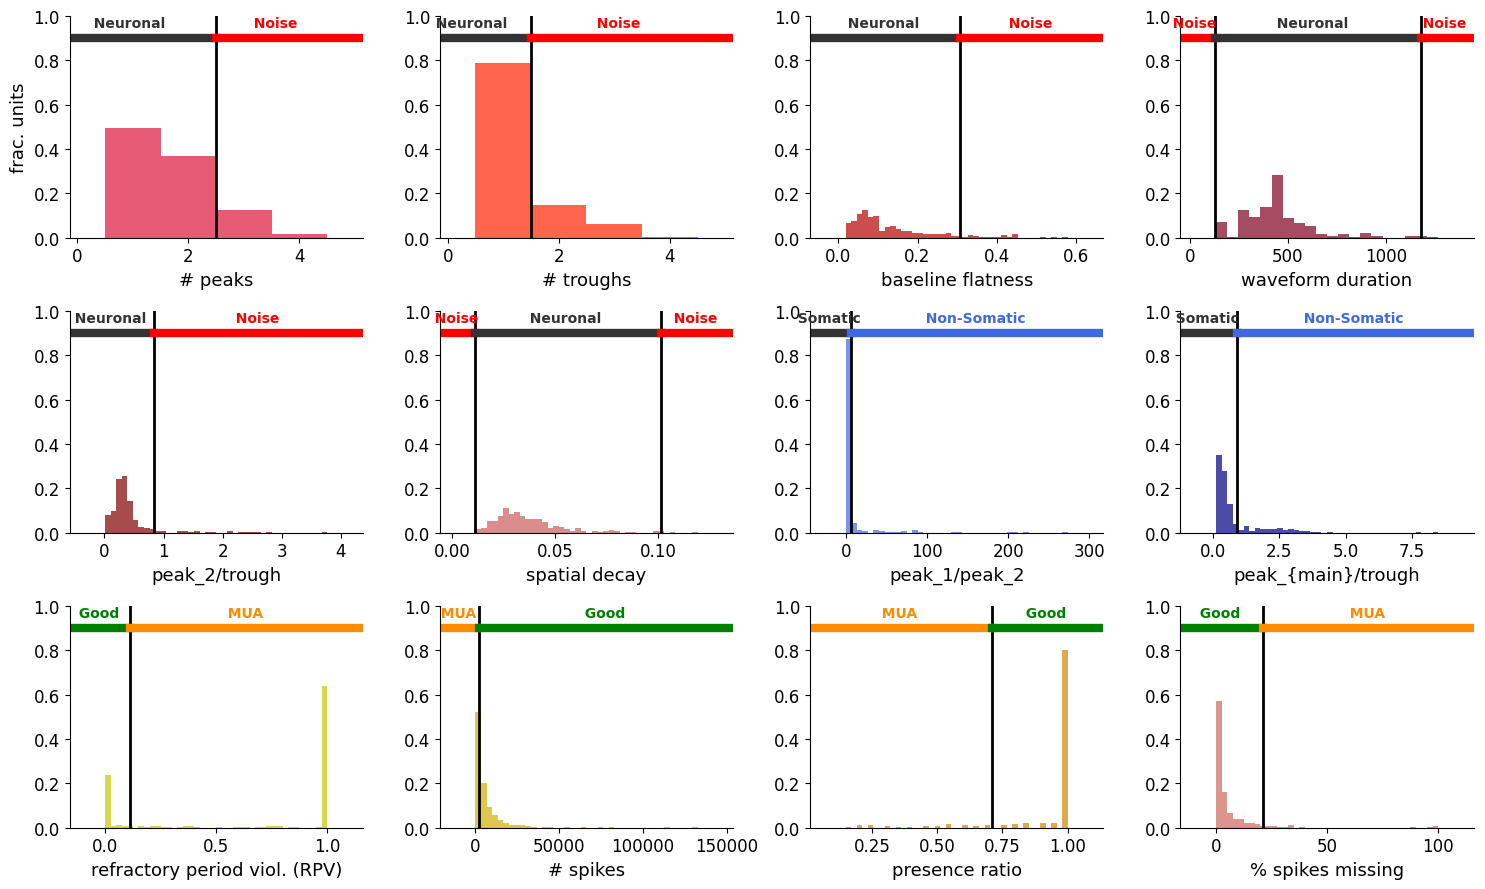


Saving results...
📁 Saving TSV files to Kilosort directory: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day12\neuralData\catgt_20251110_m978528_obs3_g0\20251110_m978528_obs3_g0_imec0\Kilosort4_probe0\sorter_output
All expected metrics were successfully saved.



File: 20251110_m978528_obs3_g0_imec1





estimate_sparsity (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\core\basesorting.py:380: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")


compute_waveforms (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

noise_level (workers: 16 processes):   0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1066: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:914: UserWarning: compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'
  warnings.warn("compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1658: UserWarning: The `sd_ratio` metric require the `spike_amplitudes` waveform extension. Use the `postprocessing.compute_spike_amplitudes()` functions. SD ratio metric will be set to NaN
  warnings.warn(
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packag

🚀 Starting BombCell quality metrics pipeline...
📁 Processing data from: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day12\neuralData\catgt_20251110_m978528_obs3_g0\20251110_m978528_obs3_g0_imec1\Kilosort4_probe1\sorter_output
Results will be saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day12\neuralData\catgt_20251110_m978528_obs3_g0\20251110_m978528_obs3_g0_imec1\Bombcell_imec1

Loading ephys data...
Loaded ephys data: 268 units, 2,473,342 spikes

⚙️ Computing quality metrics for 268 units...
   (Progress bar will appear below)


Computing bombcell quality metrics:   0%|          | 0/268 units


Saving GUI visualization data...
GUI visualization data saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day12\neuralData\catgt_20251110_m978528_obs3_g0\20251110_m978528_obs3_g0_imec1\Bombcell_imec1\for_GUI\gui_data.pkl
   Generated spatial decay fits: 260/268 units
   Generated amplitude fits: 260/268 units

🏷️ Classifying units (good/MUA/noise/non-soma)...

Generating summary plots...


c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\bombcell\plot_functions.py:434: RuntimeWarning: Could not create non-soma upset plot due to library compatibility: 'Index' object has no attribute 'levels'
  warnings.warn(f"Could not create {unit_type_str.lower()} upset plot due to library compatibility: {e}", RuntimeWarning)


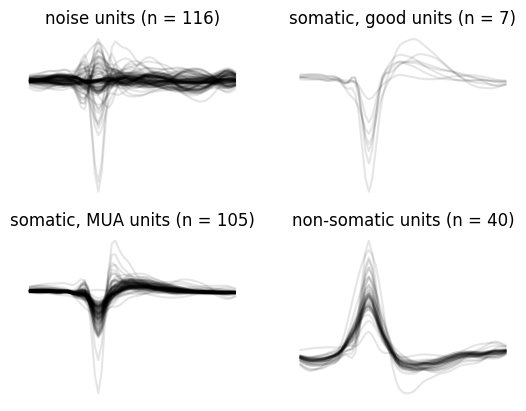

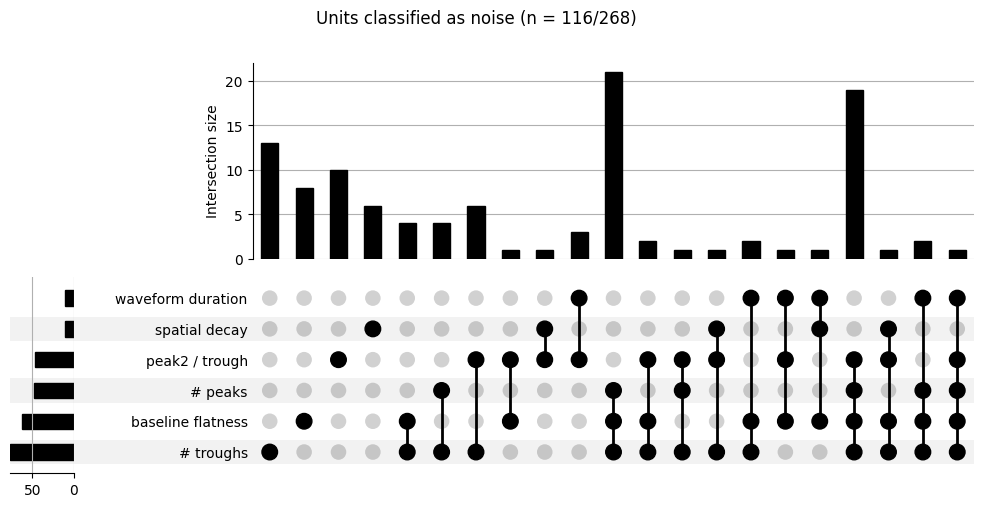

<Figure size 640x480 with 0 Axes>

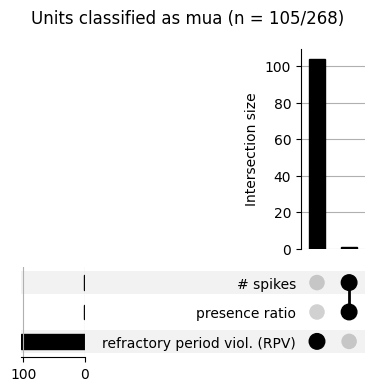

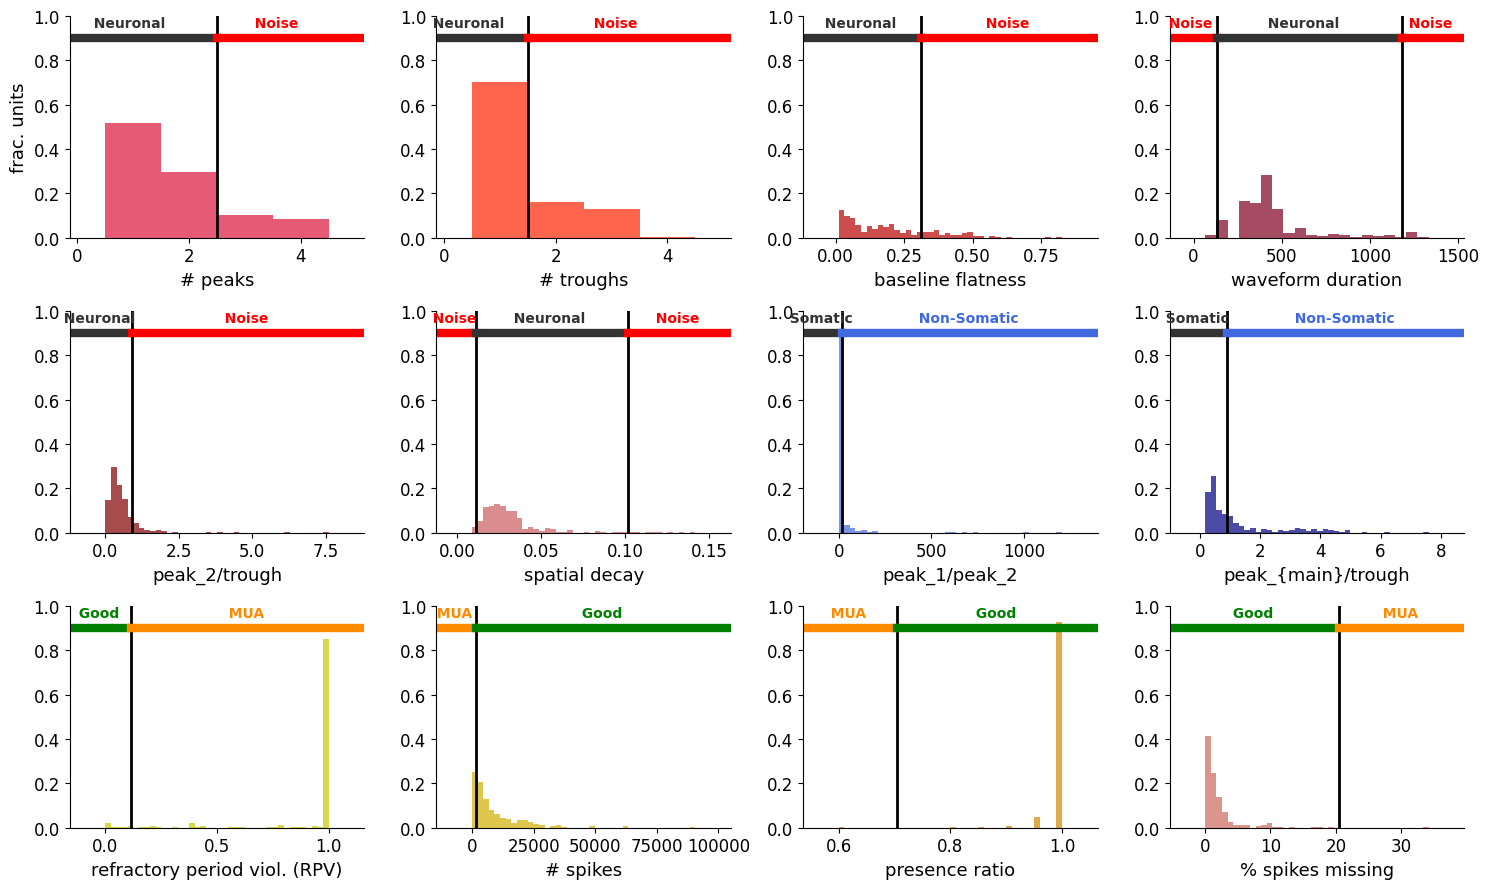


Saving results...
📁 Saving TSV files to Kilosort directory: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day12\neuralData\catgt_20251110_m978528_obs3_g0\20251110_m978528_obs3_g0_imec1\Kilosort4_probe1\sorter_output
All expected metrics were successfully saved.



File: 20251110_m978528_obs3_g0_imec2





estimate_sparsity (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\core\basesorting.py:380: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")


compute_waveforms (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

noise_level (workers: 16 processes):   0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1066: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:914: UserWarning: compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'
  warnings.warn("compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1658: UserWarning: The `sd_ratio` metric require the `spike_amplitudes` waveform extension. Use the `postprocessing.compute_spike_amplitudes()` functions. SD ratio metric will be set to NaN
  warnings.warn(
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packag

🚀 Starting BombCell quality metrics pipeline...
📁 Processing data from: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day12\neuralData\catgt_20251110_m978528_obs3_g0\20251110_m978528_obs3_g0_imec2\Kilosort4_probe2\sorter_output
Results will be saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day12\neuralData\catgt_20251110_m978528_obs3_g0\20251110_m978528_obs3_g0_imec2\Bombcell_imec2

Loading ephys data...
Loaded ephys data: 634 units, 7,917,479 spikes

⚙️ Computing quality metrics for 634 units...
   (Progress bar will appear below)


Computing bombcell quality metrics:   0%|          | 0/634 units


Saving GUI visualization data...
GUI visualization data saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day12\neuralData\catgt_20251110_m978528_obs3_g0\20251110_m978528_obs3_g0_imec2\Bombcell_imec2\for_GUI\gui_data.pkl
   Generated spatial decay fits: 619/634 units
   Generated amplitude fits: 619/634 units

🏷️ Classifying units (good/MUA/noise/non-soma)...

Generating summary plots...


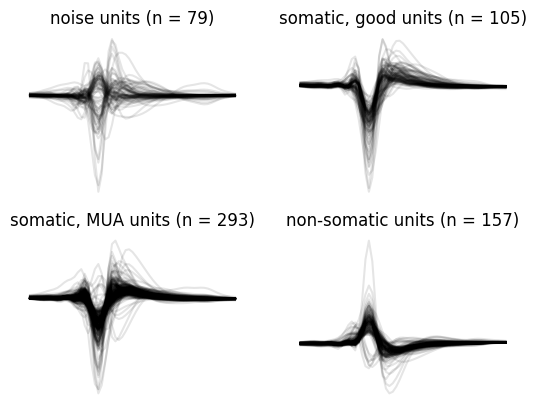

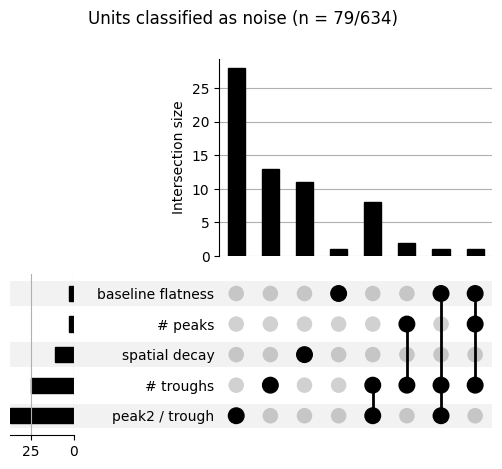

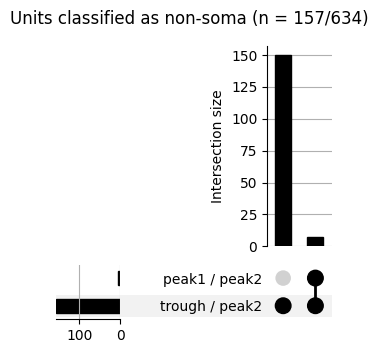

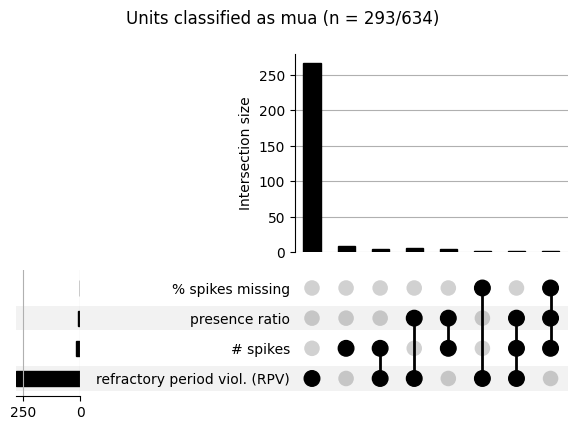

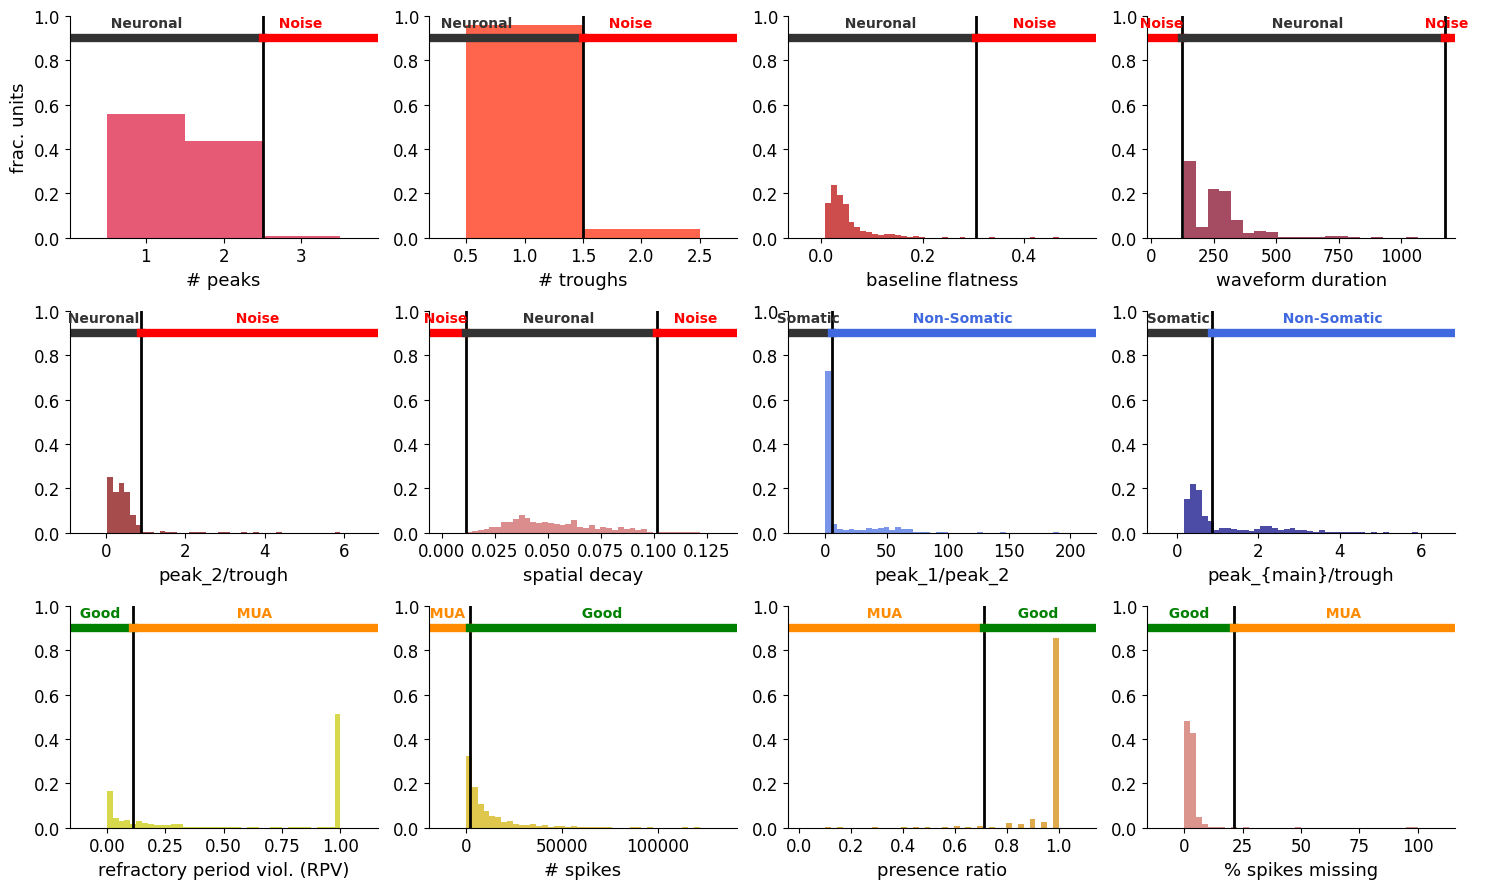


Saving results...
📁 Saving TSV files to Kilosort directory: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day12\neuralData\catgt_20251110_m978528_obs3_g0\20251110_m978528_obs3_g0_imec2\Kilosort4_probe2\sorter_output
All expected metrics were successfully saved.



File: 20251110_m978528_obs4_g0_imec0





estimate_sparsity (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\core\basesorting.py:380: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")


compute_waveforms (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

noise_level (workers: 16 processes):   0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1066: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:914: UserWarning: compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'
  warnings.warn("compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1658: UserWarning: The `sd_ratio` metric require the `spike_amplitudes` waveform extension. Use the `postprocessing.compute_spike_amplitudes()` functions. SD ratio metric will be set to NaN
  warnings.warn(
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packag

🚀 Starting BombCell quality metrics pipeline...
📁 Processing data from: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day22\neuralData\catgt_20251110_m978528_obs4_g0\20251110_m978528_obs4_g0_imec0\Kilosort4_probe0\sorter_output
Results will be saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day22\neuralData\catgt_20251110_m978528_obs4_g0\20251110_m978528_obs4_g0_imec0\Bombcell_imec0

Loading ephys data...
Loaded ephys data: 291 units, 3,872,116 spikes

⚙️ Computing quality metrics for 291 units...
   (Progress bar will appear below)


Computing bombcell quality metrics:   0%|          | 0/291 units


Saving GUI visualization data...
GUI visualization data saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day22\neuralData\catgt_20251110_m978528_obs4_g0\20251110_m978528_obs4_g0_imec0\Bombcell_imec0\for_GUI\gui_data.pkl
   Generated spatial decay fits: 255/291 units
   Generated amplitude fits: 255/291 units

🏷️ Classifying units (good/MUA/noise/non-soma)...

Generating summary plots...


c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\bombcell\plot_functions.py:434: RuntimeWarning: Could not create non-soma upset plot due to library compatibility: 'Index' object has no attribute 'levels'
  warnings.warn(f"Could not create {unit_type_str.lower()} upset plot due to library compatibility: {e}", RuntimeWarning)


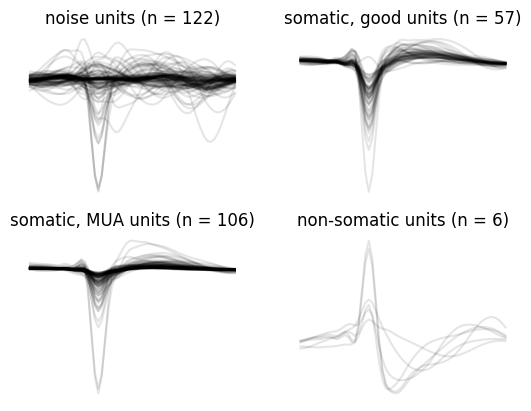

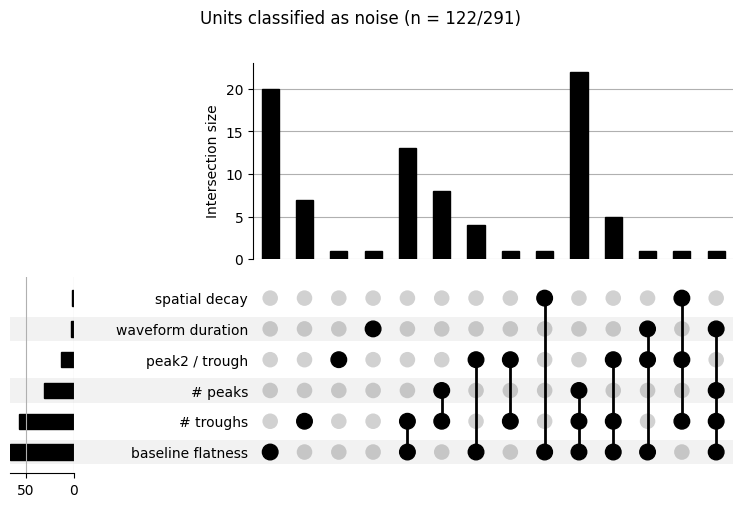

<Figure size 640x480 with 0 Axes>

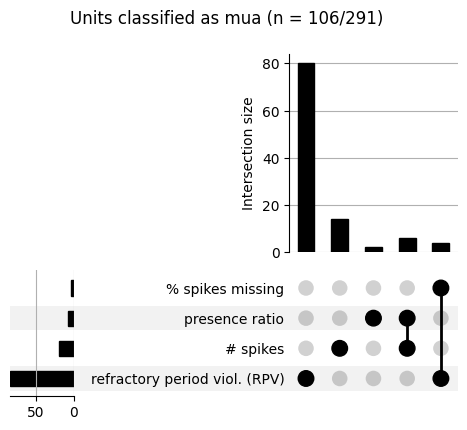

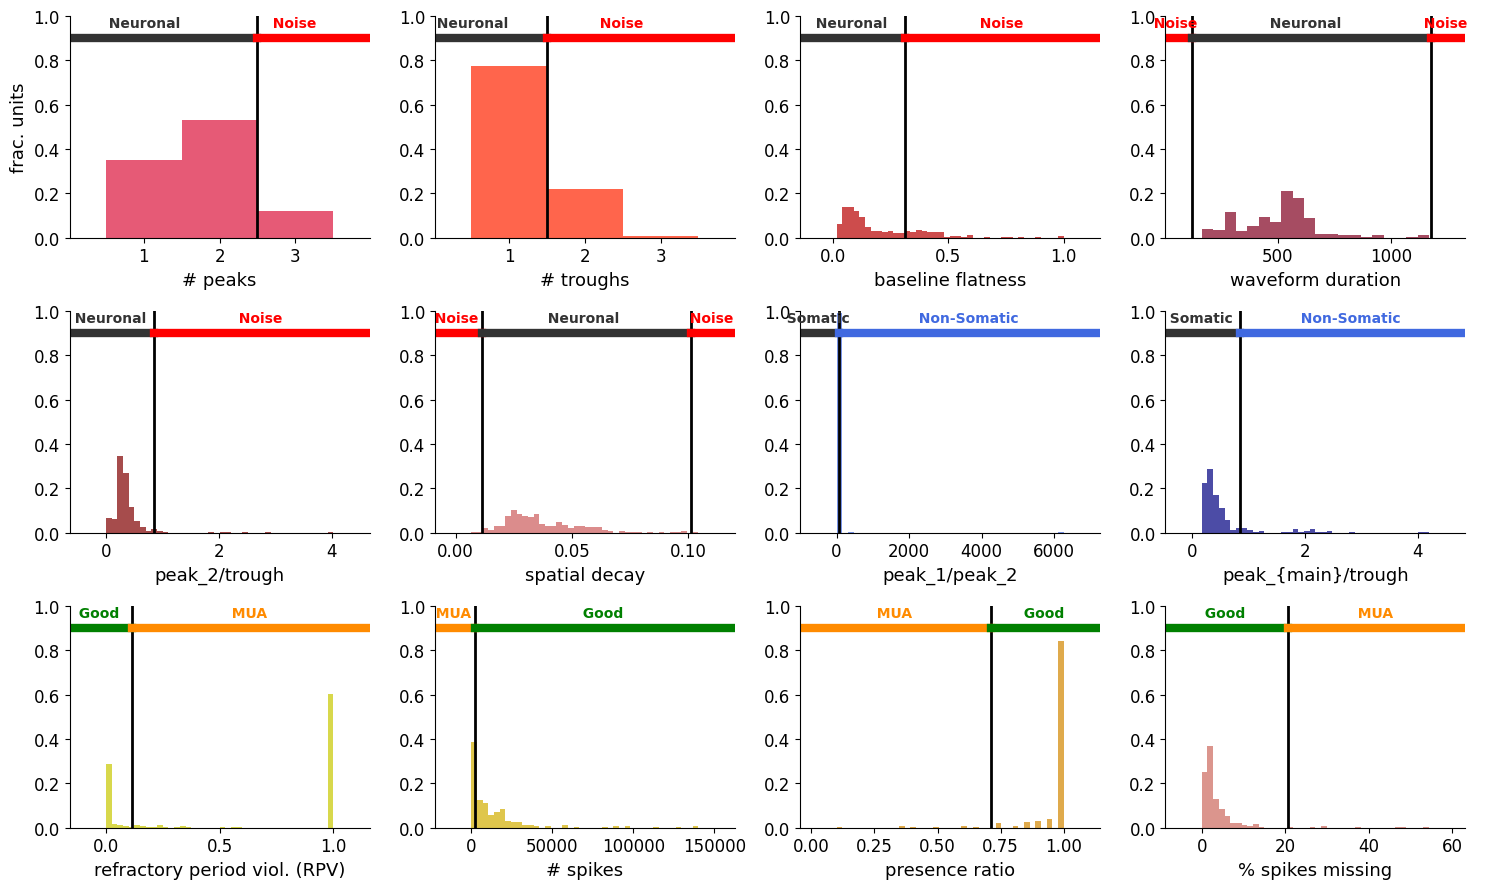


Saving results...
📁 Saving TSV files to Kilosort directory: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day22\neuralData\catgt_20251110_m978528_obs4_g0\20251110_m978528_obs4_g0_imec0\Kilosort4_probe0\sorter_output
All expected metrics were successfully saved.



File: 20251110_m978528_obs4_g0_imec1





estimate_sparsity (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\core\basesorting.py:380: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")


compute_waveforms (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

noise_level (workers: 16 processes):   0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1066: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:914: UserWarning: compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'
  warnings.warn("compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1658: UserWarning: The `sd_ratio` metric require the `spike_amplitudes` waveform extension. Use the `postprocessing.compute_spike_amplitudes()` functions. SD ratio metric will be set to NaN
  warnings.warn(
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packag

🚀 Starting BombCell quality metrics pipeline...
📁 Processing data from: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day22\neuralData\catgt_20251110_m978528_obs4_g0\20251110_m978528_obs4_g0_imec1\Kilosort4_probe1\sorter_output
Results will be saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day22\neuralData\catgt_20251110_m978528_obs4_g0\20251110_m978528_obs4_g0_imec1\Bombcell_imec1

Loading ephys data...
Loaded ephys data: 225 units, 2,495,367 spikes

⚙️ Computing quality metrics for 225 units...
   (Progress bar will appear below)


Computing bombcell quality metrics:   0%|          | 0/225 units


Saving GUI visualization data...
GUI visualization data saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day22\neuralData\catgt_20251110_m978528_obs4_g0\20251110_m978528_obs4_g0_imec1\Bombcell_imec1\for_GUI\gui_data.pkl
   Generated spatial decay fits: 214/225 units
   Generated amplitude fits: 214/225 units

🏷️ Classifying units (good/MUA/noise/non-soma)...

Generating summary plots...


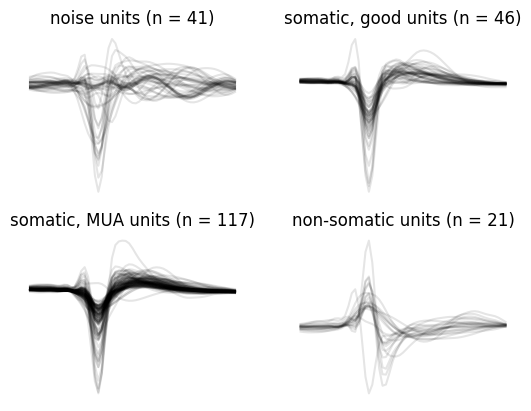

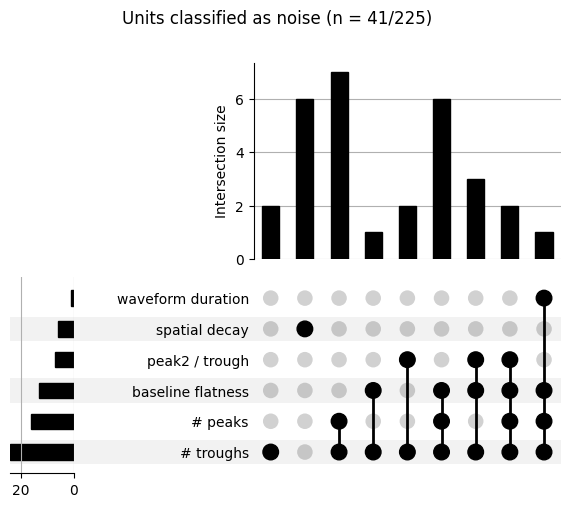

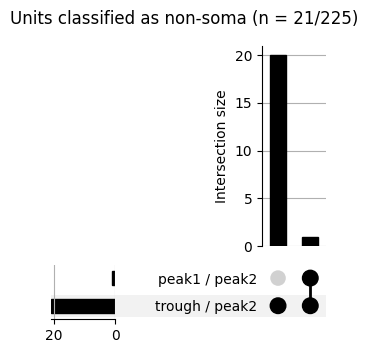

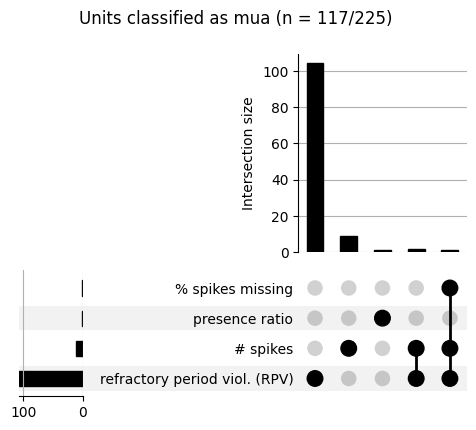

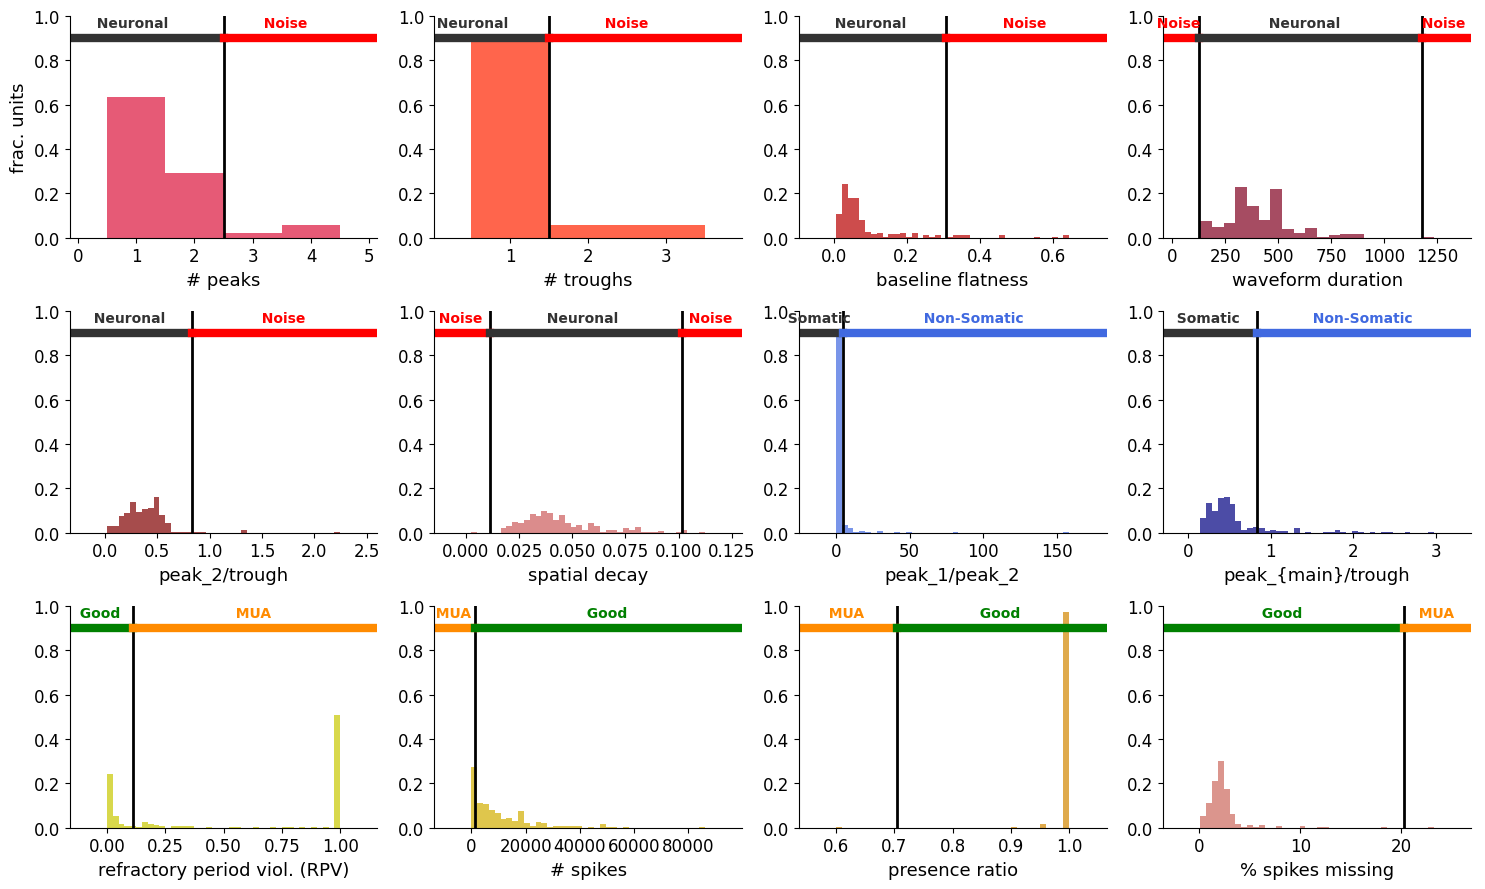


Saving results...
📁 Saving TSV files to Kilosort directory: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day22\neuralData\catgt_20251110_m978528_obs4_g0\20251110_m978528_obs4_g0_imec1\Kilosort4_probe1\sorter_output
All expected metrics were successfully saved.



File: 20251110_m978528_obs4_g0_imec2





estimate_sparsity (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\core\basesorting.py:380: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")


compute_waveforms (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

noise_level (workers: 16 processes):   0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1066: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:914: UserWarning: compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'
  warnings.warn("compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1658: UserWarning: The `sd_ratio` metric require the `spike_amplitudes` waveform extension. Use the `postprocessing.compute_spike_amplitudes()` functions. SD ratio metric will be set to NaN
  warnings.warn(
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packag

🚀 Starting BombCell quality metrics pipeline...
📁 Processing data from: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day22\neuralData\catgt_20251110_m978528_obs4_g0\20251110_m978528_obs4_g0_imec2\Kilosort4_probe2\sorter_output
Results will be saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day22\neuralData\catgt_20251110_m978528_obs4_g0\20251110_m978528_obs4_g0_imec2\Bombcell_imec2

Loading ephys data...
Loaded ephys data: 379 units, 5,495,307 spikes

⚙️ Computing quality metrics for 379 units...
   (Progress bar will appear below)


Computing bombcell quality metrics:   0%|          | 0/379 units


Saving GUI visualization data...
GUI visualization data saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day22\neuralData\catgt_20251110_m978528_obs4_g0\20251110_m978528_obs4_g0_imec2\Bombcell_imec2\for_GUI\gui_data.pkl
   Generated spatial decay fits: 370/379 units
   Generated amplitude fits: 370/379 units

🏷️ Classifying units (good/MUA/noise/non-soma)...

Generating summary plots...


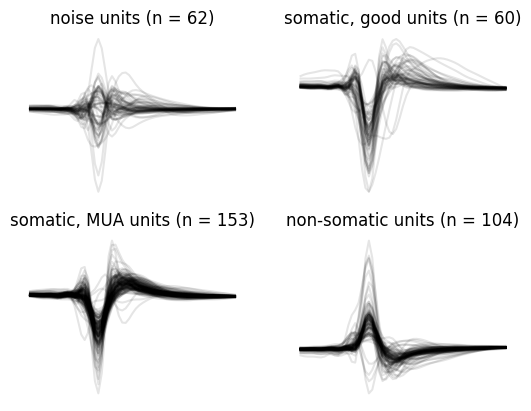

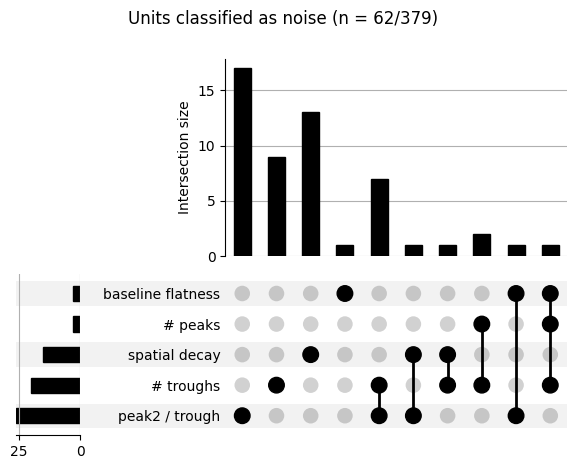

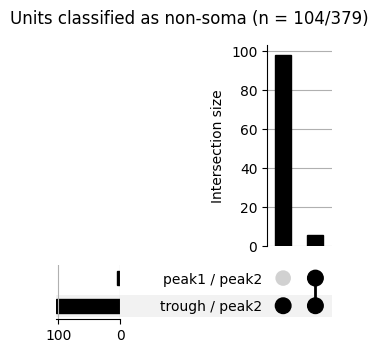

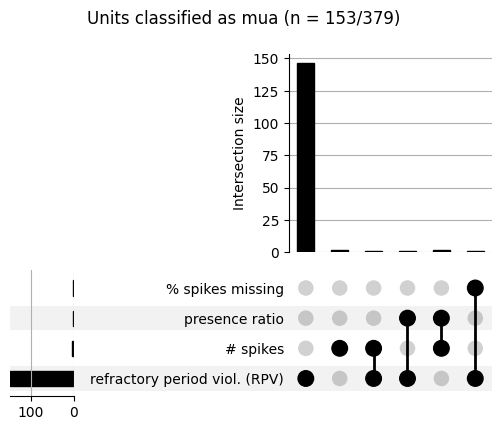

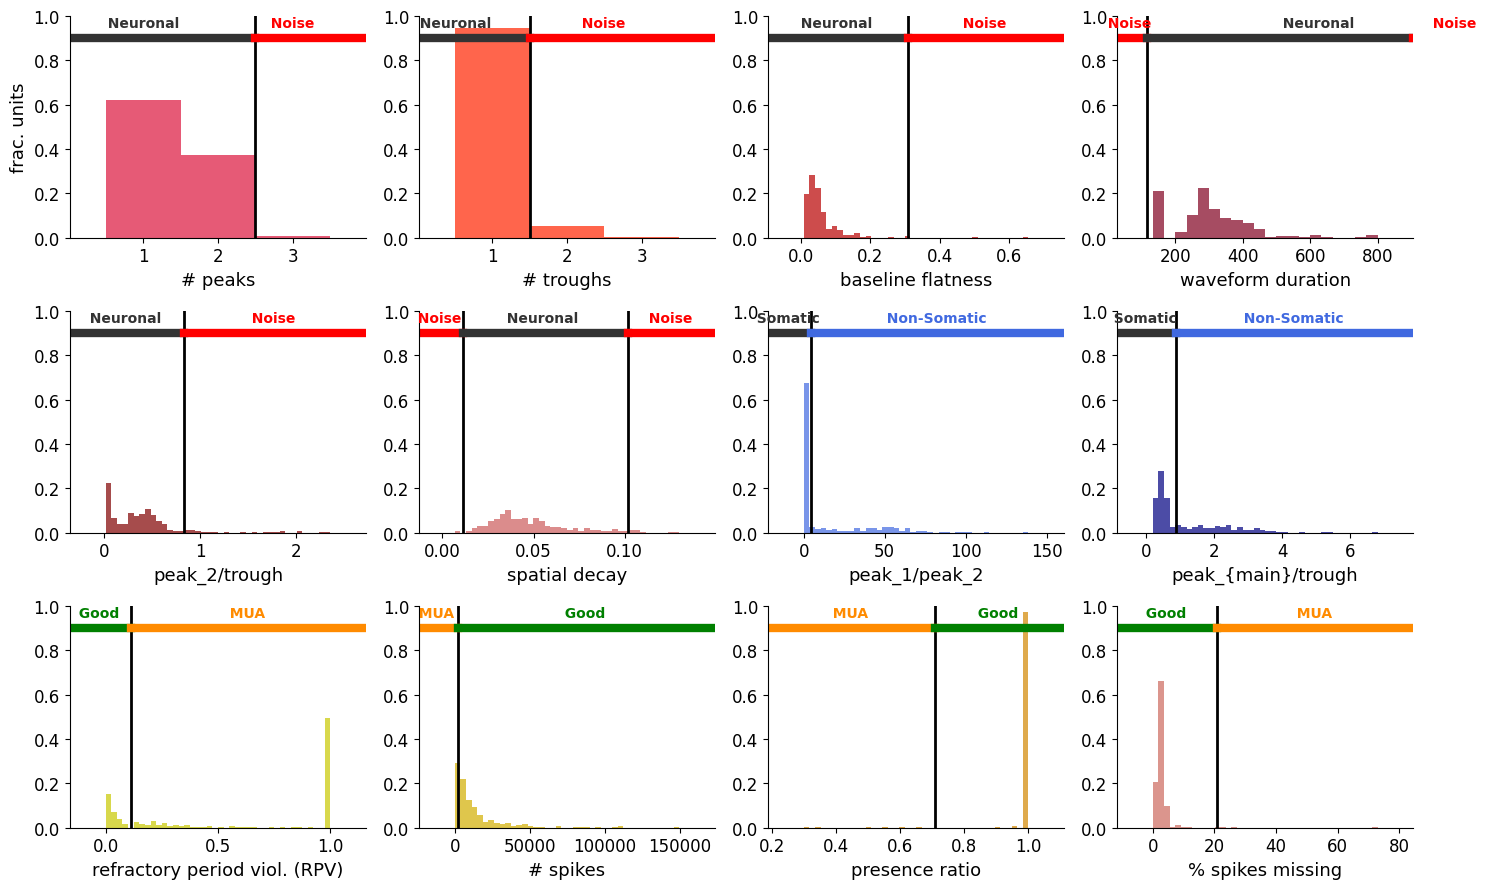


Saving results...
📁 Saving TSV files to Kilosort directory: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day22\neuralData\catgt_20251110_m978528_obs4_g0\20251110_m978528_obs4_g0_imec2\Kilosort4_probe2\sorter_output
All expected metrics were successfully saved.



File: 20251110_m978528_obs5_g0_imec0





estimate_sparsity (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\core\basesorting.py:380: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")


compute_waveforms (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

noise_level (workers: 16 processes):   0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1066: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:914: UserWarning: compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'
  warnings.warn("compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1658: UserWarning: The `sd_ratio` metric require the `spike_amplitudes` waveform extension. Use the `postprocessing.compute_spike_amplitudes()` functions. SD ratio metric will be set to NaN
  warnings.warn(
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packag

🚀 Starting BombCell quality metrics pipeline...
📁 Processing data from: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day24\neuralData\catgt_20251110_m978528_obs5_g0\20251110_m978528_obs5_g0_imec0\Kilosort4_probe0\sorter_output
Results will be saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day24\neuralData\catgt_20251110_m978528_obs5_g0\20251110_m978528_obs5_g0_imec0\Bombcell_imec0

Loading ephys data...
Loaded ephys data: 414 units, 3,351,163 spikes

⚙️ Computing quality metrics for 414 units...
   (Progress bar will appear below)


Computing bombcell quality metrics:   0%|          | 0/414 units


Saving GUI visualization data...
GUI visualization data saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day24\neuralData\catgt_20251110_m978528_obs5_g0\20251110_m978528_obs5_g0_imec0\Bombcell_imec0\for_GUI\gui_data.pkl
   Generated spatial decay fits: 401/414 units
   Generated amplitude fits: 400/414 units

🏷️ Classifying units (good/MUA/noise/non-soma)...

Generating summary plots...


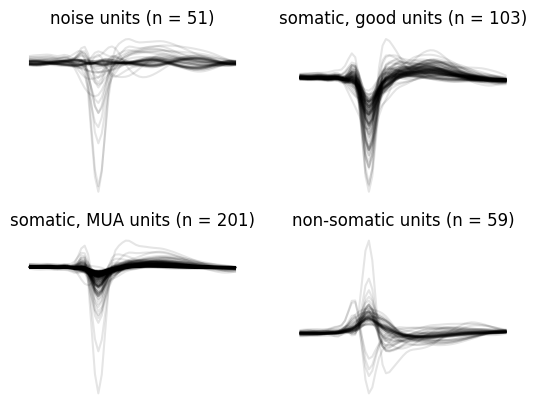

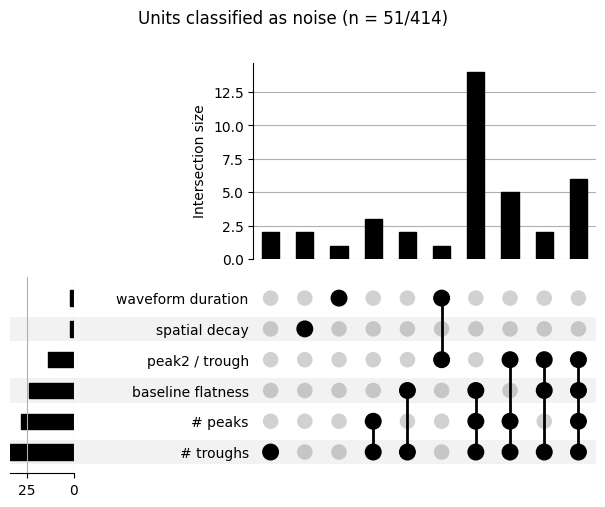

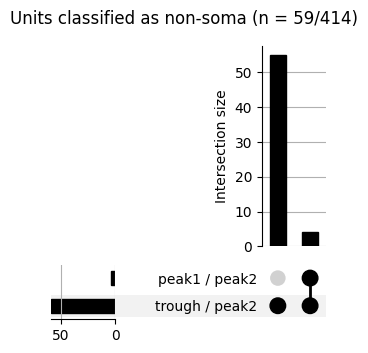

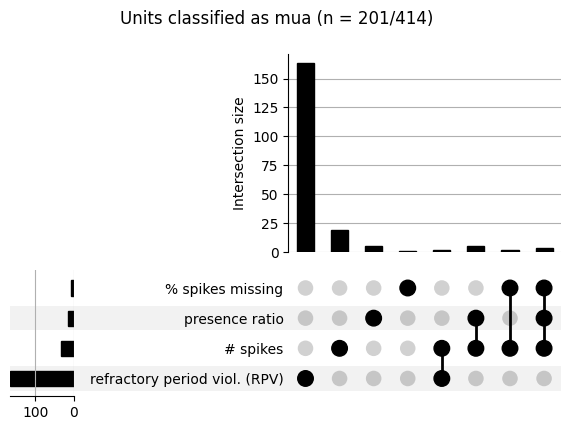

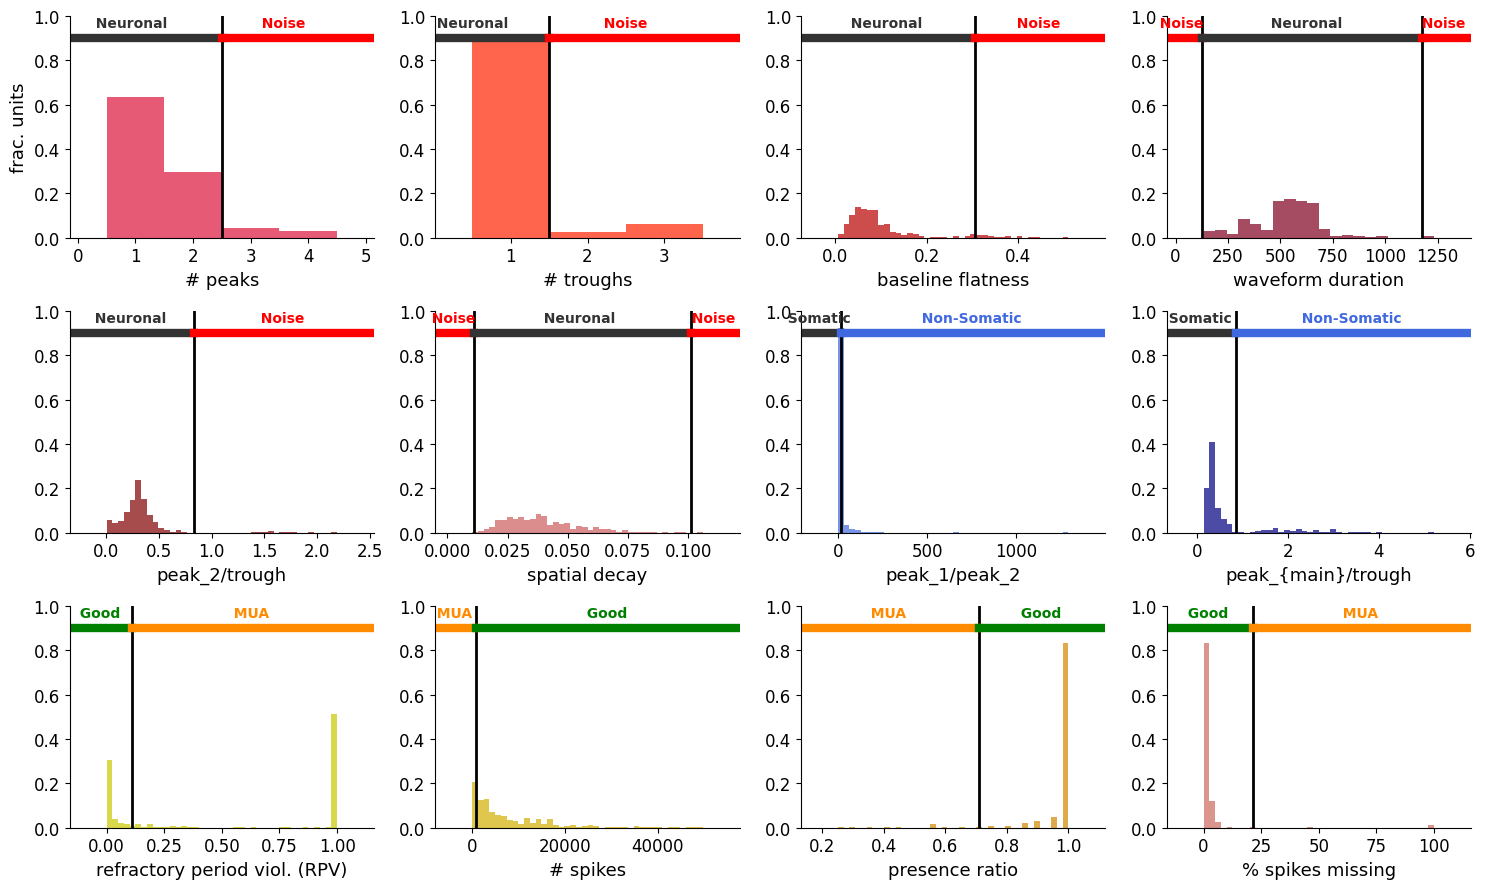


Saving results...
📁 Saving TSV files to Kilosort directory: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day24\neuralData\catgt_20251110_m978528_obs5_g0\20251110_m978528_obs5_g0_imec0\Kilosort4_probe0\sorter_output
All expected metrics were successfully saved.



File: 20251110_m978528_obs5_g0_imec1





estimate_sparsity (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\core\basesorting.py:380: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")


compute_waveforms (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

noise_level (workers: 16 processes):   0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1066: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:914: UserWarning: compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'
  warnings.warn("compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1658: UserWarning: The `sd_ratio` metric require the `spike_amplitudes` waveform extension. Use the `postprocessing.compute_spike_amplitudes()` functions. SD ratio metric will be set to NaN
  warnings.warn(
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packag

🚀 Starting BombCell quality metrics pipeline...
📁 Processing data from: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day24\neuralData\catgt_20251110_m978528_obs5_g0\20251110_m978528_obs5_g0_imec1\Kilosort4_probe1\sorter_output
Results will be saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day24\neuralData\catgt_20251110_m978528_obs5_g0\20251110_m978528_obs5_g0_imec1\Bombcell_imec1

Loading ephys data...
Loaded ephys data: 381 units, 4,315,638 spikes

⚙️ Computing quality metrics for 381 units...
   (Progress bar will appear below)


Computing bombcell quality metrics:   0%|          | 0/381 units


Saving GUI visualization data...
GUI visualization data saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day24\neuralData\catgt_20251110_m978528_obs5_g0\20251110_m978528_obs5_g0_imec1\Bombcell_imec1\for_GUI\gui_data.pkl
   Generated spatial decay fits: 369/381 units
   Generated amplitude fits: 369/381 units

🏷️ Classifying units (good/MUA/noise/non-soma)...

Generating summary plots...


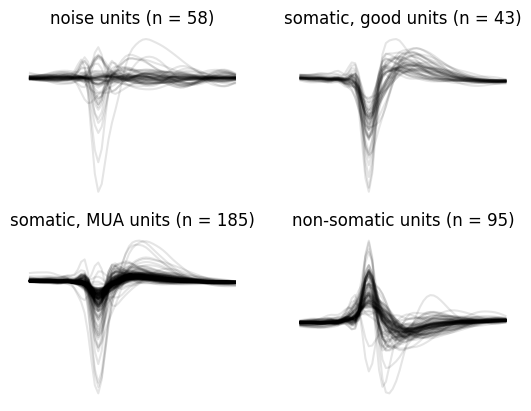

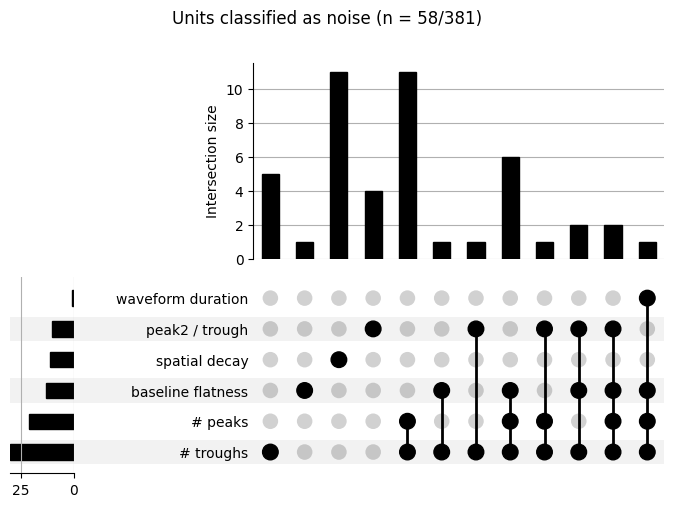

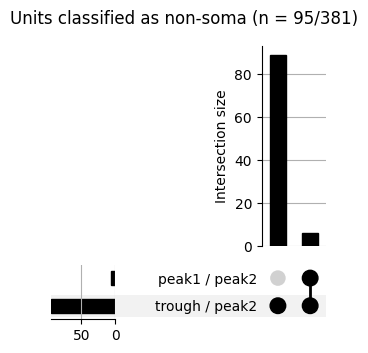

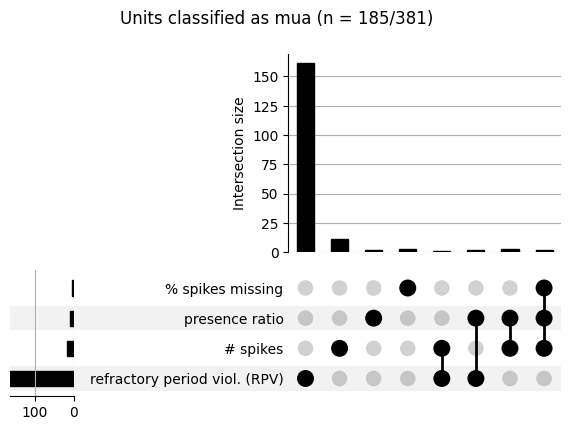

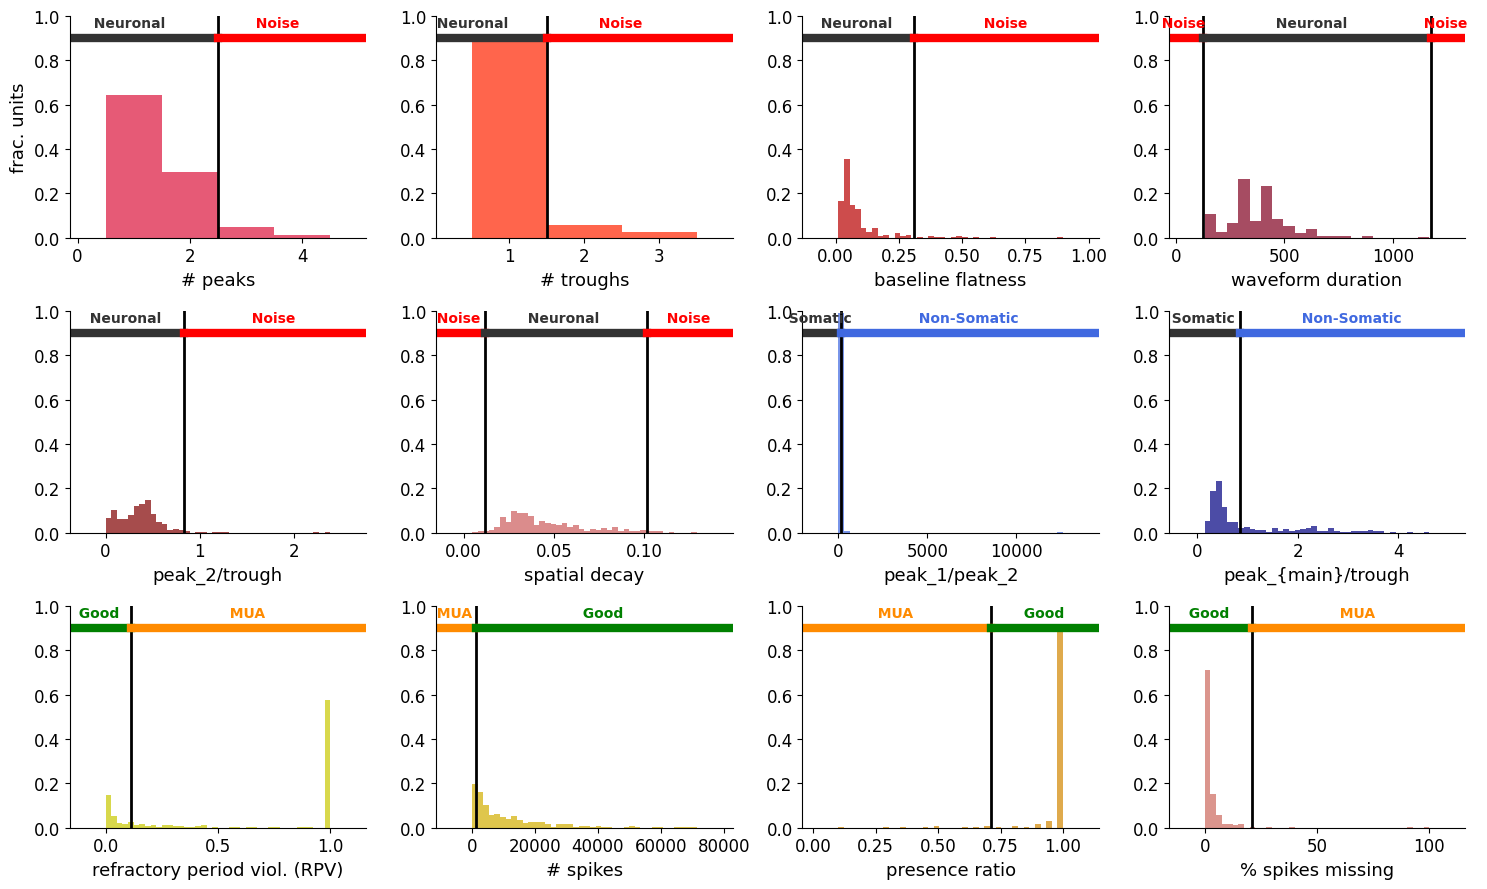


Saving results...
📁 Saving TSV files to Kilosort directory: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day24\neuralData\catgt_20251110_m978528_obs5_g0\20251110_m978528_obs5_g0_imec1\Kilosort4_probe1\sorter_output
All expected metrics were successfully saved.



File: 20251110_m978528_obs5_g0_imec2





estimate_sparsity (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\core\basesorting.py:380: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")


compute_waveforms (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

noise_level (workers: 16 processes):   0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1066: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:914: UserWarning: compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'
  warnings.warn("compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1658: UserWarning: The `sd_ratio` metric require the `spike_amplitudes` waveform extension. Use the `postprocessing.compute_spike_amplitudes()` functions. SD ratio metric will be set to NaN
  warnings.warn(
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packag

🚀 Starting BombCell quality metrics pipeline...
📁 Processing data from: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day24\neuralData\catgt_20251110_m978528_obs5_g0\20251110_m978528_obs5_g0_imec2\Kilosort4_probe2\sorter_output
Results will be saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day24\neuralData\catgt_20251110_m978528_obs5_g0\20251110_m978528_obs5_g0_imec2\Bombcell_imec2

Loading ephys data...
Loaded ephys data: 413 units, 5,658,853 spikes

⚙️ Computing quality metrics for 413 units...
   (Progress bar will appear below)


Computing bombcell quality metrics:   0%|          | 0/413 units


Saving GUI visualization data...
GUI visualization data saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day24\neuralData\catgt_20251110_m978528_obs5_g0\20251110_m978528_obs5_g0_imec2\Bombcell_imec2\for_GUI\gui_data.pkl
   Generated spatial decay fits: 408/413 units
   Generated amplitude fits: 406/413 units

🏷️ Classifying units (good/MUA/noise/non-soma)...

Generating summary plots...


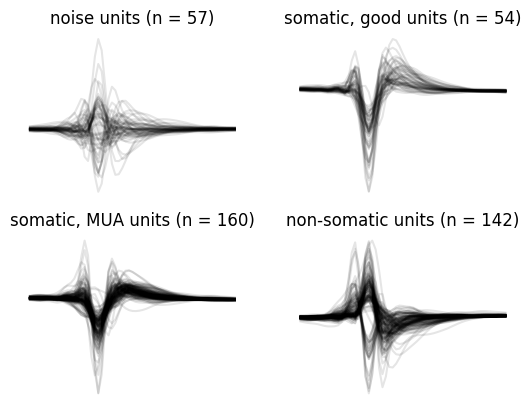

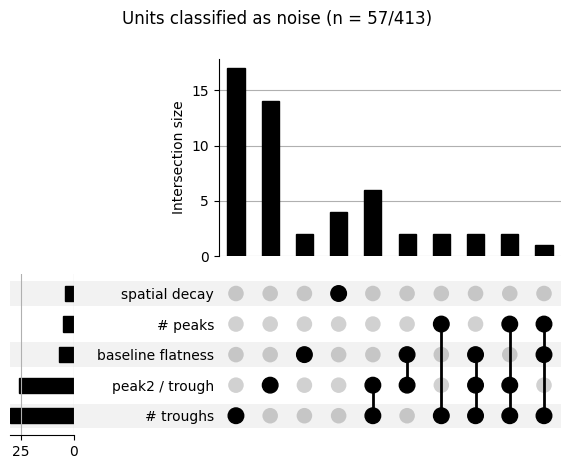

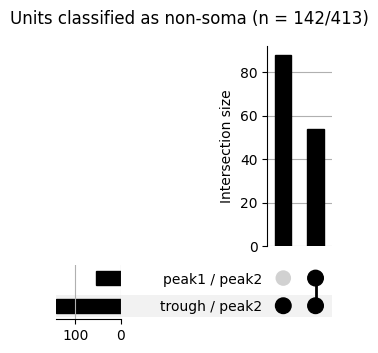

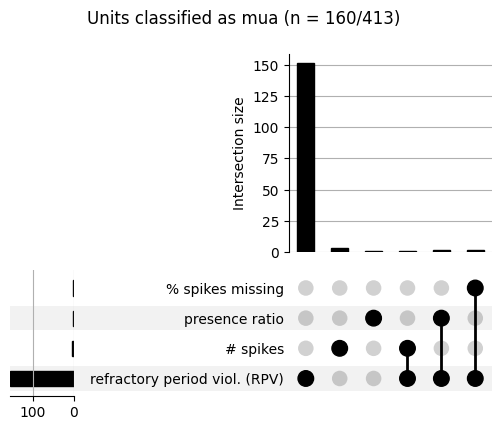

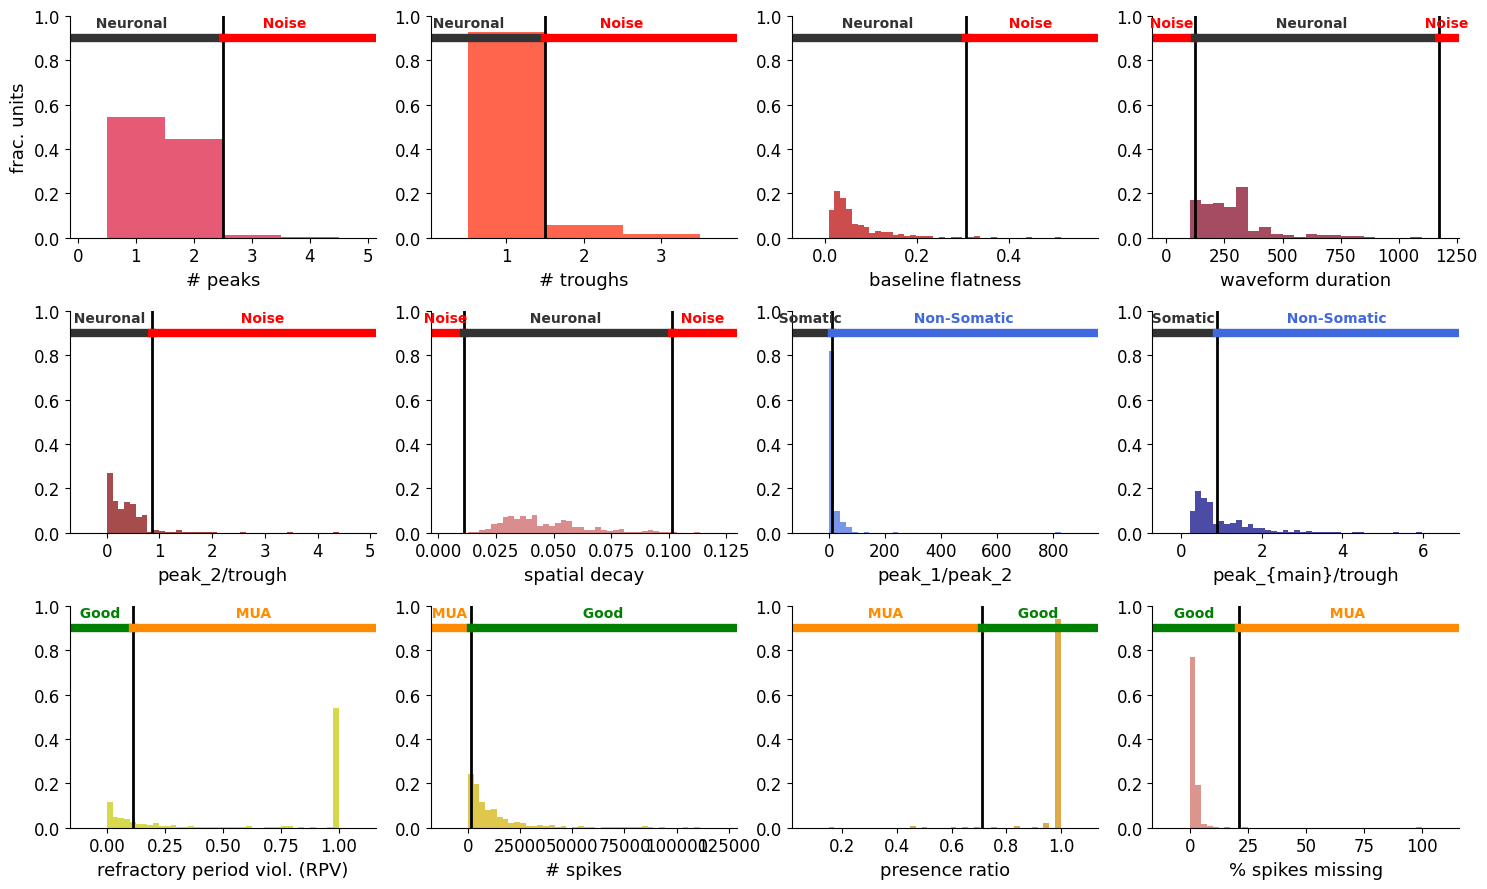


Saving results...
📁 Saving TSV files to Kilosort directory: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day24\neuralData\catgt_20251110_m978528_obs5_g0\20251110_m978528_obs5_g0_imec2\Kilosort4_probe2\sorter_output
All expected metrics were successfully saved.



File: 20251110_m978528_obs5_g0_imec0





estimate_sparsity (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\core\basesorting.py:380: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")


compute_waveforms (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

noise_level (workers: 16 processes):   0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1066: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:914: UserWarning: compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'
  warnings.warn("compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1658: UserWarning: The `sd_ratio` metric require the `spike_amplitudes` waveform extension. Use the `postprocessing.compute_spike_amplitudes()` functions. SD ratio metric will be set to NaN
  warnings.warn(
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packag

🚀 Starting BombCell quality metrics pipeline...
📁 Processing data from: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day25\neuralData\catgt_20251110_m978528_obs5_g0\20251110_m978528_obs5_g0_imec0\Kilosort4_probe0\sorter_output
Results will be saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day25\neuralData\catgt_20251110_m978528_obs5_g0\20251110_m978528_obs5_g0_imec0\Bombcell_imec3

Loading ephys data...
Loaded ephys data: 450 units, 3,160,075 spikes

⚙️ Computing quality metrics for 450 units...
   (Progress bar will appear below)


Computing bombcell quality metrics:   0%|          | 0/450 units


Saving GUI visualization data...
GUI visualization data saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day25\neuralData\catgt_20251110_m978528_obs5_g0\20251110_m978528_obs5_g0_imec0\Bombcell_imec3\for_GUI\gui_data.pkl
   Generated spatial decay fits: 433/450 units
   Generated amplitude fits: 431/450 units

🏷️ Classifying units (good/MUA/noise/non-soma)...

Generating summary plots...


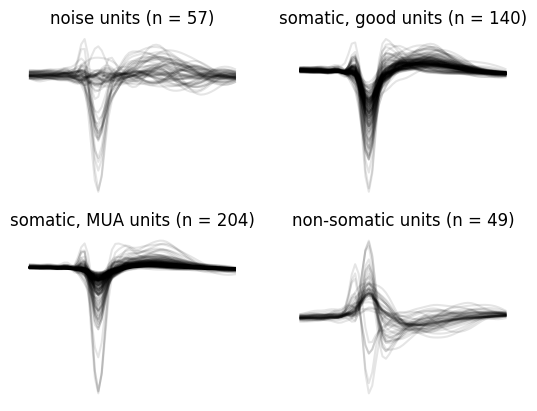

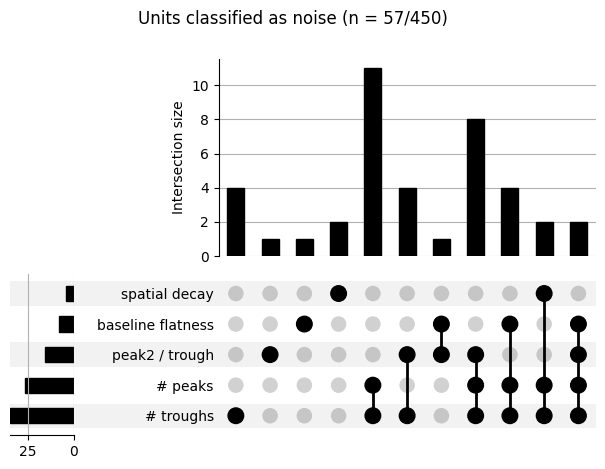

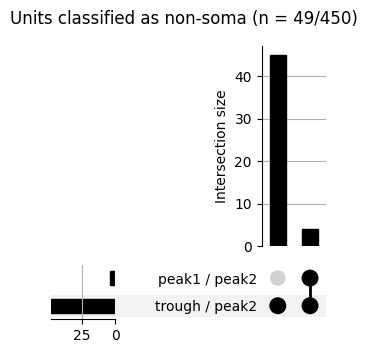

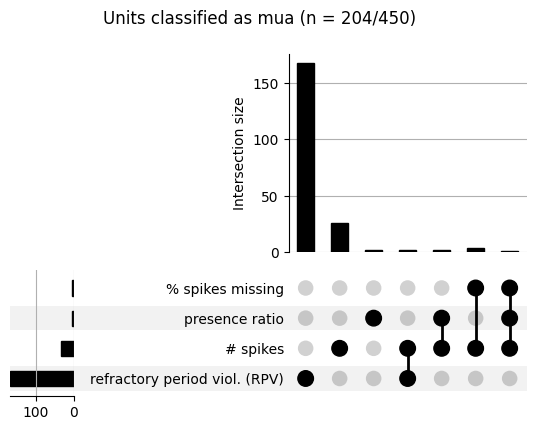

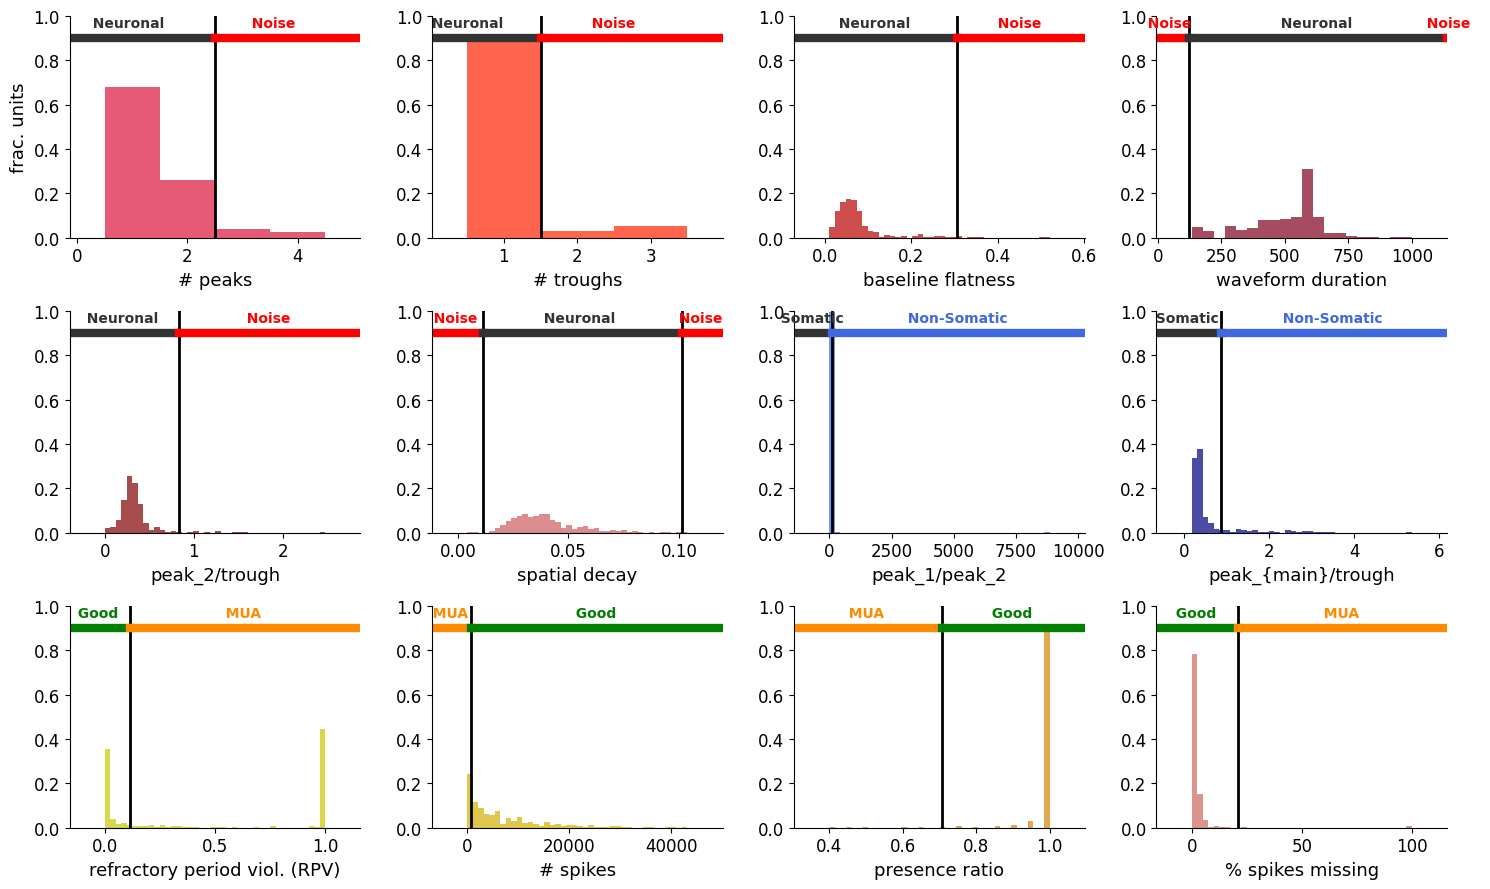


Saving results...
📁 Saving TSV files to Kilosort directory: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day25\neuralData\catgt_20251110_m978528_obs5_g0\20251110_m978528_obs5_g0_imec0\Kilosort4_probe0\sorter_output
All expected metrics were successfully saved.



File: 20251110_m978528_obs5_g0_imec1





estimate_sparsity (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\core\basesorting.py:380: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")


compute_waveforms (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

noise_level (workers: 16 processes):   0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1066: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:914: UserWarning: compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'
  warnings.warn("compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1658: UserWarning: The `sd_ratio` metric require the `spike_amplitudes` waveform extension. Use the `postprocessing.compute_spike_amplitudes()` functions. SD ratio metric will be set to NaN
  warnings.warn(
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packag

🚀 Starting BombCell quality metrics pipeline...
📁 Processing data from: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day25\neuralData\catgt_20251110_m978528_obs5_g0\20251110_m978528_obs5_g0_imec1\Kilosort4_probe1\sorter_output
Results will be saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day25\neuralData\catgt_20251110_m978528_obs5_g0\20251110_m978528_obs5_g0_imec1\Bombcell_imec4

Loading ephys data...
Loaded ephys data: 329 units, 4,969,325 spikes

⚙️ Computing quality metrics for 329 units...
   (Progress bar will appear below)


Computing bombcell quality metrics:   0%|          | 0/329 units


Saving GUI visualization data...
GUI visualization data saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day25\neuralData\catgt_20251110_m978528_obs5_g0\20251110_m978528_obs5_g0_imec1\Bombcell_imec4\for_GUI\gui_data.pkl
   Generated spatial decay fits: 320/329 units
   Generated amplitude fits: 321/329 units

🏷️ Classifying units (good/MUA/noise/non-soma)...

Generating summary plots...


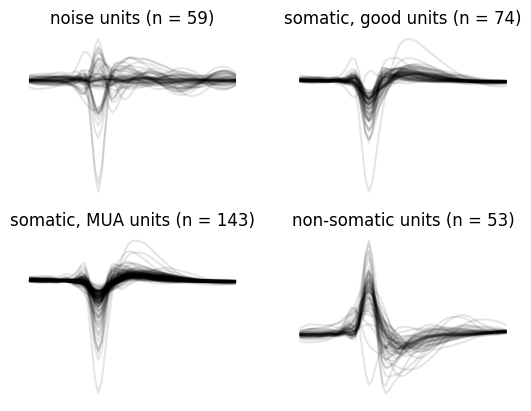

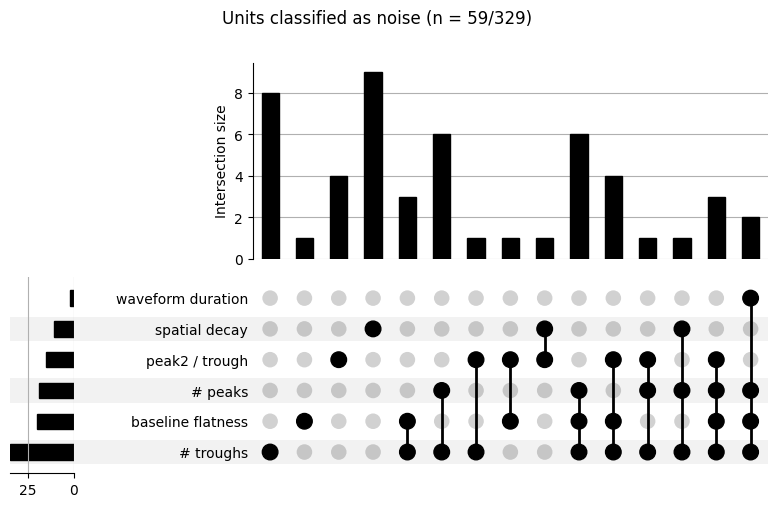

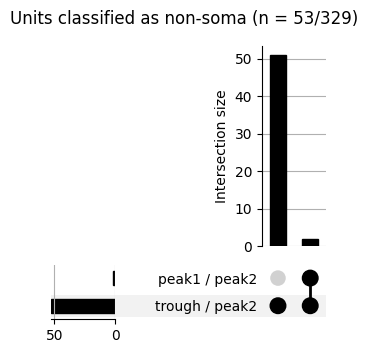

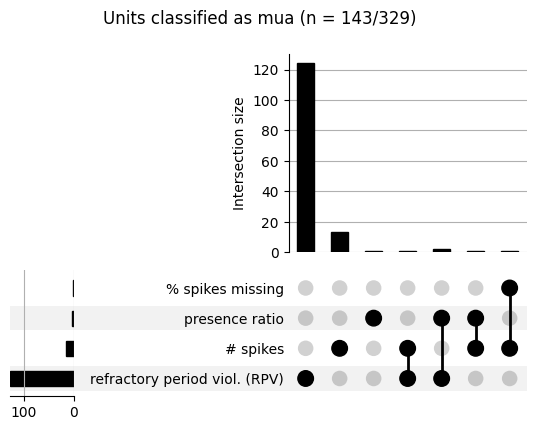

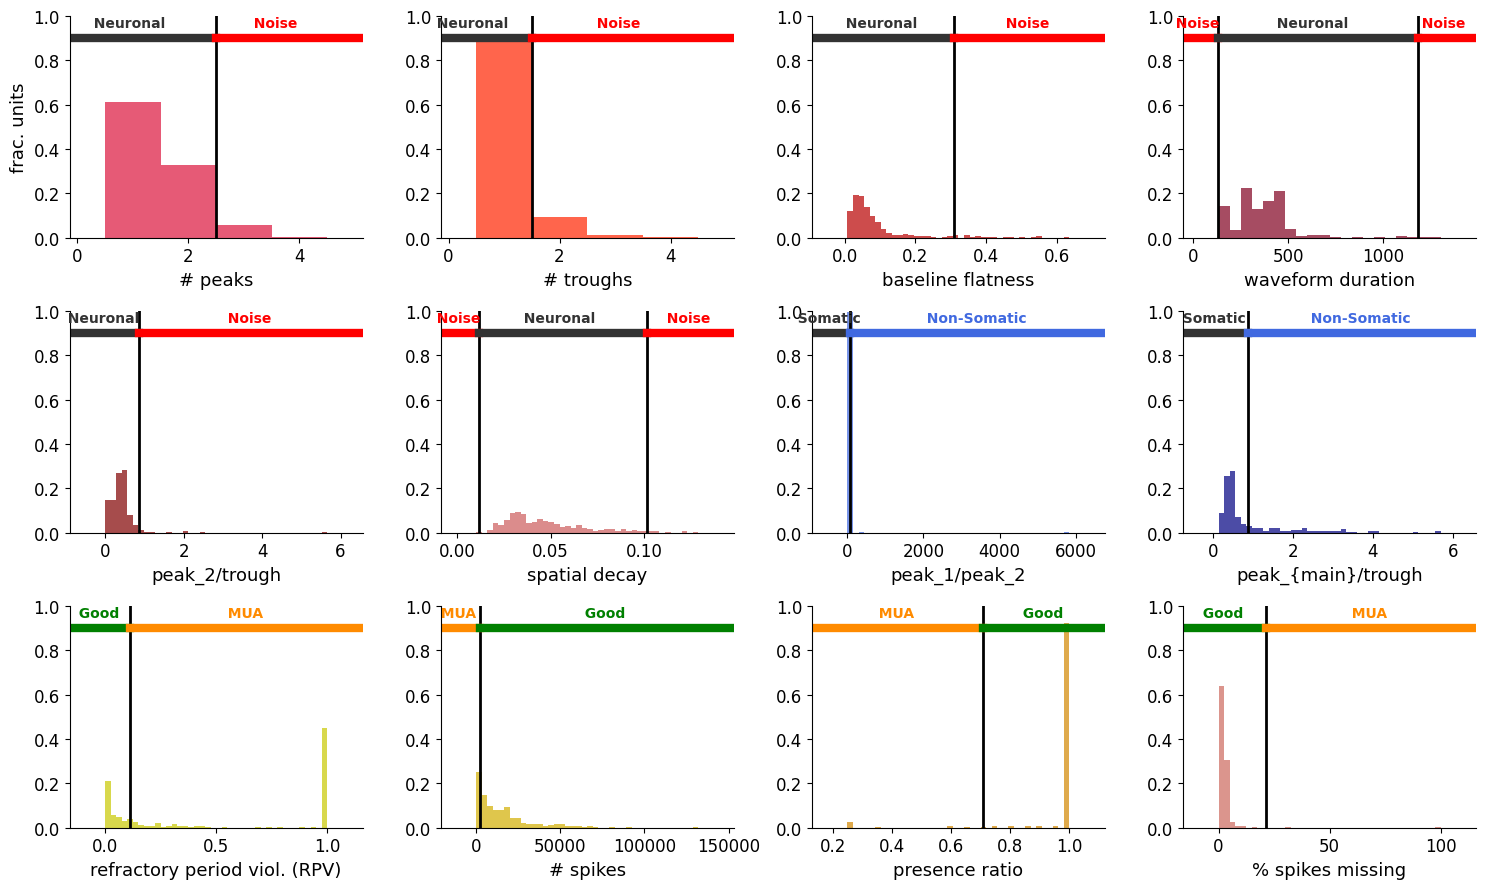


Saving results...
📁 Saving TSV files to Kilosort directory: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day25\neuralData\catgt_20251110_m978528_obs5_g0\20251110_m978528_obs5_g0_imec1\Kilosort4_probe1\sorter_output
All expected metrics were successfully saved.



File: 20251110_m978528_obs5_g0_imec2





estimate_sparsity (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\core\basesorting.py:380: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")


compute_waveforms (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

noise_level (workers: 16 processes):   0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1066: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:914: UserWarning: compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'
  warnings.warn("compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1658: UserWarning: The `sd_ratio` metric require the `spike_amplitudes` waveform extension. Use the `postprocessing.compute_spike_amplitudes()` functions. SD ratio metric will be set to NaN
  warnings.warn(
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packag

🚀 Starting BombCell quality metrics pipeline...
📁 Processing data from: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day25\neuralData\catgt_20251110_m978528_obs5_g0\20251110_m978528_obs5_g0_imec2\Kilosort4_probe2\sorter_output
Results will be saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day25\neuralData\catgt_20251110_m978528_obs5_g0\20251110_m978528_obs5_g0_imec2\Bombcell_imec5

Loading ephys data...
Loaded ephys data: 405 units, 5,851,592 spikes

⚙️ Computing quality metrics for 405 units...
   (Progress bar will appear below)


Computing bombcell quality metrics:   0%|          | 0/405 units


Saving GUI visualization data...
GUI visualization data saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day25\neuralData\catgt_20251110_m978528_obs5_g0\20251110_m978528_obs5_g0_imec2\Bombcell_imec5\for_GUI\gui_data.pkl
   Generated spatial decay fits: 400/405 units
   Generated amplitude fits: 400/405 units

🏷️ Classifying units (good/MUA/noise/non-soma)...

Generating summary plots...


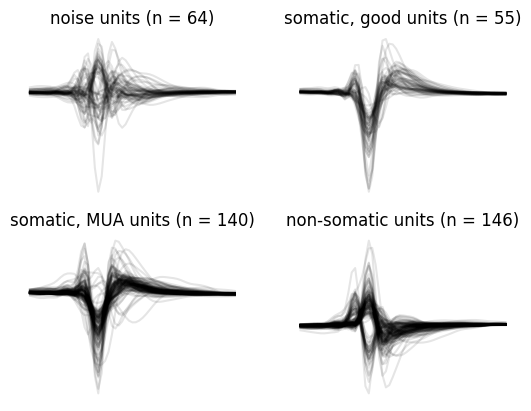

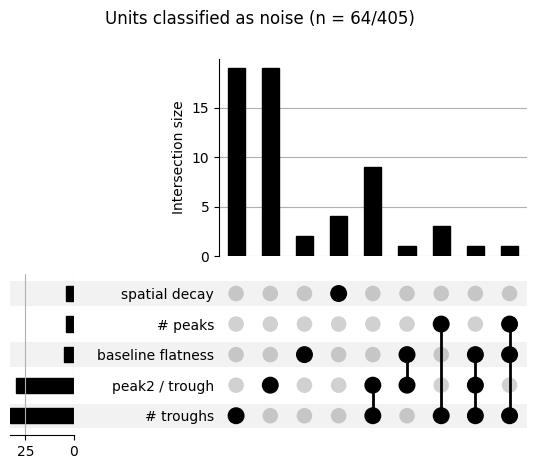

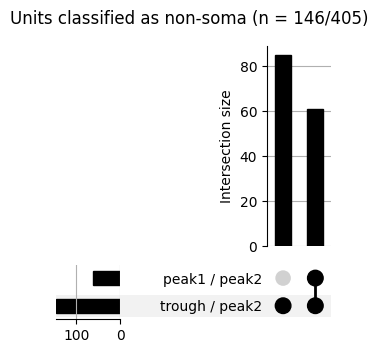

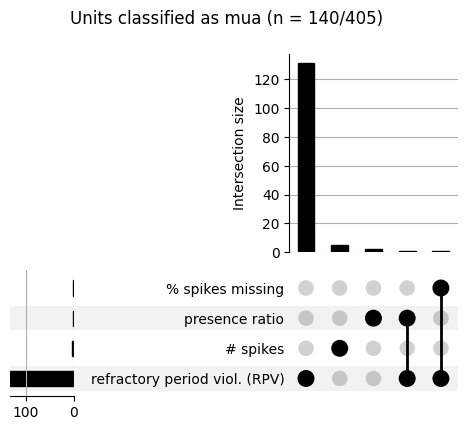

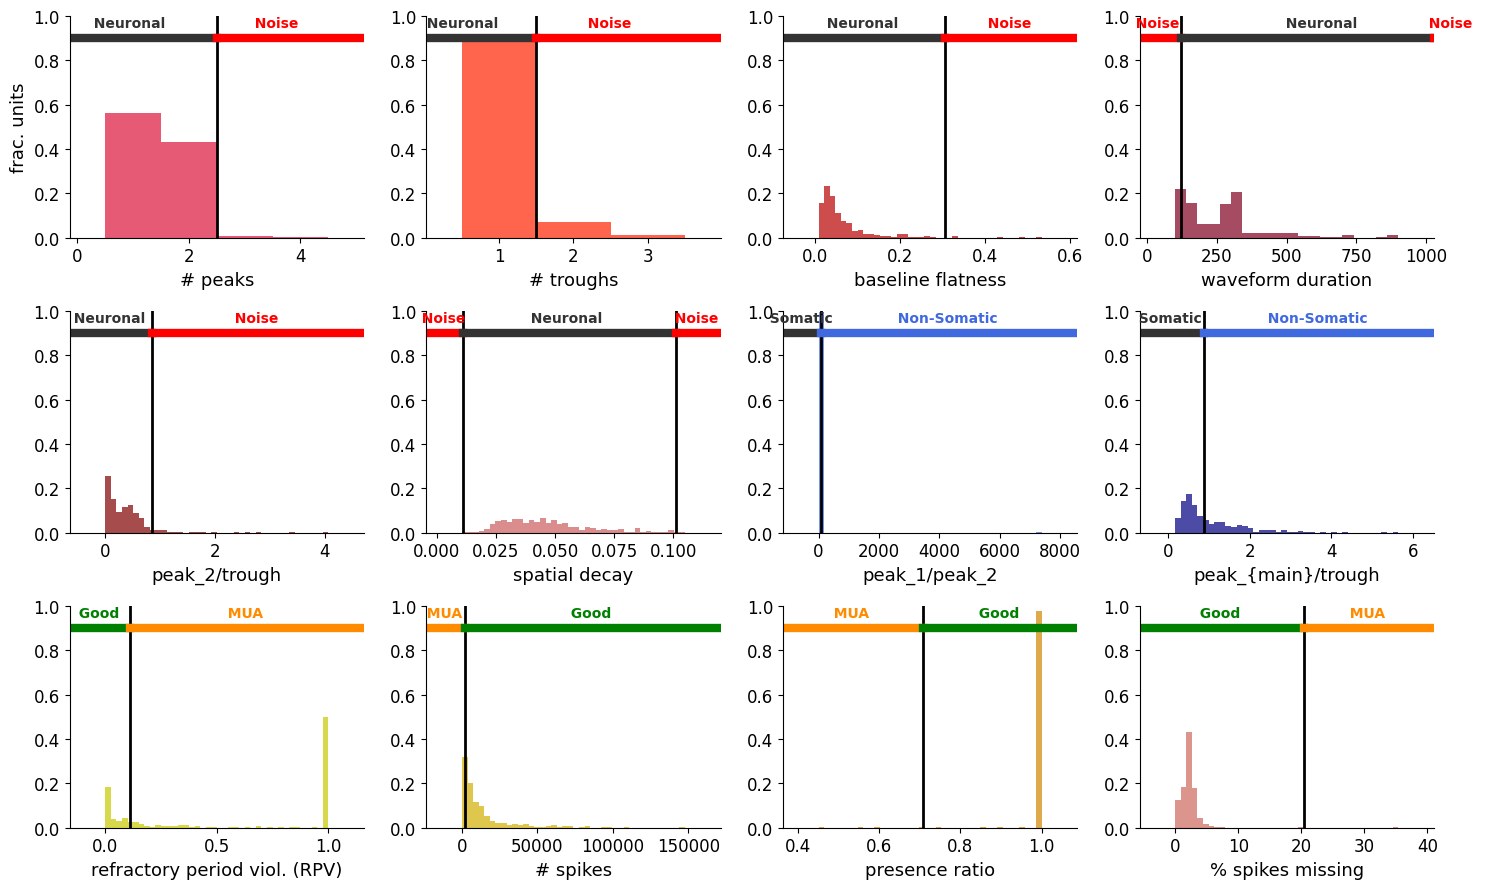


Saving results...
📁 Saving TSV files to Kilosort directory: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day25\neuralData\catgt_20251110_m978528_obs5_g0\20251110_m978528_obs5_g0_imec2\Kilosort4_probe2\sorter_output
All expected metrics were successfully saved.



File: 20251110_m978528_obs6_g0_imec0





estimate_sparsity (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\core\basesorting.py:380: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")


compute_waveforms (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

noise_level (workers: 16 processes):   0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1066: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:914: UserWarning: compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'
  warnings.warn("compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1658: UserWarning: The `sd_ratio` metric require the `spike_amplitudes` waveform extension. Use the `postprocessing.compute_spike_amplitudes()` functions. SD ratio metric will be set to NaN
  warnings.warn(
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packag

🚀 Starting BombCell quality metrics pipeline...
📁 Processing data from: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day26\neuralData\catgt_20251110_m978528_obs6_g0\20251110_m978528_obs6_g0_imec0\Kilosort4_probe0\sorter_output
Results will be saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day26\neuralData\catgt_20251110_m978528_obs6_g0\20251110_m978528_obs6_g0_imec0\Bombcell_imec0

Loading ephys data...
Loaded ephys data: 313 units, 2,026,526 spikes

⚙️ Computing quality metrics for 313 units...
   (Progress bar will appear below)


Computing bombcell quality metrics:   0%|          | 0/313 units


Saving GUI visualization data...
GUI visualization data saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day26\neuralData\catgt_20251110_m978528_obs6_g0\20251110_m978528_obs6_g0_imec0\Bombcell_imec0\for_GUI\gui_data.pkl
   Generated spatial decay fits: 288/313 units
   Generated amplitude fits: 288/313 units

🏷️ Classifying units (good/MUA/noise/non-soma)...

Generating summary plots...


c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\bombcell\plot_functions.py:434: RuntimeWarning: Could not create non-soma upset plot due to library compatibility: 'Index' object has no attribute 'levels'
  warnings.warn(f"Could not create {unit_type_str.lower()} upset plot due to library compatibility: {e}", RuntimeWarning)


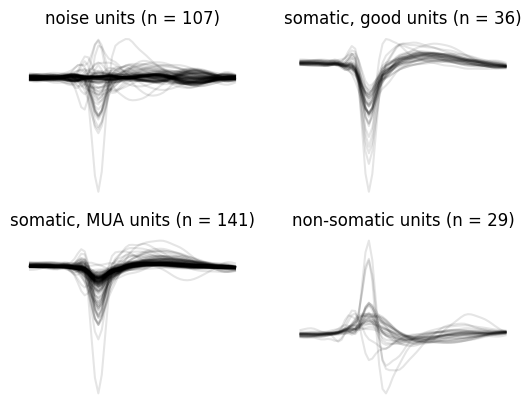

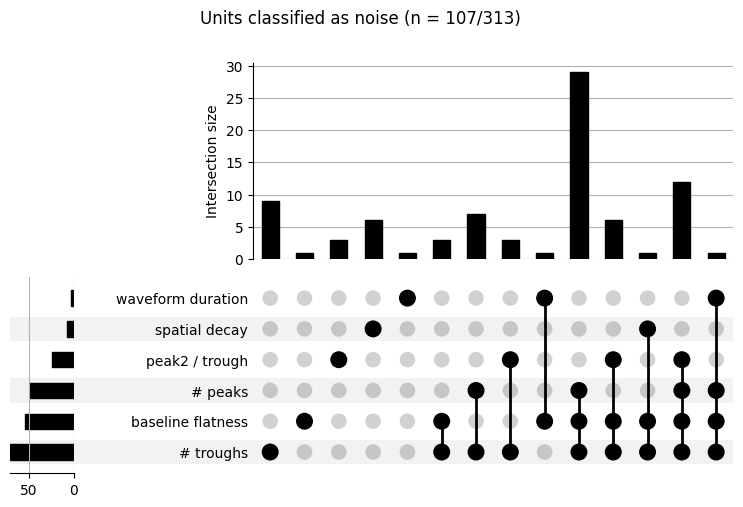

<Figure size 640x480 with 0 Axes>

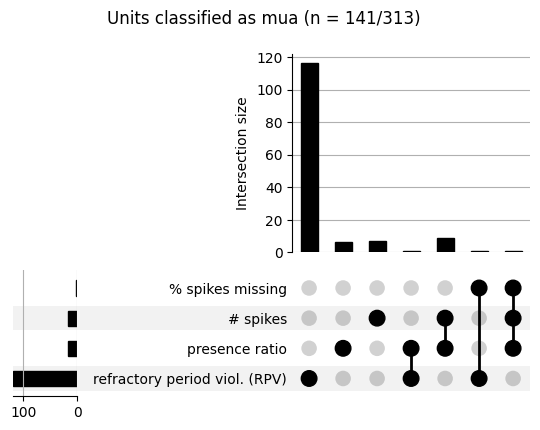

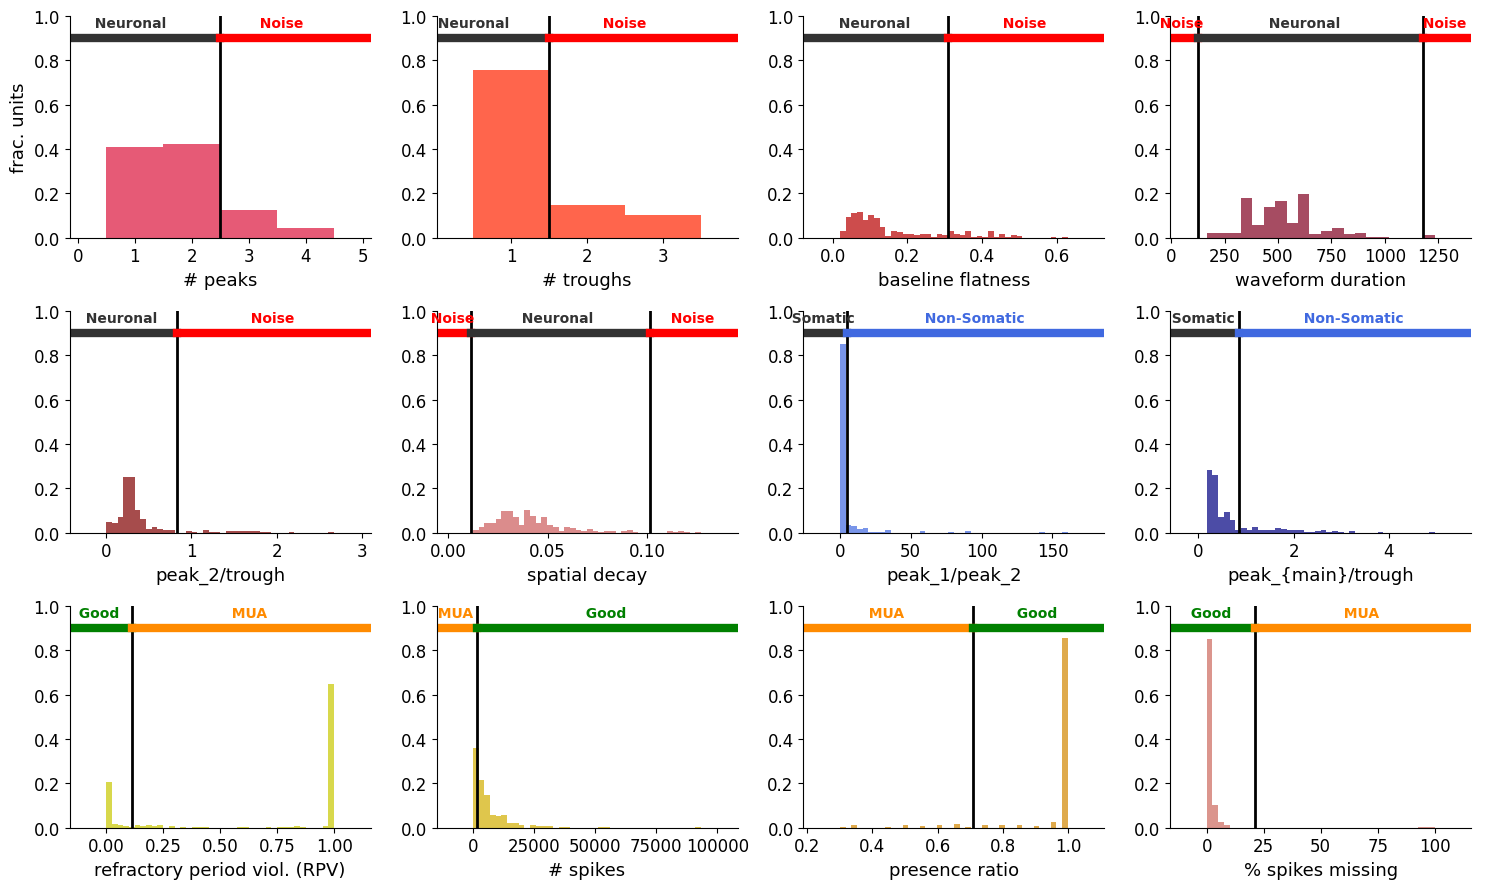


Saving results...
📁 Saving TSV files to Kilosort directory: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day26\neuralData\catgt_20251110_m978528_obs6_g0\20251110_m978528_obs6_g0_imec0\Kilosort4_probe0\sorter_output
All expected metrics were successfully saved.



File: 20251110_m978528_obs6_g0_imec1





estimate_sparsity (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\core\basesorting.py:380: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")


compute_waveforms (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

noise_level (workers: 16 processes):   0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1066: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:914: UserWarning: compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'
  warnings.warn("compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1658: UserWarning: The `sd_ratio` metric require the `spike_amplitudes` waveform extension. Use the `postprocessing.compute_spike_amplitudes()` functions. SD ratio metric will be set to NaN
  warnings.warn(
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packag

🚀 Starting BombCell quality metrics pipeline...
📁 Processing data from: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day26\neuralData\catgt_20251110_m978528_obs6_g0\20251110_m978528_obs6_g0_imec1\Kilosort4_probe1\sorter_output
Results will be saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day26\neuralData\catgt_20251110_m978528_obs6_g0\20251110_m978528_obs6_g0_imec1\Bombcell_imec1

Loading ephys data...
Loaded ephys data: 374 units, 4,431,673 spikes

⚙️ Computing quality metrics for 374 units...
   (Progress bar will appear below)


Computing bombcell quality metrics:   0%|          | 0/374 units


Saving GUI visualization data...
GUI visualization data saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day26\neuralData\catgt_20251110_m978528_obs6_g0\20251110_m978528_obs6_g0_imec1\Bombcell_imec1\for_GUI\gui_data.pkl
   Generated spatial decay fits: 362/374 units
   Generated amplitude fits: 362/374 units

🏷️ Classifying units (good/MUA/noise/non-soma)...

Generating summary plots...


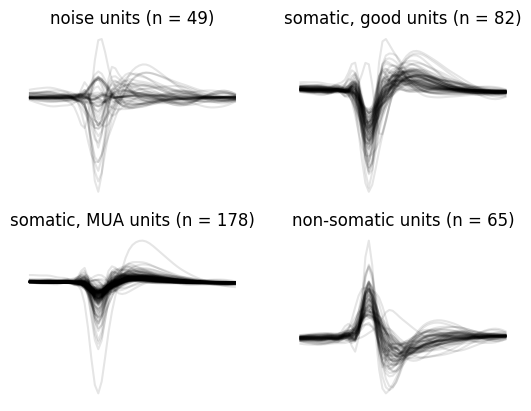

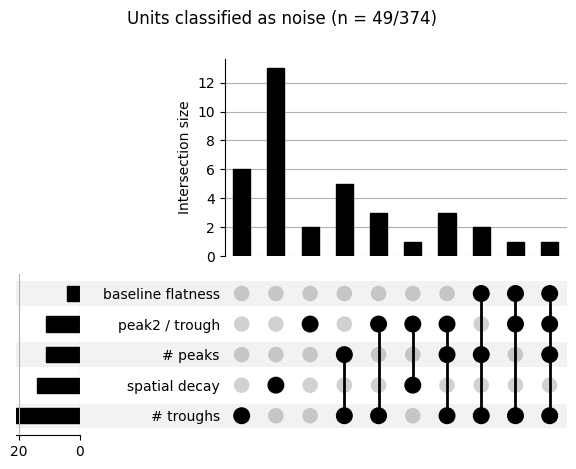

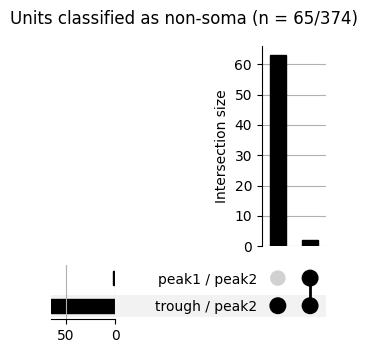

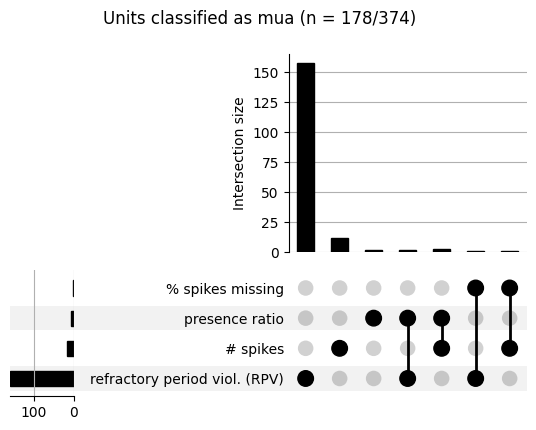

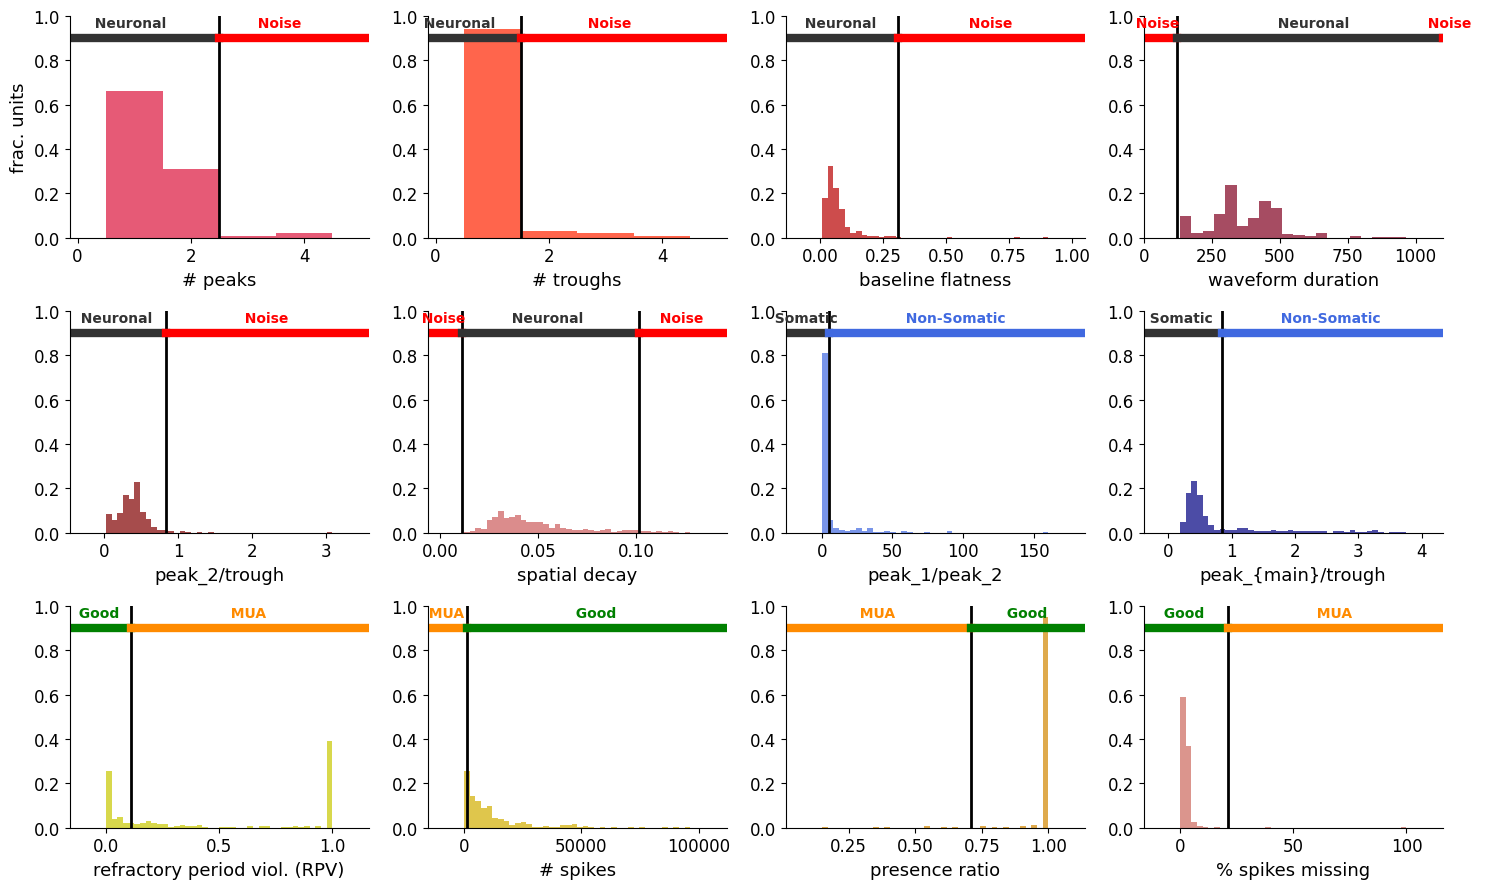


Saving results...
📁 Saving TSV files to Kilosort directory: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day26\neuralData\catgt_20251110_m978528_obs6_g0\20251110_m978528_obs6_g0_imec1\Kilosort4_probe1\sorter_output
All expected metrics were successfully saved.



File: 20251110_m978528_obs6_g0_imec2





estimate_sparsity (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\core\basesorting.py:380: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")


compute_waveforms (workers: 16 processes):   0%|          | 0/1206 [00:00<?, ?it/s]

noise_level (workers: 16 processes):   0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1066: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:914: UserWarning: compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'
  warnings.warn("compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'")
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1658: UserWarning: The `sd_ratio` metric require the `spike_amplitudes` waveform extension. Use the `postprocessing.compute_spike_amplitudes()` functions. SD ratio metric will be set to NaN
  warnings.warn(
c:\Users\Data Analysis\anaconda3\envs\SpikeInterface_KS\Lib\site-packag

🚀 Starting BombCell quality metrics pipeline...
📁 Processing data from: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day26\neuralData\catgt_20251110_m978528_obs6_g0\20251110_m978528_obs6_g0_imec2\Kilosort4_probe2\sorter_output
Results will be saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day26\neuralData\catgt_20251110_m978528_obs6_g0\20251110_m978528_obs6_g0_imec2\Bombcell_imec2

Loading ephys data...
Loaded ephys data: 399 units, 6,867,012 spikes

⚙️ Computing quality metrics for 399 units...
   (Progress bar will appear below)


Computing bombcell quality metrics:   0%|          | 0/399 units


Saving GUI visualization data...
GUI visualization data saved to: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day26\neuralData\catgt_20251110_m978528_obs6_g0\20251110_m978528_obs6_g0_imec2\Bombcell_imec2\for_GUI\gui_data.pkl
   Generated spatial decay fits: 398/399 units
   Generated amplitude fits: 398/399 units

🏷️ Classifying units (good/MUA/noise/non-soma)...

Generating summary plots...


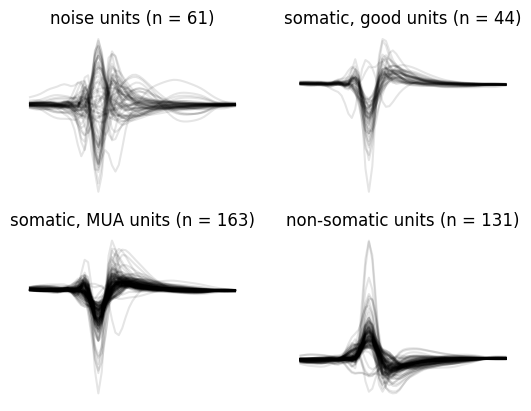

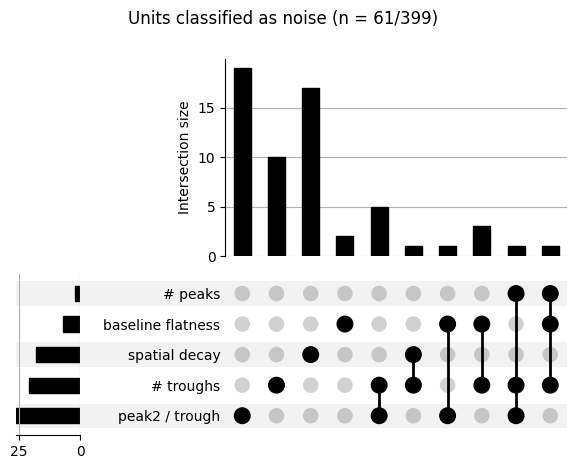

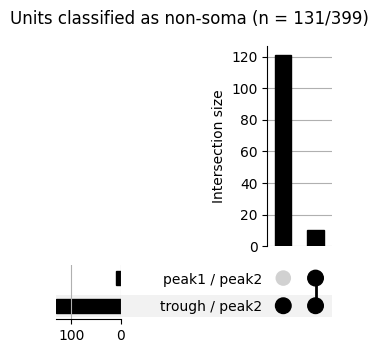

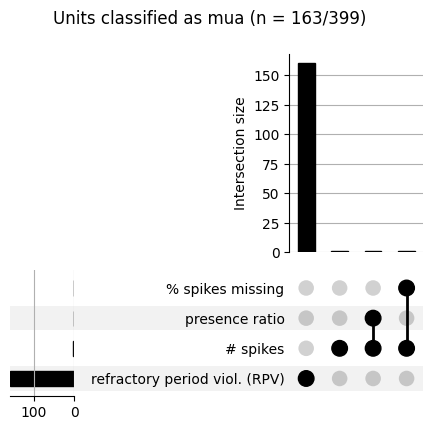

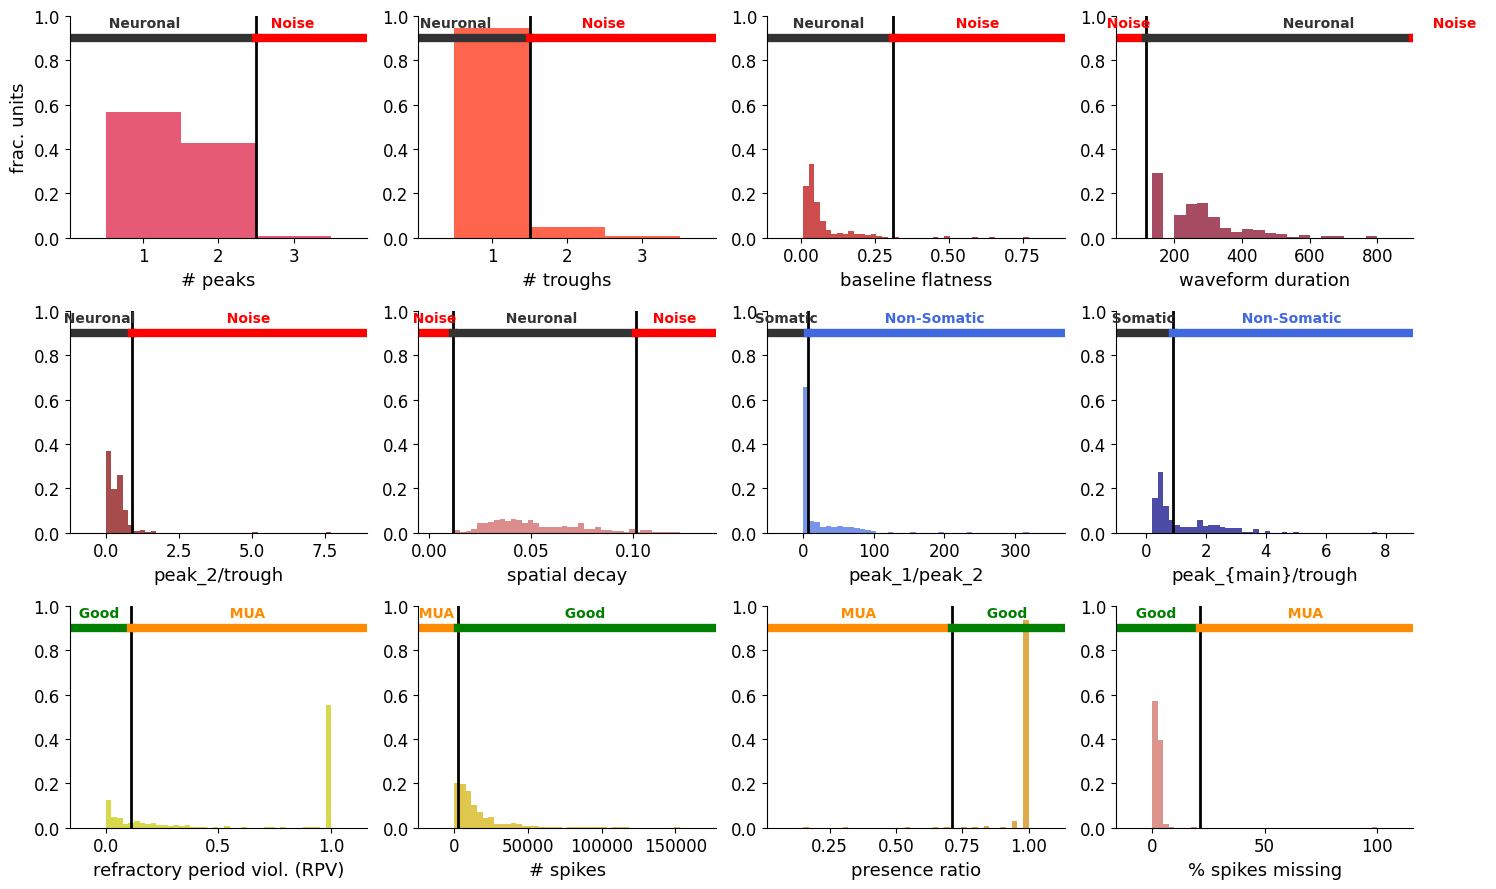


Saving results...
📁 Saving TSV files to Kilosort directory: J:\project_trainingAggression\Data\Maladaptive\Controls\20251110_mouse978528\Day26\neuralData\catgt_20251110_m978528_obs6_g0\20251110_m978528_obs6_g0_imec2\Kilosort4_probe2\sorter_output
All expected metrics were successfully saved.


In [17]:
for session in session_groups:
    for probe_id, probe_rec in enumerate(session):

        print("\n\n\n==================================================")
        print(f"File: {probe_rec.parent.parent.name}")
        print("==================================================\n\n\n")
        
        sorting = si.read_sorter_folder(probe_rec.parent)
        rec_pkl = probe_rec.parent / "spikeinterface_recording.pickle"

        with open(rec_pkl, "rb") as f:
            rec_dict = pickle.load(f)

        rec = si.load(rec_dict, base_folder=probe_rec.parent)
        
        sorting_analyzer = si.create_sorting_analyzer(folder=probe_rec.parent.parent / f"sortingAnalyzer_imec{probe_id}",
                                                      recording=rec,
                                                      sorting=sorting,
                                                      format="binary_folder",
                                                      n_jobs=16,
                                                      overwrite=True)
                                                                                                                                                                                                                                                                             
        sorting_analyzer.compute(["random_spikes", "waveforms", "templates", "noise_levels"], n_jobs=16)
        sorting_analyzer.compute("quality_metrics", n_jobs=16)

        quality_metrics, param, unit_type, unit_type_string, figures = bc.run_bombcell(probe_rec,
                                                                                        probe_rec.parent.parent / f"Bombcell_imec{probe_id}",
                                                                                        bc.get_default_parameters(
                                                                                                probe_rec,
                                                                                                kilosort_version=4,
                                                                                        ),
                                                                                        return_figures=True)

### Cell selection creteria

In [1]:
import os
from phylib.io.model import load_model
from phy.apps.template.gui import TemplateController
from pathlib import Path
from itertools import groupby

dt_folder = Path(r"J:\project_trainingAggression\Data")

params_files = [f for f in dt_folder.rglob("*params.py")]
tsv_files = [f.parent for f in dt_folder.rglob("*cluster_info.tsv")]

params_files_2process = [file for file in params_files if file.parent not in tsv_files]

def session_key(p):
    p = str(p)  # works for string paths or Path objects
    return next(part for part in p.split("\\") if part.startswith("catgt_"))

paths_sorted = sorted(params_files_2process, key=session_key)

session_groups = [list(g) for _, g in groupby(params_files_2process, key=session_key)]
session_groups

[[WindowsPath('J:/project_trainingAggression/Data/Maladaptive/Controls/20251110_mouse978528/Day08/neuralData/catgt_20251110_m978528_obs1_g0/20251110_m978528_obs1_g0_imec0/Kilosort4_probe0/sorter_output/params.py'),
  WindowsPath('J:/project_trainingAggression/Data/Maladaptive/Controls/20251110_mouse978528/Day08/neuralData/catgt_20251110_m978528_obs1_g0/20251110_m978528_obs1_g0_imec1/Kilosort4_probe1/sorter_output/params.py'),
  WindowsPath('J:/project_trainingAggression/Data/Maladaptive/Controls/20251110_mouse978528/Day08/neuralData/catgt_20251110_m978528_obs1_g0/20251110_m978528_obs1_g0_imec2/Kilosort4_probe2/sorter_output/params.py')],
 [WindowsPath('J:/project_trainingAggression/Data/Maladaptive/Controls/20251110_mouse978528/Day10/neuralData/catgt_20251110_m978528_obs2_g0/20251110_m978528_obs2_g0_imec0/Kilosort4_probe0/sorter_output/params.py'),
  WindowsPath('J:/project_trainingAggression/Data/Maladaptive/Controls/20251110_mouse978528/Day10/neuralData/catgt_20251110_m978528_obs2_g0

In [2]:
for session in session_groups:
    for probe_file in session:

        print("\n==================================================")
        print(f"File: {probe_file.parent.parent.parent.name}")
        print("==================================================\n")

        model = load_model(probe_file)
        controller = TemplateController(dir_path=model.dir_path, model=model)

        controller._save_cluster_info()  




File: 20251110_m978528_obs1_g0_imec0


File: 20251110_m978528_obs1_g0_imec1


File: 20251110_m978528_obs1_g0_imec2


File: 20251110_m978528_obs2_g0_imec0


File: 20251110_m978528_obs2_g0_imec1


File: 20251110_m978528_obs2_g0_imec2


File: 20251110_m978528_obs3_g0_imec0


File: 20251110_m978528_obs3_g0_imec1


File: 20251110_m978528_obs3_g0_imec2


File: 20251110_m978528_obs4_g0_imec0


File: 20251110_m978528_obs4_g0_imec1


File: 20251110_m978528_obs4_g0_imec2


File: 20251110_m978528_obs5_g0_imec0


File: 20251110_m978528_obs5_g0_imec1


File: 20251110_m978528_obs5_g0_imec2


File: 20251110_m978528_obs5_g0_imec0


File: 20251110_m978528_obs5_g0_imec1


File: 20251110_m978528_obs5_g0_imec2


File: 20251110_m978528_obs6_g0_imec0


File: 20251110_m978528_obs6_g0_imec1


File: 20251110_m978528_obs6_g0_imec2



In [3]:
import pandas as pd
import numpy as np
from scipy.signal import argrelmin, argrelmax
from scipy.ndimage import gaussian_filter1d
from matplotlib.patches import Polygon
from phylib.io.model import load_model  # type: ignore
from phy.utils.color import selected_cluster_color  # type: ignore
from joblib import Parallel, delayed
import gc

In [4]:

spikes_processed = [f.parent for f in dt_folder.rglob("*spike_width_variance_ratios_detailed.npy")]
params_2proc = [p for p in params_files if p.parent not in spikes_processed]

paths_sorted = sorted(params_2proc, key=session_key)

session_groups = [list(g) for _, g in groupby(paths_sorted, key=session_key)]
session_groups

[[WindowsPath('J:/project_trainingAggression/Data/Maladaptive/Controls/20251110_mouse978528/Day08/neuralData/catgt_20251110_m978528_obs1_g0/20251110_m978528_obs1_g0_imec0/Kilosort4_probe0/sorter_output/params.py'),
  WindowsPath('J:/project_trainingAggression/Data/Maladaptive/Controls/20251110_mouse978528/Day08/neuralData/catgt_20251110_m978528_obs1_g0/20251110_m978528_obs1_g0_imec1/Kilosort4_probe1/sorter_output/params.py'),
  WindowsPath('J:/project_trainingAggression/Data/Maladaptive/Controls/20251110_mouse978528/Day08/neuralData/catgt_20251110_m978528_obs1_g0/20251110_m978528_obs1_g0_imec2/Kilosort4_probe2/sorter_output/params.py')],
 [WindowsPath('J:/project_trainingAggression/Data/Maladaptive/Controls/20251110_mouse978528/Day10/neuralData/catgt_20251110_m978528_obs2_g0/20251110_m978528_obs2_g0_imec0/Kilosort4_probe0/sorter_output/params.py'),
  WindowsPath('J:/project_trainingAggression/Data/Maladaptive/Controls/20251110_mouse978528/Day10/neuralData/catgt_20251110_m978528_obs2_g0

In [5]:
def width_variance(waveforms, mean_waveforms, left=False, right=False):
    N, T = waveforms.shape
    # 1. slope
    slope = np.gradient(mean_waveforms)

    # 2. center
    peak = np.max(mean_waveforms)
    trough = np.min(mean_waveforms)
    idx_peak = np.argmax(mean_waveforms)
    idx_trough = np.argmin(mean_waveforms)
    if left and not right:
        if peak <= abs(trough):
            idx0 = np.argmin(slope[:idx_trough])
        else:
            idx0 = np.argmax(slope[:idx_peak])
    elif right and not left:
        if peak <= abs(trough):
            idx0 = np.argmax(slope[idx_trough:]) + idx_trough
        else:
            idx0 = np.argmin(slope[idx_peak:]) + idx_peak
    else:
        print("Specify left or right wing of spikes!")
    t0 = idx0
    m0 = mean_waveforms[idx0]

    # 3. to (u, v) unit vector
    s = slope[idx0]
    den = np.sqrt(1.0 + s**2)
    e_tan = np.array([1.0, s]) / den
    e_norm = np.array([-s, 1.0]) / den

    # 4. projection
    tt = np.tile(np.arange(T), (N, 1))  # N×T
    vv = waveforms  # N×T
    d_t = tt - t0
    d_v = vv - m0
    # u = d · e_tan, v = d · e_norm
    u = d_t * e_tan[0] + d_v * e_tan[1]  # N×T
    v = d_t * e_norm[0] + d_v * e_norm[1]  # N×T

    # 5. rectangle in (u, v) space
    idx_left = max(0, idx0 - 1)
    idx_right = min(T - 1, idx0 + 1)
    d_t_left = idx_left - t0
    d_v_left = mean_waveforms[idx_left] - m0
    u_left = d_t_left * e_tan[0] + d_v_left * e_tan[1]
    d_t_right = idx_right - t0
    d_v_right = mean_waveforms[idx_right] - m0
    u_right = d_t_right * e_tan[0] + d_v_right * e_tan[1]
    u_min = min(u_left / 4, u_right / 4)
    u_max = max(u_left / 4, u_right / 4)
    mask_u = (u >= u_min) & (u <= u_max)

    # v in this band
    v_left_all = v[:, idx_left]  # (N,)
    v_mid_all = v[:, idx0]  # (N,)
    v_right_all = v[:, idx_right]  # (N,)
    V0 = np.max(np.abs(np.concatenate([v_left_all, v_mid_all, v_right_all])))

    # final mask of the rectangle
    mask = mask_u & (np.abs(v) <= V0)
    if left and not right:
        if peak <= abs(trough):
            mask[:, idx_trough + 1 :] = False
        else:
            mask[:, idx_peak + 1 :] = False
    elif right and not left:
        if peak <= abs(trough):
            mask[:, :idx_trough] = False
        else:
            mask[:, :idx_peak] = False
    else:
        print("Specify left or right wing of spikes!")

    # 6. variance
    points = v[mask]
    points_mask = (points >= np.percentile(points, 25)) & (
        points <= np.percentile(points, 75)
    )
    # var_norm = np.std(points)
    # var_norm = np.median(np.abs(points[points_mask] - np.median(points[points_mask])))
    var_norm = np.percentile(points, 75) - np.percentile(points, 25)
    return var_norm


def baseline_variance(waveforms, mean_best_waveforms, quantile_threshold=0.4):
    # 1. amplitude weight w(t)
    amp = gaussian_filter1d(np.abs(mean_best_waveforms), sigma=2.5)
    amp_norm = (amp - amp.min()) / (amp.max() - amp.min() + 1e-8)
    # 2. strong and weak smooth
    y_strong = gaussian_filter1d(mean_best_waveforms, sigma=15)
    y_weak = gaussian_filter1d(mean_best_waveforms, sigma=1)
    # 3. overall smooth
    w = amp_norm**0.1
    mean_waveformsmooth = (1 - w) * y_strong + w * y_weak

    slope = np.gradient(mean_best_waveforms)
    # 1. amplitude weight w(t)
    amp = gaussian_filter1d(np.abs(slope), sigma=2.5)
    amp_norm = (amp - amp.min()) / (amp.max() - amp.min() + 1e-8)
    # 2. strong and weak smooth
    y_strong = gaussian_filter1d(slope, sigma=15)
    y_weak = gaussian_filter1d(slope, sigma=1)
    # 3. overall smooth
    w = amp_norm**0.1
    slopesmooth = (1 - w) * y_strong + w * y_weak

    thr = quantile_threshold
    abs_mean_waveform = np.abs(mean_waveformsmooth)
    abs_slope = np.abs(slopesmooth)
    while True:
        mean_waveform_thr = np.quantile(abs_mean_waveform, thr)
        waveform_mask = abs_mean_waveform <= mean_waveform_thr
        slope_thr = np.quantile(abs_slope, thr)
        slope_mask = abs_slope <= slope_thr
        good_idx = np.where(waveform_mask & slope_mask)[0]
        if good_idx.shape[0] >= 1:
            break
        else:
            thr += 0.05

    points = waveforms[:, good_idx].flatten()
    points_mask = (points >= np.percentile(points, 25)) & (
        points <= np.percentile(points, 75)
    )
    # var_norm = np.std(points)
    # var_norm = np.median(np.abs(points[points_mask] - np.median(points[points_mask])))
    var_norm = np.percentile(points, 75) - np.percentile(points, 25)
    return var_norm


def process_noise(ksDir, uid, best_waveforms, mean_best_waveforms):

    # spike too few =============
    nspikes = best_waveforms.shape[0]
    # ===========================

    # multiple trough and peak ===================
    peaks = pd.read_csv(ksDir.joinpath("cluster_nPeaks.tsv"), sep="\t").set_index(
        "cluster_id"
    )["nPeaks"]
    troughs = pd.read_csv(ksDir.joinpath("cluster_nTroughs.tsv"), sep="\t").set_index(
        "cluster_id"
    )["nTroughs"]
    npeaks = peaks.get(uid, 999)
    ntroughs = troughs.get(uid, 999)
    # ===========================

    # trough and peak in complete ===================
    idx_peak = np.argmax(mean_best_waveforms)
    idx_trough = np.argmin(mean_best_waveforms)
    ttsl = mean_best_waveforms.shape[0]
    # ===========================

    # too long ptp ===================
    idx_peak = np.argmax(mean_best_waveforms)
    idx_trough = np.argmin(mean_best_waveforms)
    spike_width = 0
    ttsl = mean_best_waveforms.shape[0]
    if idx_peak < idx_trough:
        spike_width = idx_trough - idx_peak
    else:
        spike_width = idx_peak - idx_trough
    # ===========================

    # SNR to small ===
    # 1. w(t)
    amp = gaussian_filter1d(np.abs(mean_best_waveforms), sigma=2.5)
    amp_norm = (amp - amp.min()) / (amp.max() - amp.min() + 1e-8)
    # 2. smooth weak and strong
    y_strong = gaussian_filter1d(mean_best_waveforms, sigma=15)
    y_weak = gaussian_filter1d(mean_best_waveforms, sigma=1)
    # 3. overall smooth
    w = amp_norm**0.1
    mean_waveformsmooth = (1 - w) * y_strong + w * y_weak

    slope = np.gradient(mean_best_waveforms)
    # 1. w(t)
    amp = gaussian_filter1d(np.abs(slope), sigma=2.5)
    amp_norm = (amp - amp.min()) / (amp.max() - amp.min() + 1e-8)
    # 2. smooth weak and strong
    y_strong = gaussian_filter1d(slope, sigma=15)
    y_weak = gaussian_filter1d(slope, sigma=1)
    # 3. overall smooth
    w = amp_norm**0.1
    slopesmooth = (1 - w) * y_strong + w * y_weak

    thr = 0.4
    while True:
        abs_mean_waveform = np.abs(mean_waveformsmooth)
        mean_waveform_thr = np.quantile(abs_mean_waveform, thr)
        waveform_mask = abs_mean_waveform <= mean_waveform_thr
        abs_slope = np.abs(slopesmooth)
        slope_thr = np.quantile(abs_slope, thr)
        slope_mask = abs_slope <= slope_thr
        good_idx = np.where(waveform_mask & slope_mask)[0]
        if good_idx.shape[0] >= 1:
            break
        else:
            thr += 0.05
    snr = np.ptp(mean_best_waveforms) / np.std(best_waveforms[:, good_idx])
    # ===========================

    # noise too large ===============
    # 1. peak
    idx_peak = np.argmax(mean_best_waveforms)
    points = best_waveforms[:, idx_peak]
    q_low, q_high = np.percentile(points, (25, 75))
    main_mask = (points >= q_low) & (points <= q_high)
    points_main = points[main_mask]
    points_tail = points[~main_mask]
    center_main = np.median(points_main)
    mad_main = np.median(np.abs(points_main - center_main))
    peak_out_frac = ((np.abs(points - center_main) / mad_main) > 5).mean()
    # 2. trough
    idx_trough = np.argmin(mean_best_waveforms)
    points = best_waveforms[:, idx_trough]
    q_low, q_high = np.percentile(points, (25, 75))
    main_mask = (points >= q_low) & (points <= q_high)
    points_main = points[main_mask]
    points_tail = points[~main_mask]
    center_main = np.median(points_main)
    mad_main = np.median(np.abs(points_main - center_main))
    trough_out_frac = ((np.abs(points - center_main) / mad_main) > 5).mean()
    # 3. baseline
    base_out_frac = np.zeros(good_idx.shape[0])
    for i, idx_base in enumerate(good_idx):
        points = best_waveforms[:, idx_base]
        q_low, q_high = np.percentile(points, (25, 75))
        main_mask = (points >= q_low) & (points <= q_high)
        points_main = points[main_mask]
        points_tail = points[~main_mask]
        center_main = np.median(points_main)
        mad_main = np.median(np.abs(points_main - center_main))
        base_out_frac[i] = ((np.abs(points - center_main) / mad_main) > 5).mean()
    base_out_frac_final = base_out_frac.mean()
    # ===========================

    return (
        nspikes,
        npeaks,
        ntroughs,
        idx_peak,
        idx_trough,
        ttsl,
        spike_width,
        snr,
        peak_out_frac,
        trough_out_frac,
        base_out_frac_final,
    )

In [6]:
def compute_ratio_for_uid(ksDir, uid):
    model = load_model(ksDir.joinpath("params.py"))
    best_ch_idx = int(
        np.argmax(np.ptp(model.get_cluster_mean_waveforms(uid).mean_waveforms, axis=0))
    )
    waveforms = model.get_cluster_spike_waveforms(uid)
    best_waveforms = waveforms[:, :, best_ch_idx]
    mean_best_waveforms = np.mean(waveforms[:, :, best_ch_idx], axis=0)

    (
        nspikes,
        npeaks,
        ntroughs,
        idx_peak,
        idx_trough,
        ttsl,
        spike_width,
        snr,
        peak_out_frac,
        trough_out_frac,
        base_out_frac_final,
    ) = process_noise(ksDir, uid, best_waveforms, mean_best_waveforms)
    flag = 0
    ratio = 0
    if nspikes <= 100:
        print("Spike number too small:", nspikes)
        flag = -1
        ratio = -1
    elif npeaks > 2 or ntroughs > 2:
        print("Multiple peaks or troughs:", npeaks, ntroughs)
        flag = -1
        ratio = -1
    elif idx_peak <= int(0.15 * ttsl) or idx_peak >= int(0.85 * ttsl):
        print("Peak position abnormal:", idx_peak)
        flag = -1
        ratio = -1
    elif idx_trough <= int(0.15 * ttsl) or idx_trough >= int(0.85 * ttsl):
        print("Trough position abnormal:", idx_trough)
        flag = -1
        ratio = -1
    elif spike_width >= int(0.5 * ttsl):
        print("Spike width too long:", spike_width)
        flag = -1
        ratio = -1

    if flag == 0:
        lvar = width_variance(best_waveforms, mean_best_waveforms, left=True)
        rvar = width_variance(best_waveforms, mean_best_waveforms, right=True)
        baselinevar = baseline_variance(best_waveforms, mean_best_waveforms)
        ratio = min(lvar, rvar) / baselinevar

    gc.collect()
    return (
        uid,
        ratio,
        nspikes,
        npeaks,
        ntroughs,
        idx_peak,
        idx_trough,
        ttsl,
        spike_width,
        snr,
        peak_out_frac,
        trough_out_frac,
        base_out_frac_final,
    )

In [7]:
for session in session_groups:
    for params_file in session: 

        print("\n==================================================")
        print(f"File: {params_file.parent.parent.parent.name}")
        print("==================================================\n")

        uids = load_model(params_file).template_ids

        results = Parallel(n_jobs=16, backend="loky")(
            delayed(compute_ratio_for_uid)(params_file.parent, uid) for uid in uids
        )
        np.save(
            params_file.parent.joinpath("spike_width_variance_ratios_detailed.npy"), np.array([results])
        )


File: 20251110_m978528_obs1_g0_imec0


File: 20251110_m978528_obs1_g0_imec1


File: 20251110_m978528_obs1_g0_imec2


File: 20251110_m978528_obs2_g0_imec0


File: 20251110_m978528_obs2_g0_imec1


File: 20251110_m978528_obs2_g0_imec2


File: 20251110_m978528_obs3_g0_imec0


File: 20251110_m978528_obs3_g0_imec1


File: 20251110_m978528_obs3_g0_imec2


File: 20251110_m978528_obs4_g0_imec0


File: 20251110_m978528_obs4_g0_imec1


File: 20251110_m978528_obs4_g0_imec2


File: 20251110_m978528_obs5_g0_imec0


File: 20251110_m978528_obs5_g0_imec1


File: 20251110_m978528_obs5_g0_imec2


File: 20251110_m978528_obs5_g0_imec0


File: 20251110_m978528_obs5_g0_imec1


File: 20251110_m978528_obs5_g0_imec2


File: 20251110_m978528_obs6_g0_imec0


File: 20251110_m978528_obs6_g0_imec1


File: 20251110_m978528_obs6_g0_imec2



### Good unit selection

In [1]:
import pandas as pd
import numpy as np
from spikeinterface import load_sorting_analyzer
from spikeinterface.qualitymetrics import (
    compute_isi_violations,
    compute_refrac_period_violations,
)
import spikeinterface as si
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

si.set_global_job_kwargs(n_jobs=16)

def session_key(p):
    p = str(p)  # works for string paths or Path objects
    return next(part for part in p.split("\\") if part.startswith("catgt_"))

dt_folder = Path(r"J:\project_trainingAggression\Data")

params_files = [f for f in dt_folder.rglob("*params.py")]

spikes_processed = [f.parent for f in dt_folder.rglob("*spike_width_variance_ratios_detailed.npy")]
phyPathList = [p.parent for p in params_files if p.parent in spikes_processed]
auxPhyPathList = [f.parent.parent for f in phyPathList]

analyzerPath = [f for f in dt_folder.rglob("*sortingAnalyzer_imec*")]
analyzerPathList = [f for f in analyzerPath if f.parent in auxPhyPathList]


phyPathList = sorted(phyPathList, key=session_key)
analyzerPathList = sorted(analyzerPathList, key=session_key)

In [2]:
snrThre = 2.5
isiThre = 0.15
rpvThre = 0.15
usingViolation = "rpv"
ampThre = 0.1
presenceThre = 0.9
widthVarThre = 0.5

allNoiseLabels = 0
allmuaLabels = 0
allgoodLabels = 0

count = 0

for phyPath, analyzerPath in zip(phyPathList, analyzerPathList):

    count+=1

    print("\n==================================================")
    print(f"File: {phyPath.parent.parent.name} - {analyzerPath.parent.name}\n")

    analyzer = load_sorting_analyzer(analyzerPath)
    if usingViolation == "isi":
        isiSI = np.array(
            [
                v
                for k, v in sorted(
                    compute_refrac_period_violations(
                        sorting_analyzer=analyzer, isi_threshold_ms=1
                    )[0].items()
                )
            ]
        )
    elif usingViolation == "rpv":
        rpvSI = np.array(
            [
                v
                for k, v in sorted(
                    compute_refrac_period_violations(
                        sorting_analyzer=analyzer, refractory_period_ms=1
                    )[0].items()
                )
            ]
        )
    spike_width_variance_ratios = np.load(
        phyPath.joinpath("spike_width_variance_ratios_detailed.npy"), allow_pickle=True
    )[0, :]
    mannualLabel = pd.read_csv(phyPath.joinpath("cluster_group.tsv"), sep="\t")["KSLabel"]
    clusterInfo = pd.read_csv(phyPath.joinpath("cluster_info.tsv"), sep="\t")
    siQuality = analyzer.get_extension("quality_metrics").get_data()
    widthVarRatio = spike_width_variance_ratios[:, 1].astype(float)
    snr = spike_width_variance_ratios[:, 9].astype(float)
    bcType = clusterInfo["bc_unitType"]
    spikeNumber = clusterInfo["n_spikes"]
    presenceRatioSI = siQuality["presence_ratio"]
    ampCutoffSI = siQuality["amplitude_cutoff"]
    # plt.hist(siQuality["nn_hit_rate"][siQuality["nn_hit_rate"] > 0.5])
    # plt.show()
    bcNoise = bcType == "NOISE"
    additionalNoise = widthVarRatio == -1
    allNoise = bcNoise | additionalNoise

    maskGoodSnr = snr > snrThre
    if usingViolation == "isi":
        maskGoodViolation = isiSI < isiThre
    elif usingViolation == "rpv":
        maskGoodViolation = rpvSI < isiThre
    maskGoodAmpSI = ampCutoffSI < ampThre
    maskGoodPresenceSI = presenceRatioSI > presenceThre
    maskGoodWidthVarRatio = (widthVarRatio > 0) & (widthVarRatio < widthVarThre)

    maskHighSpike = spikeNumber > 100
    maskGoodMannualLabels = mannualLabel == "good"
    maskHighSpikeGoodMannual = maskHighSpike & maskGoodMannualLabels

    print("Good units:", maskHighSpikeGoodMannual.sum())
    print(
        "Using BC noise + SNR + ISI + AmpCutoff + Width: ",
        np.where(
            ~allNoise
            & (maskGoodSnr)
            & (maskGoodViolation)
            & (maskGoodAmpSI)
            & (maskGoodWidthVarRatio)#
            & (maskGoodPresenceSI)
        )[0].shape[0],
        np.where(
            ~allNoise
            & (maskHighSpikeGoodMannual)
            & (maskGoodSnr)
            & (maskGoodViolation)
            & (maskGoodAmpSI)
            & (maskGoodWidthVarRatio)
            & (maskGoodPresenceSI)
        )[0].shape[0],
        np.where(
            ~allNoise
            & (~maskHighSpikeGoodMannual)
            & (maskGoodSnr)
            & (maskGoodViolation)
            & (maskGoodAmpSI)
            & (maskGoodWidthVarRatio)
            & (maskGoodPresenceSI)
        )[0].shape[0],
    )

    noiseLabel = allNoise
    muaLabel = ~allNoise & ~(
        (maskGoodSnr)
        & (maskGoodViolation)
        & (maskGoodAmpSI)
        & (maskGoodWidthVarRatio)
        & (maskGoodPresenceSI)
    )
    goodLabel = ~allNoise & (
        (maskGoodSnr)
        & (maskGoodViolation)
        & (maskGoodAmpSI)
        & (maskGoodWidthVarRatio)
        & (maskGoodPresenceSI)
    )
    print(f"Noise: {noiseLabel.sum()} || MUA: {muaLabel.sum()} || Good: {goodLabel.sum()}")
    print(f"N of cells: {goodLabel.sum() + muaLabel.sum()} || Percentage of good cells: {(goodLabel.sum()/(goodLabel.sum() + muaLabel.sum()))*100: .2f} %\n")


    allNoiseLabels+=noiseLabel.sum()
    allmuaLabels+=muaLabel.sum()
    allgoodLabels+=goodLabel.sum()

    group = pd.read_csv(phyPath.joinpath("cluster_group.tsv"), sep="\t")
    group.loc[noiseLabel, "group"] = "noise"
    group.loc[muaLabel, "group"] = "mua"
    group.loc[goodLabel, "group"] = "good"
    savedir = phyPath.joinpath("autoForNeuroConcat")
    if not savedir.exists():
        savedir.mkdir(parents=True, exist_ok=True)
    group.to_csv(savedir.joinpath("cluster_group.tsv"), sep="\t", index=False)

    clusterInfo = group = pd.read_csv(phyPath.joinpath("cluster_info.tsv"), sep="\t")
    clusterInfo["group"] = clusterInfo["group"].astype("object")
    clusterInfo.loc[noiseLabel, "group"] = "noise"
    clusterInfo.loc[muaLabel, "group"] = "mua"
    clusterInfo.loc[goodLabel, "group"] = "good"
    savedir = phyPath.joinpath("autoForNeuroConcat")
    if not savedir.exists():
        savedir.mkdir(parents=True, exist_ok=True)
    clusterInfo.to_csv(savedir.joinpath("cluster_info.tsv"), sep="\t", index=False)

    print("==================================================\n")

print(f"Total n of cells: {allgoodLabels + allmuaLabels} || N of good cells: {allgoodLabels} || Total percentage of good cells: {(allgoodLabels/(allgoodLabels + allmuaLabels))*100: .2f} %")
print(f"Average number of good cells per session: {int(allgoodLabels/(count/3))}")


File: 20250817_m975826_obs1_g0_imec0 - 20250817_m975826_obs1_g0_imec0

Good units: 40
Using BC noise + SNR + ISI + AmpCutoff + Width:  15 11 4
Noise: 102 || MUA: 104 || Good: 15
N of cells: 119 || Percentage of good cells:  12.61 %



File: 20250817_m975826_obs1_g0_imec1 - 20250817_m975826_obs1_g0_imec1

Good units: 202
Using BC noise + SNR + ISI + AmpCutoff + Width:  194 170 24
Noise: 116 || MUA: 233 || Good: 194
N of cells: 427 || Percentage of good cells:  45.43 %



File: 20250817_m975826_obs1_g0_imec2 - 20250817_m975826_obs1_g0_imec2

Good units: 134
Using BC noise + SNR + ISI + AmpCutoff + Width:  78 55 23
Noise: 77 || MUA: 307 || Good: 78
N of cells: 385 || Percentage of good cells:  20.26 %



File: 20250817_m975827_obs1_g0_imec0 - 20250817_m975827_obs1_g0_imec0

Good units: 126
Using BC noise + SNR + ISI + AmpCutoff + Width:  77 65 12
Noise: 106 || MUA: 205 || Good: 77
N of cells: 282 || Percentage of good cells:  27.30 %



File: 20250817_m975827_obs1_g0_imec1 - 20250817_m97

In [3]:
fi = [f for f in dt_folder.rglob("*recording.dat")]

for f in fi:
    f.unlink()